> Notebook com o treinamento dos modelos de ML para a classificação do label ob

---

1) excluir os casos de pele não melanoma (CID-O CID44 com as morfologias entre 80101 e 81103); ok

2) não utilizar as datas de recidiva (na ficha de seguimento há sobreposição); ok

3) a variável Cidade de residência (transformada em  RRAS - Rede Regional de Atenção à Saúde) relacionada com RRAS de atendimento (o valor 99 é ignorado);

4) Na questão de predição do óbito, sugiro que o comportamento 1 e 2 não sejam interessantes para a análise. Ao se observar a coluna MORFO o último dígito 1, 2 ou 3 faz referencia ao comportamento do tumor, por exemplo, 80503 = ductal invasivo. Os últimos dígitos 1 são incerto se benigno ou limítrofe e 2 carcinoma in situ.
Minha sugestão é gerar uma variável chamada comportamento e deixar só o comportamento 3 para certas análises; ok

5) trabalhar com o ano do diagnóstico agrupado é uma boa opção. O câncer não sofre mudanças abruptas ao longo do tempo e controlar por períodos de diagnóstico pode ser mais vantajoso (2000 - 2004; 2005 - 2009; 2010 - 2015). ok

6) não me recordo se os estadiamentos X e Y foram retirados, mas não devem ser trabalhados; ok

7) EC e ECGRUP dizem quase a mesma coisa. Talvez verificar o melhor preditor e usar para o modelo; ok

8) quanto a variável metástase e recidiva a distancia, deveriam estar preenchidas de forma homogênea, assim sugiro usar as informações de recidiva à distância;

9) o tempo entre o diagnóstico e o tratamento ou consulta e o tratamento devem ser recalculados (foi refeito, eu me recordo) e retirados das análise aqueles que não tiveram a possibilidade de serem tratados; ok

10) nesta base, a última coluna está preenchida com as habilitações para o tratamento CACON e UNACON. ok

# **Libraries**

Import of all libraries used in the project. 

In [ ]:
import pandas as pd
import numpy as np

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle # Save models
seed = 10 # seed for the random state

In [ ]:
# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
# Classification
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score, auc

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from sklearn import tree

In [ ]:
!pip install shap --quiet

import shap

     |████████████████████████████████| 569 kB 4.3 MB/s 


# **Functions**

Here we have some functions used in the project, the ones for general use are for creating new columns in the data and reading and saving datasets. The functions for the models contain the preprocessing, division into training and test data, validation of the regressions and plot of the graph with the features importances.

In [ ]:
%%capture

# !pip install --upgrade --no-cache-dir gdown
!gdown 15TI1DRr9rMQOoNmn8S44D55Ek99m4kaZ

In [ ]:
from functions import *

# **Introduction**

In this section, two machine learning models will be used to classify the `obito_cancer` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 0 if the person is alive and 1 if he / she died by cancer.

Four scenarios will be created using the column `obito_cancer` as label. The first is the raw data for São Paulo and other states, as was generated in the previous section. The second scenario considers only patients with morphology with the last digit being 3, in addition, the `EC` column was removed.

The third and fourth scenarios use the years of diagnosis grouped, the last one also considering only morphologies with the final digit 3. The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_SP_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/cancer_foraSP_labels.csv')

(506037, 77)
(32891, 77)


In [ ]:
# SP
df_SP.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

In [ ]:
# Other states
df_fora.isna().sum().sort_values(ascending=False).head(6)

SEXO         0
IMUNOAPOS    0
FAIXAETAR    0
ANODIAG      0
DIAGTRAT     0
TRATCONS     0
dtype: int64

Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the `ULTINFO` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['obito_cancer']).sort_values(ascending = False).head(20)

obito_cancer    1.000000
obito_geral     0.778975
ULTINFO         0.456566
vivo_ano3       0.403906
ULTIDIAG        0.377902
ULTICONS        0.375342
ULTITRAT        0.370999
vivo_ano1       0.334877
vivo_ano5       0.332117
QUIMIO          0.283284
CIRURGIA        0.267225
RECNENHUM       0.254474
MORFO           0.190021
RECREGIO        0.179450
ANODIAG         0.167594
RECDIST         0.163555
CATEATEND       0.155688
HORMONIO        0.142165
GLEASON         0.130975
PSA             0.129883
Name: obito_cancer, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['obito_cancer']).sort_values(ascending = False).head(20)

obito_cancer    1.000000
obito_geral     0.847824
ULTINFO         0.564266
vivo_ano3       0.399038
ULTIDIAG        0.371161
ULTICONS        0.366288
ULTITRAT        0.360228
vivo_ano5       0.314455
vivo_ano1       0.313149
CIRURGIA        0.307777
QUIMIO          0.285630
MORFO           0.176119
CATEATEND       0.161740
RECNENHUM       0.151496
ANODIAG         0.145834
HORMONIO        0.138524
GLEASON         0.137212
PSA             0.135158
RECDIST         0.122614
ESCOLARI        0.121089
Name: obito_cancer, dtype: float64

Here we have the number of examples for each category of the label, it is possible to notice that there is an imbalance. 

In [ ]:
df_SP.obito_cancer.value_counts()

0    336921
1    169116
Name: obito_cancer, dtype: int64

In [ ]:
df_fora.obito_cancer.value_counts()

0    22802
1    10089
Name: obito_cancer, dtype: int64

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (379527, 66), X_test = (126510, 66)
y_train = (379527,), y_test = (126510,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (24668, 66), X_test = (8223, 66)
y_train = (24668,), y_test = (8223,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.775}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.775}, criterion='entropy',
                       max_depth=10, random_state=10)

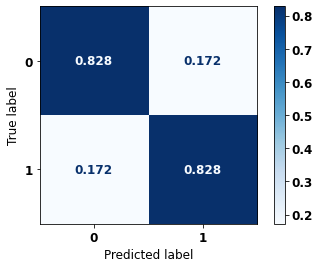


              precision    recall  f1-score   support

           0       0.91      0.83      0.86     84077
           1       0.71      0.83      0.76     42433

    accuracy                           0.83    126510
   macro avg       0.81      0.83      0.81    126510
weighted avg       0.84      0.83      0.83    126510



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, also shows a good performance of the model, with 83% of accuracy.


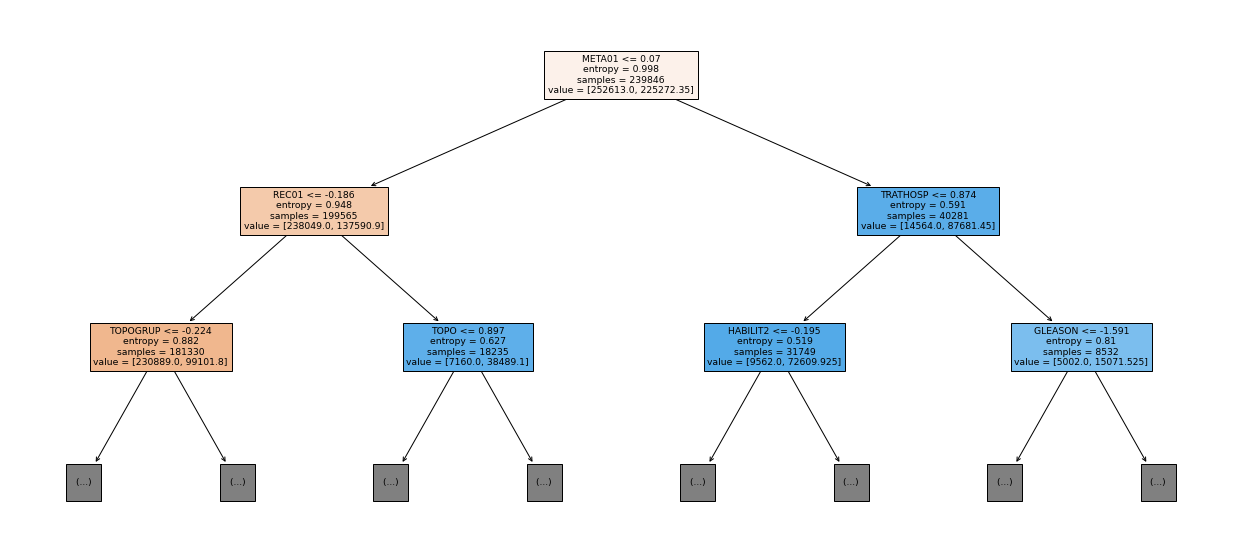

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

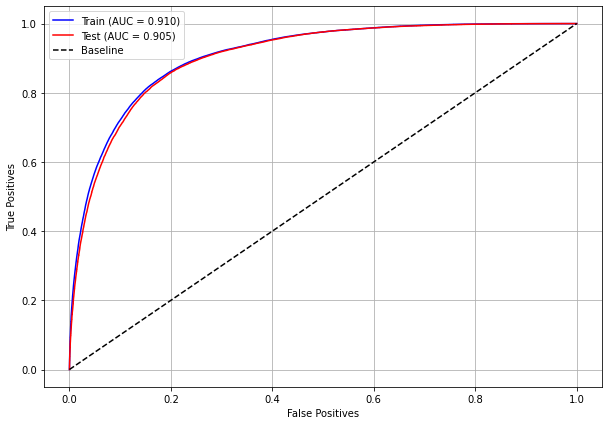

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

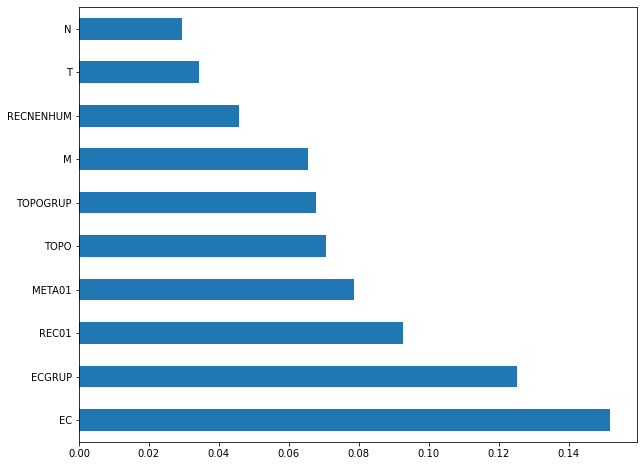

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `REC01` and `META01`.

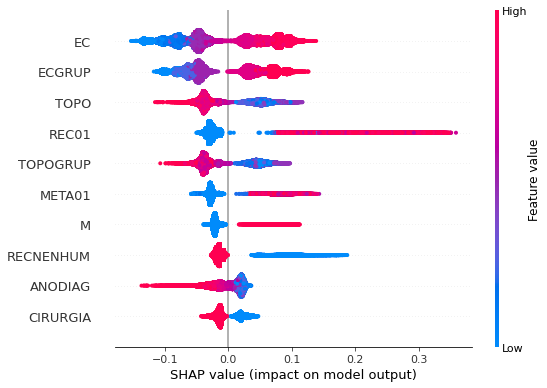

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1, 1:2.034}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 2.034}, criterion='entropy',
                       max_depth=8, random_state=10)

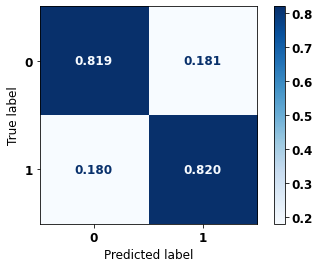


              precision    recall  f1-score   support

           0       0.91      0.82      0.86      5706
           1       0.67      0.82      0.74      2517

    accuracy                           0.82      8223
   macro avg       0.79      0.82      0.80      8223
weighted avg       0.84      0.82      0.82      8223



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm with the other states data shows a good performance of the model, because the model achieves a 82% of accuracy.


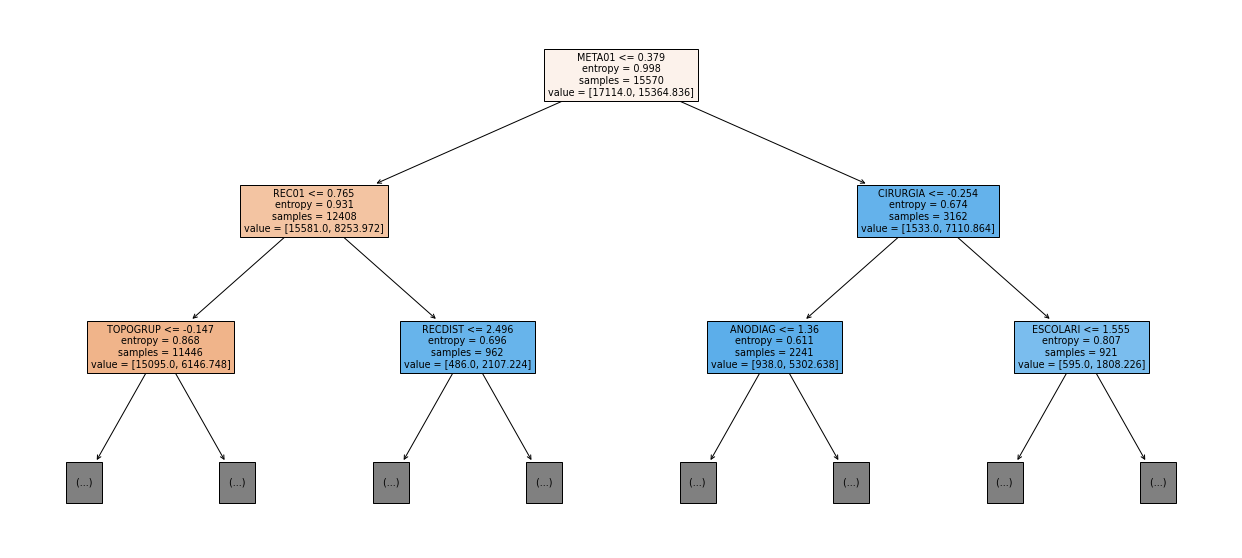

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

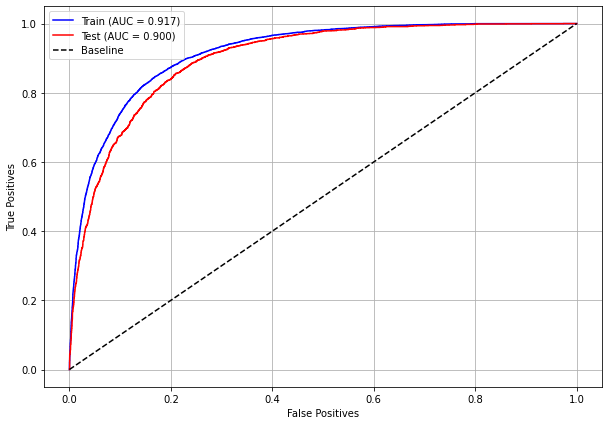

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

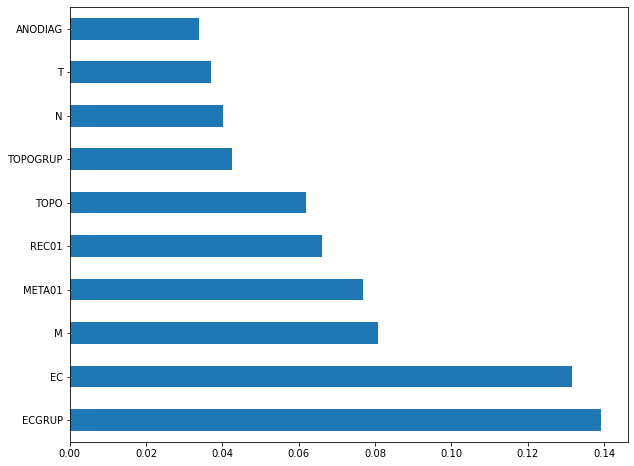

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `EC`, `M` and `META01`.

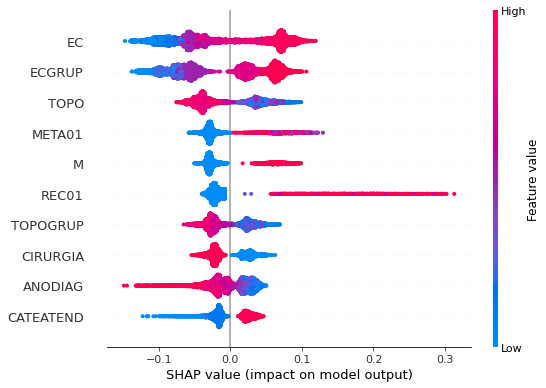

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Again larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 200, 250, 300],
           'max_depth': [5, 8, 10, 15],
           'min_samples_split': [2, 5, 10, 15],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv=5, n_jobs=-1, 
                            random_state=seed)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

In [ ]:
# SP
rf_sp_opt = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:11.5},
                                   max_depth=bestSP.best_params_['max_depth'],
                                   min_samples_leaf=bestSP.best_params_['min_samples_leaf'], 
                                   min_samples_split=bestSP.best_params_['min_samples_split'],
                                   n_estimators=bestSP.best_params_['n_estimators'],
                                   criterion='entropy')

rf_sp_opt.fit(X_train_SP, y_train_SP)

In [ ]:
display_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

In [ ]:
# Other states
rf_fora_opt = RandomForestClassifier(random_state=seed, class_weight={0:1, 1:2.9},
                                     max_depth=bestOS.best_params_['max_depth'],
                                     min_samples_leaf=bestOS.best_params_['min_samples_leaf'], 
                                     min_samples_split=bestOS.best_params_['min_samples_split'],
                                     n_estimators=bestOS.best_params_['n_estimators'],
                                     criterion='entropy')

rf_fora_opt.fit(X_train_OS, y_train_OS)

In [ ]:
display_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.89,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.89)

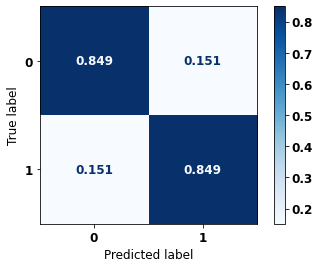


              precision    recall  f1-score   support

           0       0.92      0.85      0.88     84077
           1       0.74      0.85      0.79     42433

    accuracy                           0.85    126510
   macro avg       0.83      0.85      0.84    126510
weighted avg       0.86      0.85      0.85    126510



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, also shows a good performance of the model, with 85% of accuracy.


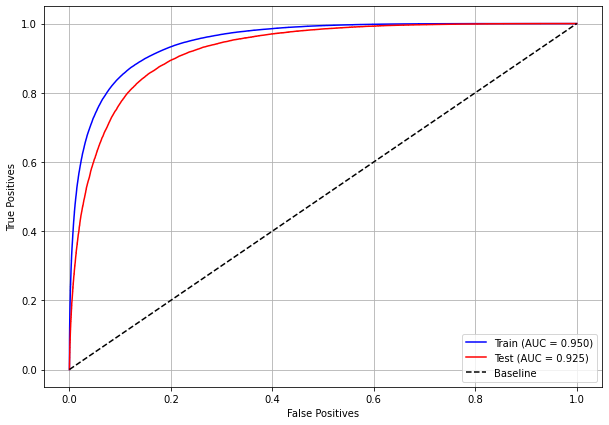

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

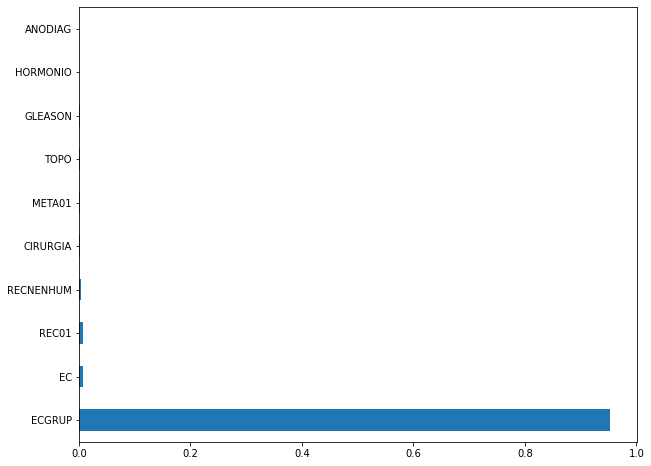

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, with a lot advantage over the others, `EC`, `REC01` and `RECNENHUM`.

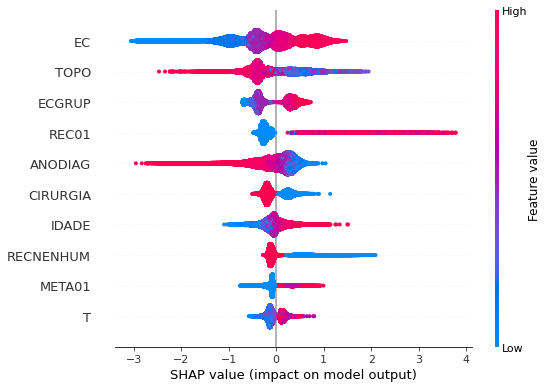

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=8, 
                                 scale_pos_weight=2.6,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=2.6)

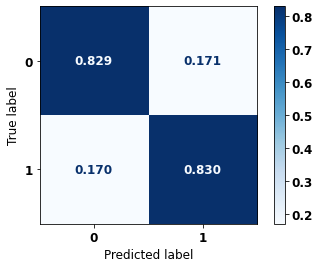


              precision    recall  f1-score   support

           0       0.92      0.83      0.87      5706
           1       0.68      0.83      0.75      2517

    accuracy                           0.83      8223
   macro avg       0.80      0.83      0.81      8223
weighted avg       0.85      0.83      0.83      8223



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm with SP data shows a good performance of the model, because the model achieves a 83% of accuracy.


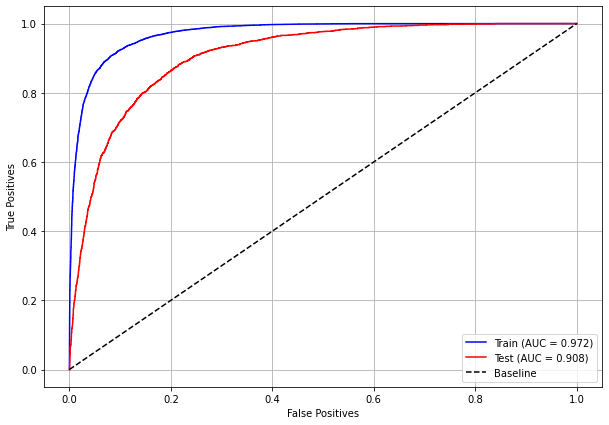

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

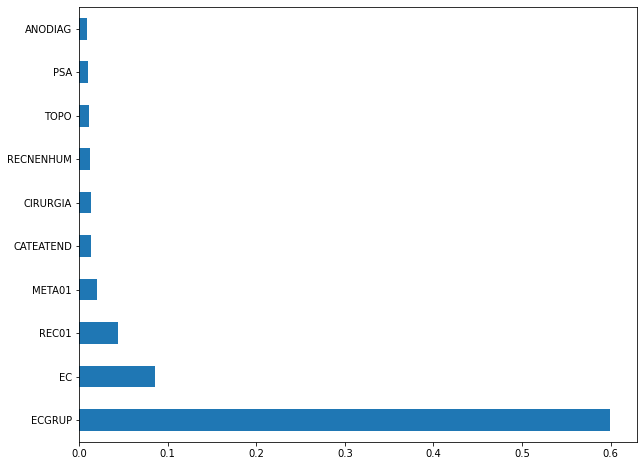

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, with a good advantage, `EC`, `REC01` and `META01`.

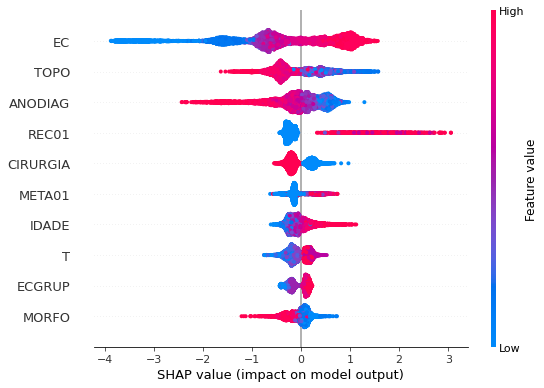

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the EC column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
            'max_depth': [5, 8, 10, 12, 15, 20, 30],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            'n_estimators': [100, 150, 200, 250, 300]}

xgboost = xgb.XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv=5, n_jobs=-1, 
                           random_state=seed)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'colsample_bytree': 0.3,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 15,
 'min_child_weight': 5,
 'n_estimators': 250}

In [ ]:
# SP
xgb_sp_opt = xgb.XGBClassifier(random_state=seed, scale_pos_weight=2.2,
                               colsample_bytree=bestSP.best_params_['colsample_bytree'], 
                               gamma=bestSP.best_params_['gamma'], 
                               learning_rate=bestSP.best_params_['learning_rate'], 
                               max_depth=bestSP.best_params_['max_depth'], 
                               min_child_weight=bestSP.best_params_['min_child_weight'],
                               n_estimators=bestSP.best_params_['n_estimators'])

xgb_sp_opt.fit(X_train_SP, y_train_SP)

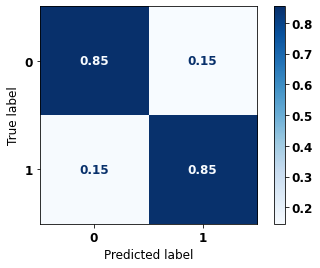


              precision    recall  f1-score   support

           0       0.92      0.85      0.88     84077
           1       0.75      0.85      0.79     42433

    accuracy                           0.85    126510
   macro avg       0.83      0.85      0.84    126510
weighted avg       0.86      0.85      0.85    126510



In [ ]:
display_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.2,
 'learning_rate': 0.05,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 150}

In [ ]:
# Other states
xgb_fora_opt = xgb.XGBClassifier(random_state=seed, scale_pos_weight=2.35,
                                 colsample_bytree=bestOS.best_params_['colsample_bytree'], 
                                 gamma=bestOS.best_params_['gamma'], 
                                 learning_rate=bestOS.best_params_['learning_rate'], 
                                 max_depth=bestOS.best_params_['max_depth'], 
                                 min_child_weight=bestOS.best_params_['min_child_weight'])

xgb_fora_opt.fit(X_train_OS, y_train_OS)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=10,
              min_child_weight=7, random_state=10, scale_pos_weight=2.35)

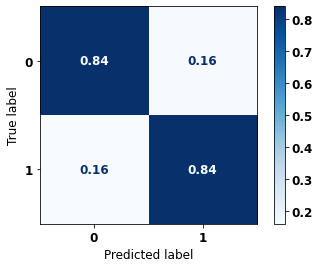


              precision    recall  f1-score   support

           0       0.92      0.84      0.88      5706
           1       0.69      0.84      0.76      2517

    accuracy                           0.84      8223
   macro avg       0.81      0.84      0.82      8223
weighted avg       0.85      0.84      0.84      8223



In [ ]:
display_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS)

# **Second approach**

Approach using only morphologies with final digit equal to 3 and without `EC` column as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (351486, 65), X_test = (117163, 65)
y_train = (351486,), y_test = (117163,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora, list_drop, lb, 
                                                                           morpho3=True, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (23079, 65), X_test = (7693, 65)
y_train = (23079,), y_test = (7693,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(random_state=seed, 
                               class_weight={0:1, 1:1.67},
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.67}, criterion='entropy',
                       max_depth=10, random_state=10)

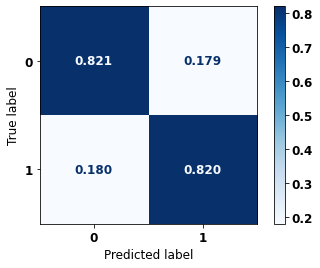


              precision    recall  f1-score   support

           0       0.89      0.82      0.85     74785
           1       0.72      0.82      0.77     42378

    accuracy                           0.82    117163
   macro avg       0.81      0.82      0.81    117163
weighted avg       0.83      0.82      0.82    117163



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, also shows a good performance of the model, with 82% of accuracy.


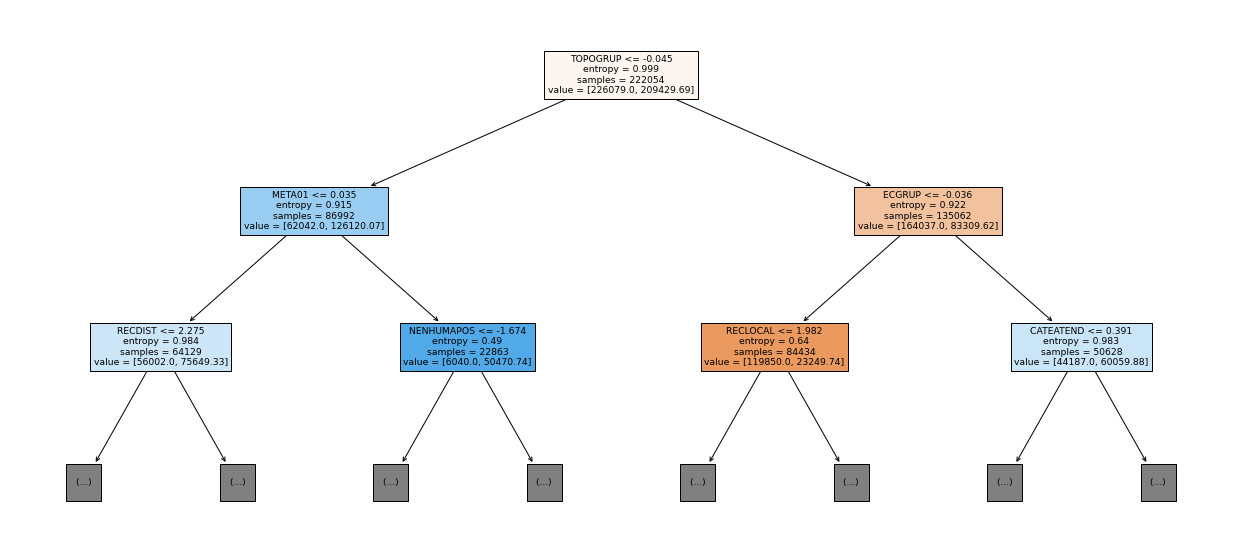

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

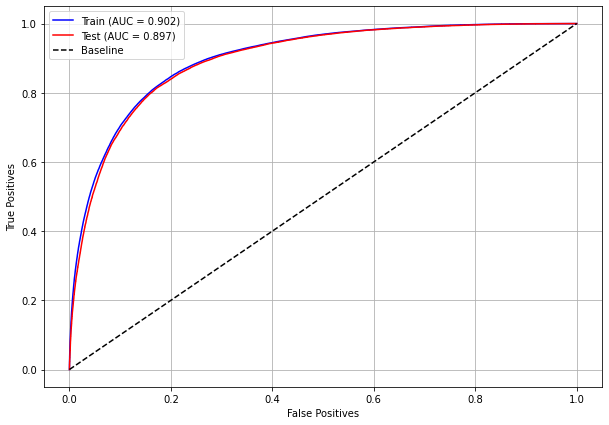

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

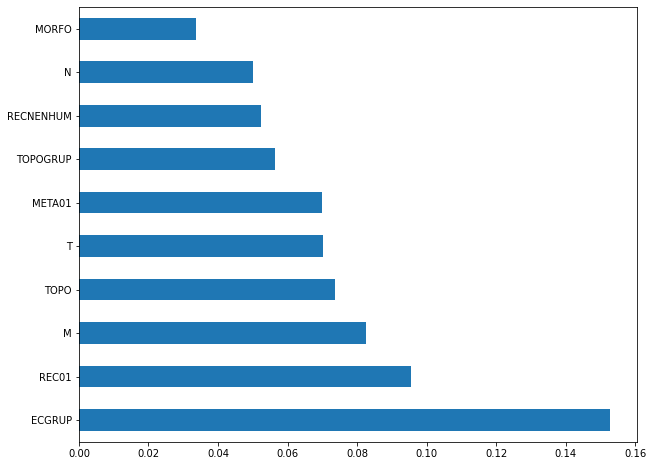

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `TOPO`.

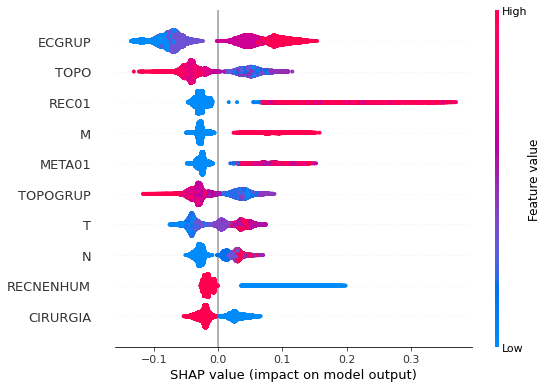

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(random_state=seed, 
                                 class_weight={0:1, 1:1.72},
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.72}, criterion='entropy',
                       max_depth=8, random_state=10)

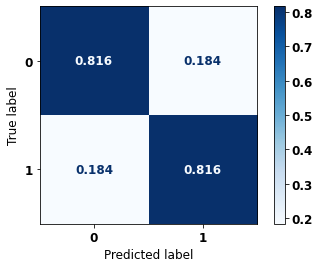


              precision    recall  f1-score   support

           0       0.90      0.82      0.86      5162
           1       0.68      0.82      0.74      2531

    accuracy                           0.82      7693
   macro avg       0.79      0.82      0.80      7693
weighted avg       0.83      0.82      0.82      7693



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm with other states data shows a good performance of the model, because the model achieves a 82% of accuracy.


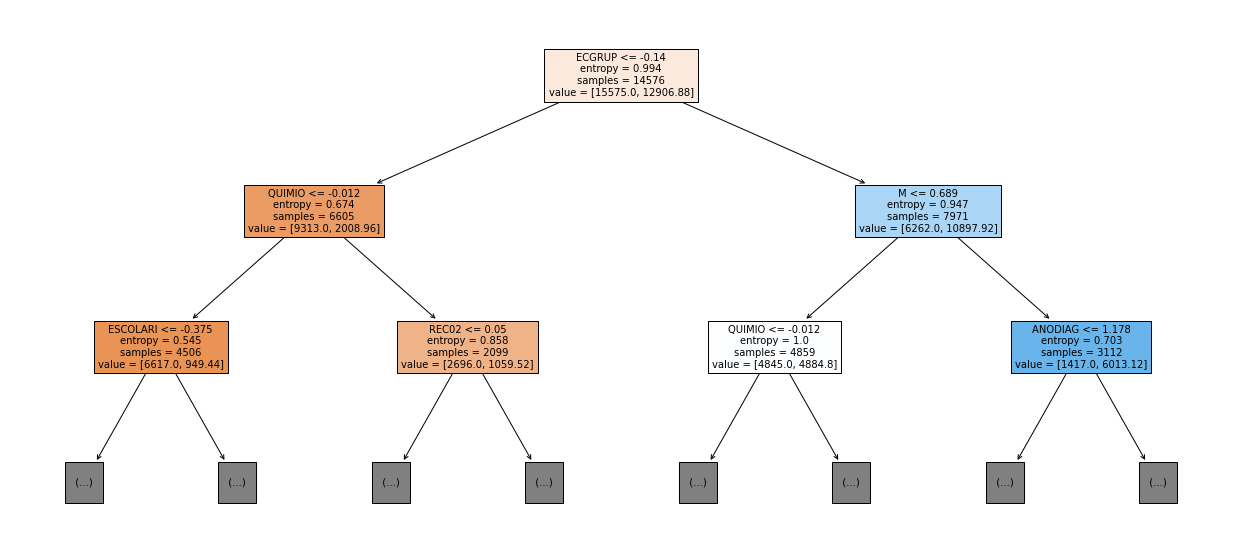

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

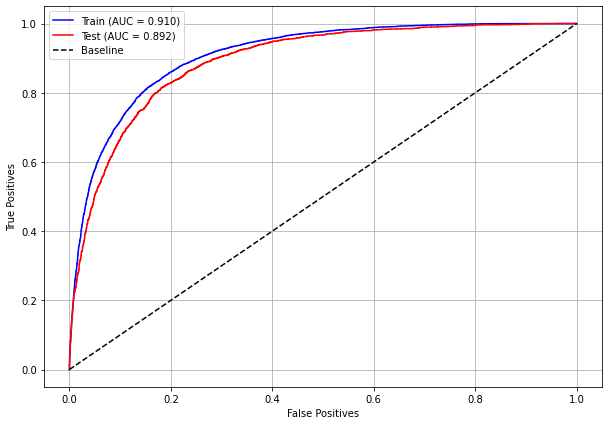

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

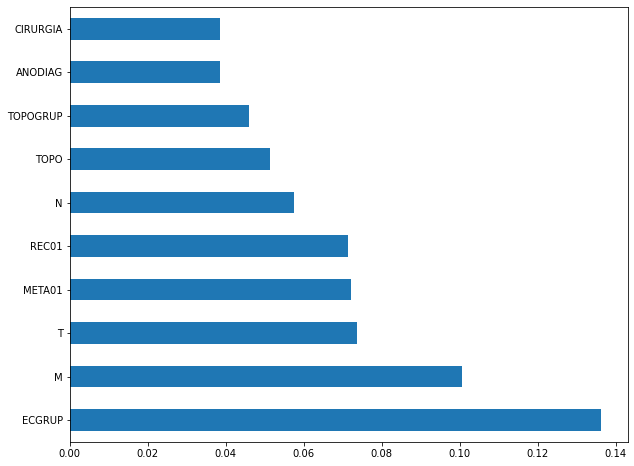

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `META01`.

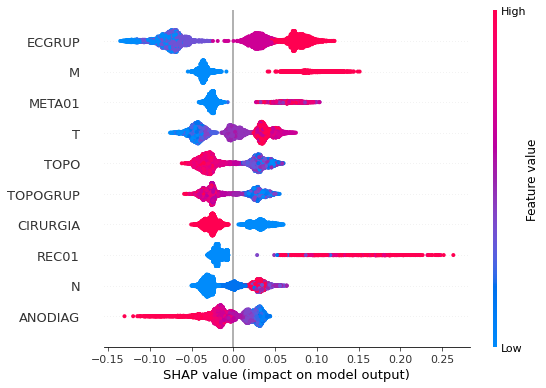

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = xgb.XGBClassifier(max_depth=10, 
                               scale_pos_weight=1.7,
                               random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.7)

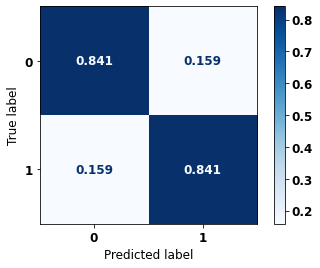


              precision    recall  f1-score   support

           0       0.90      0.84      0.87     74785
           1       0.75      0.84      0.79     42378

    accuracy                           0.84    117163
   macro avg       0.83      0.84      0.83    117163
weighted avg       0.85      0.84      0.84    117163



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, also shows a good performance of the model, with 84% of accuracy.


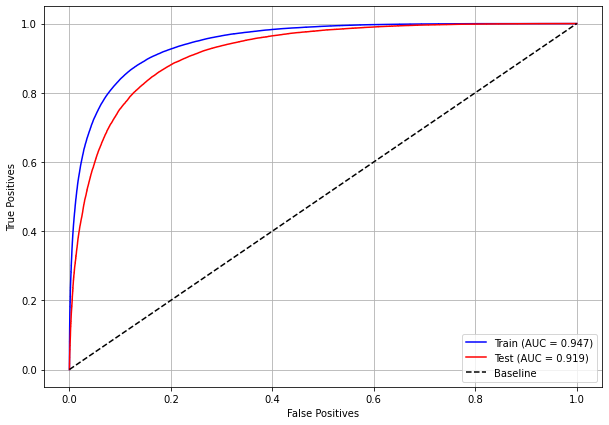

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

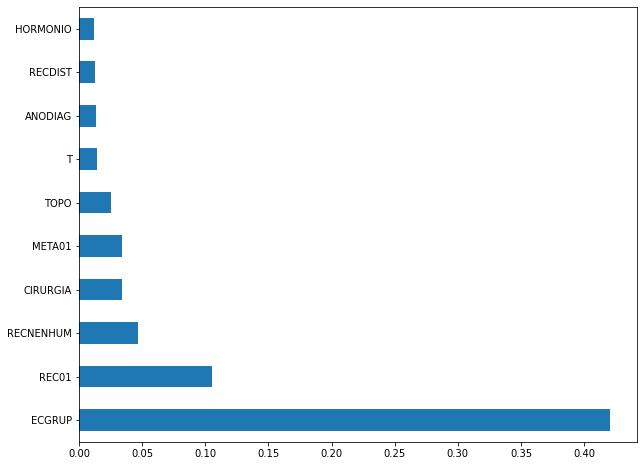

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `REC01`, `RECNENHUM` and `CIRURGIA`.

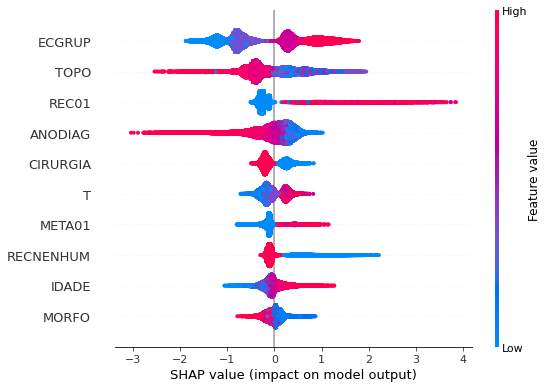

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = xgb.XGBClassifier(max_depth=8, 
                                 scale_pos_weight=2.03,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=2.03)

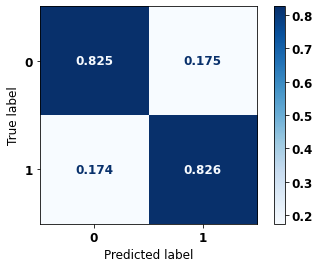


              precision    recall  f1-score   support

           0       0.91      0.83      0.86      5162
           1       0.70      0.83      0.76      2531

    accuracy                           0.83      7693
   macro avg       0.80      0.83      0.81      7693
weighted avg       0.84      0.83      0.83      7693



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm with SP data shows a good performance of the model, because the model achieves a 83% of accuracy.


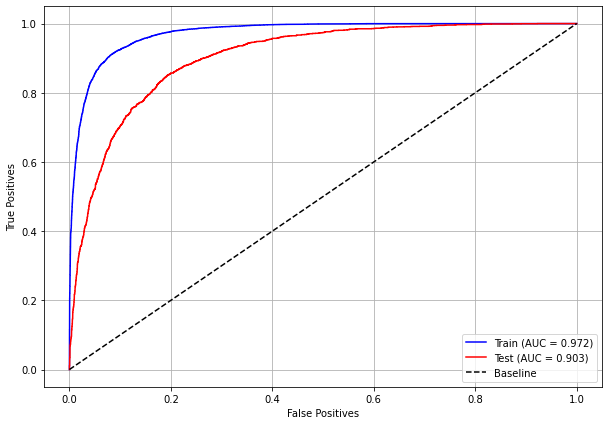

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

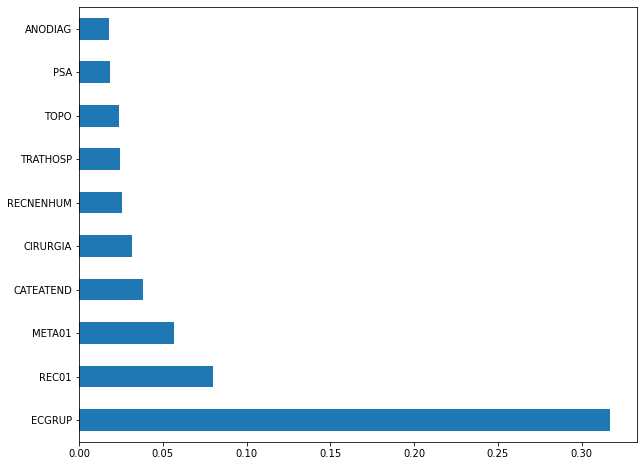

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `REC01`, `META01` and `CATEATEND`.

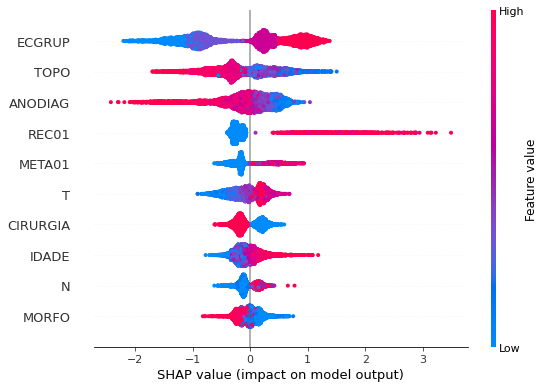

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

# **Third approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (49873, 65), X_test = (16625, 65)
y_train = (49873,), y_test = (16625,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (62658, 65), X_test = (20887, 65)
y_train = (62658,), y_test = (20887,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (83228, 65), X_test = (27743, 65)
y_train = (83228,), y_test = (27743,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (103890, 65), X_test = (34630, 65)
y_train = (103890,), y_test = (34630,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2021, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (79877, 65), X_test = (26626, 65)
y_train = (79877,), y_test = (26626,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2802, 65), X_test = (935, 65)
y_train = (2802,), y_test = (935,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3942, 65), X_test = (1315, 65)
y_train = (3942,), y_test = (1315,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4842, 65), X_test = (1614, 65)
y_train = (4842,), y_test = (1614,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6456, 65), X_test = (2153, 65)
y_train = (6456,), y_test = (2153,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2016, 
                                                                                                last_year=2020, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6624, 65), X_test = (2208, 65)
y_train = (6624,), y_test = (2208,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models still have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.183},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.183}, criterion='entropy',
                       max_depth=10, random_state=10)

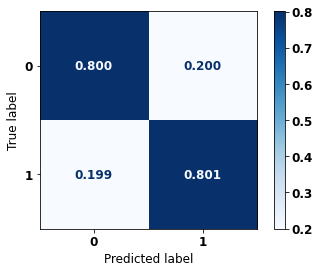


              precision    recall  f1-score   support

           0       0.83      0.80      0.82      9240
           1       0.76      0.80      0.78      7385

    accuracy                           0.80     16625
   macro avg       0.80      0.80      0.80     16625
weighted avg       0.80      0.80      0.80     16625



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 80% of accuracy.


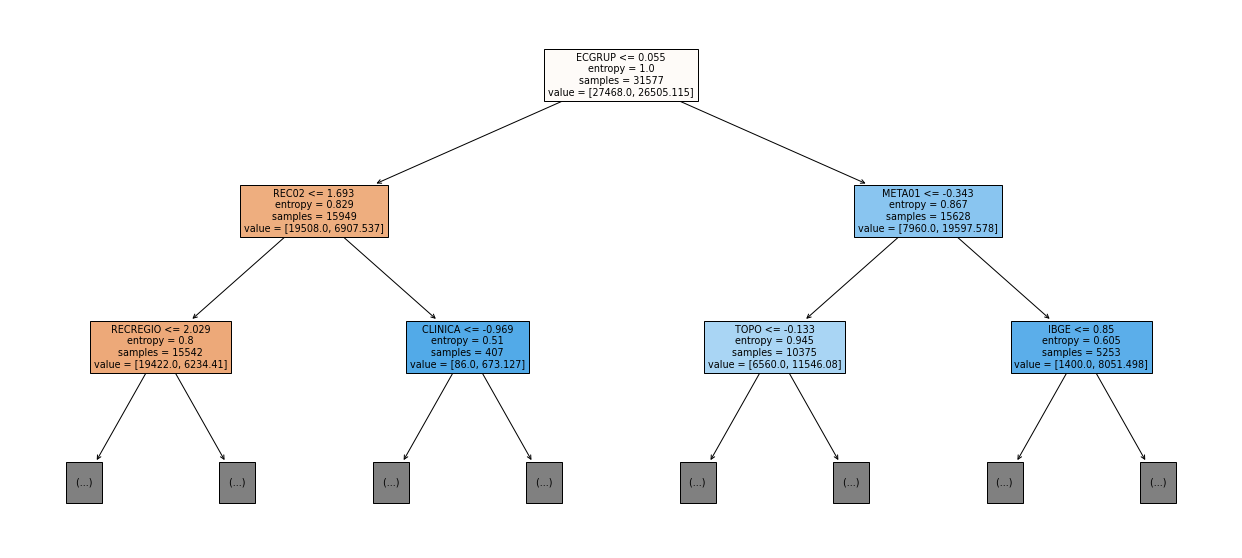

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

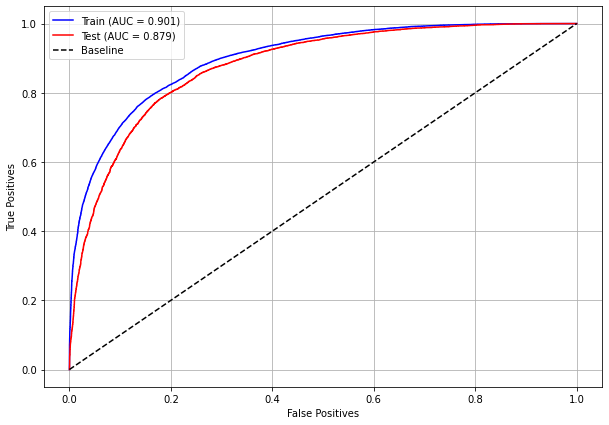

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

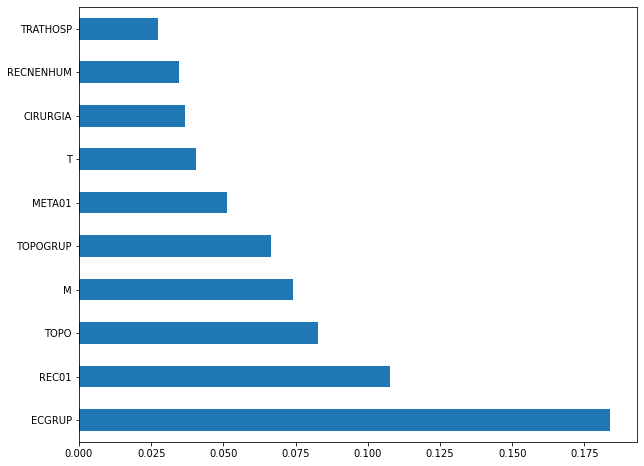

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `REC01`, `TOPO`, and `M`. 

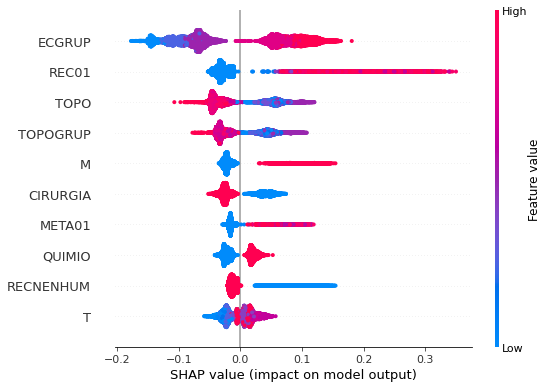

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.33},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.33}, criterion='entropy',
                       max_depth=10, random_state=10)

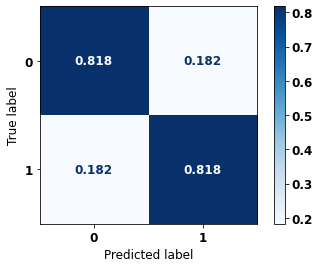


              precision    recall  f1-score   support

           0       0.86      0.82      0.84     12254
           1       0.76      0.82      0.79      8633

    accuracy                           0.82     20887
   macro avg       0.81      0.82      0.81     20887
weighted avg       0.82      0.82      0.82     20887



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 82% of accuracy.

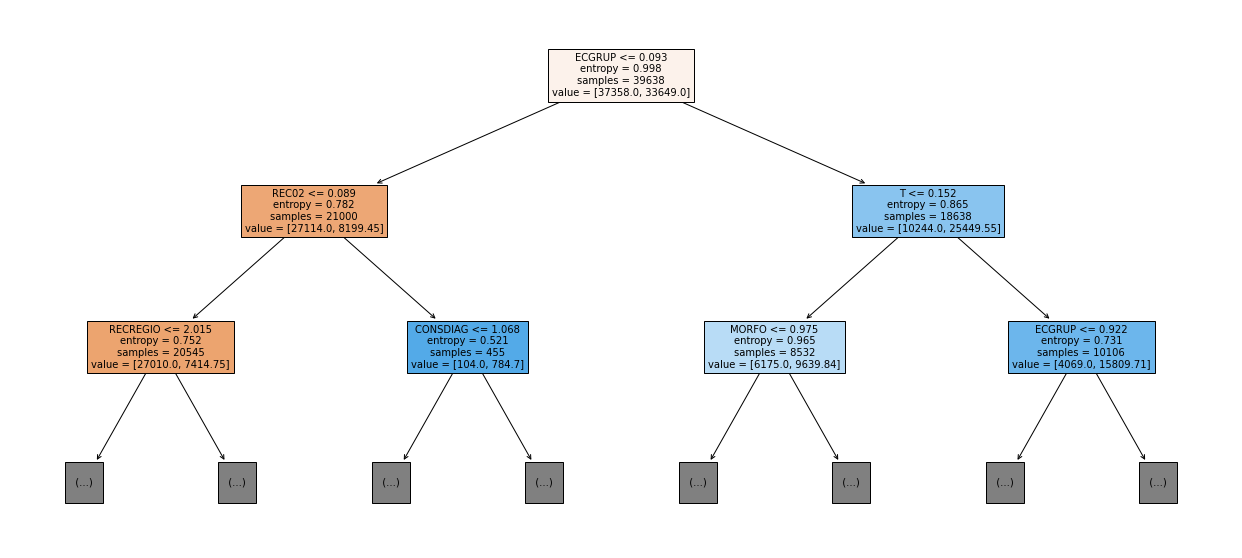

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

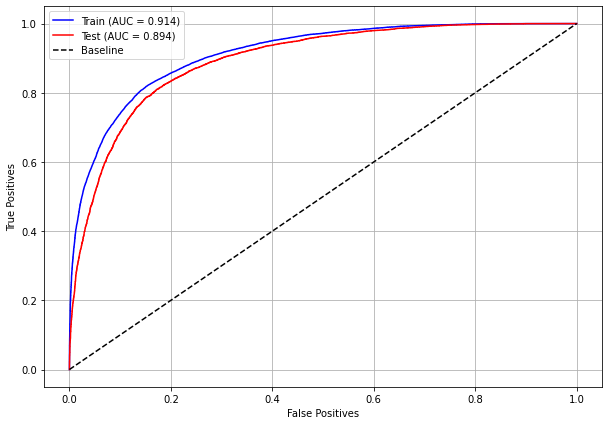

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

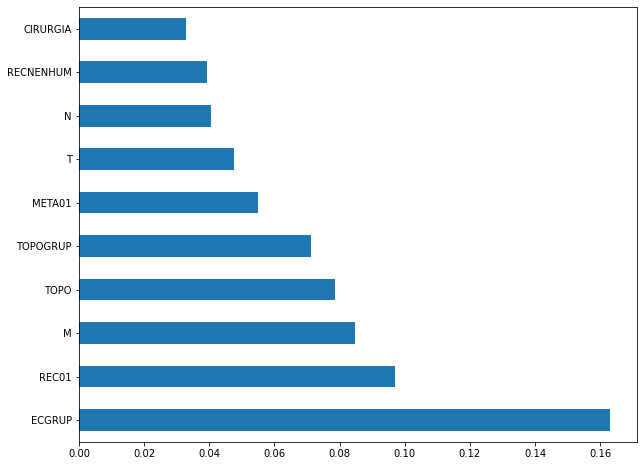

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `TOPO`.

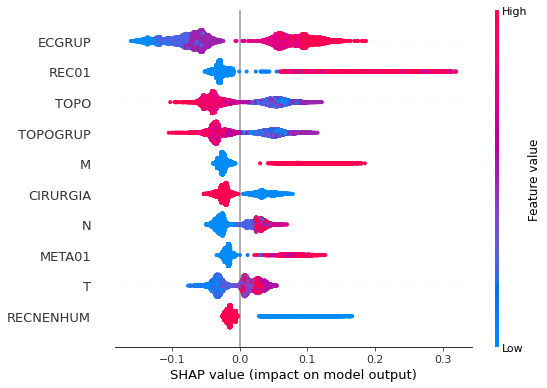

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.605},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.605}, criterion='entropy',
                       max_depth=10, random_state=10)

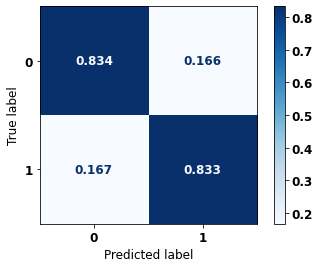


              precision    recall  f1-score   support

           0       0.90      0.83      0.86     17545
           1       0.74      0.83      0.79     10198

    accuracy                           0.83     27743
   macro avg       0.82      0.83      0.82     27743
weighted avg       0.84      0.83      0.83     27743



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuracy.

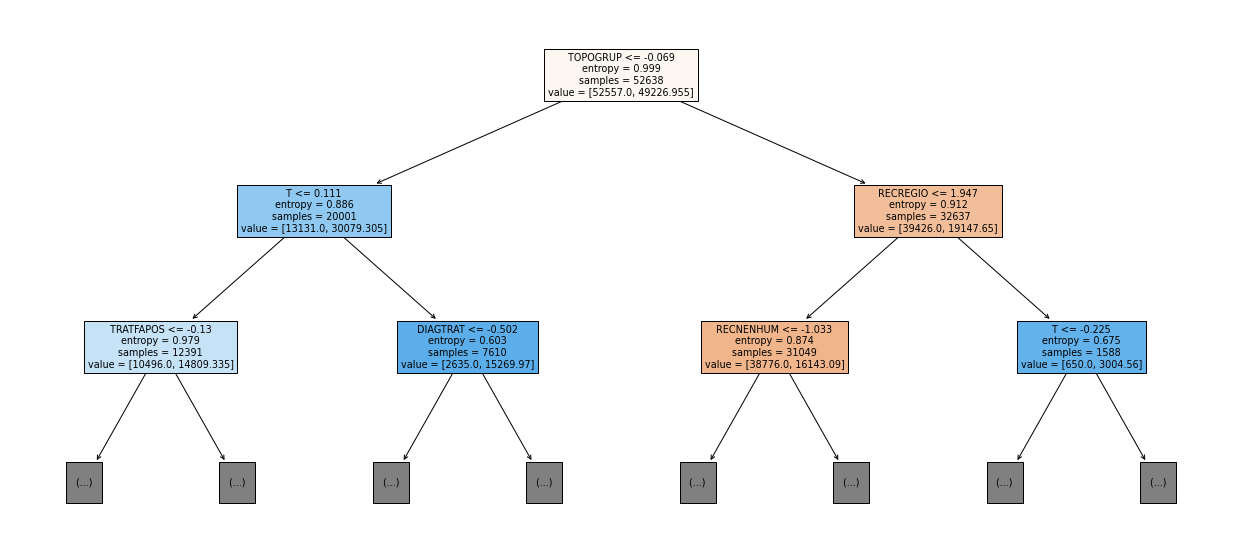

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

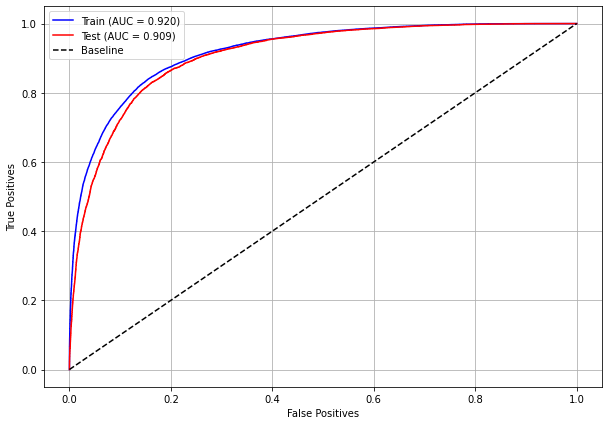

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

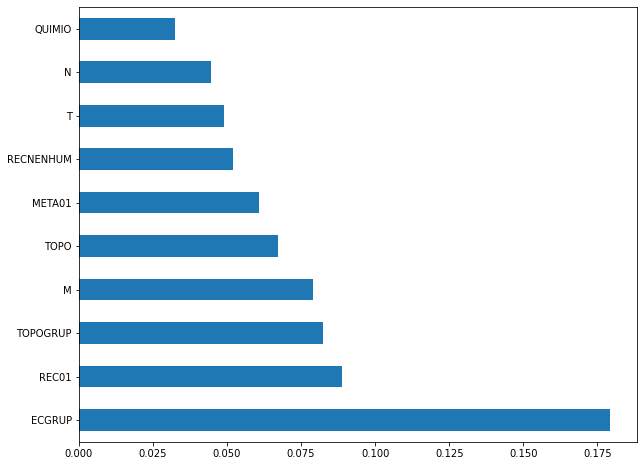

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `REC01`, `TOPOGRUP` and `M`.

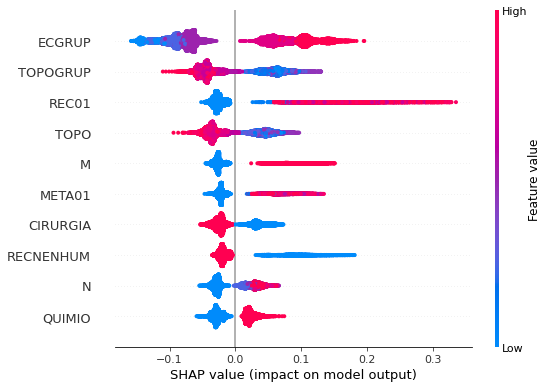

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.2},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.2}, criterion='entropy',
                       max_depth=10, random_state=10)

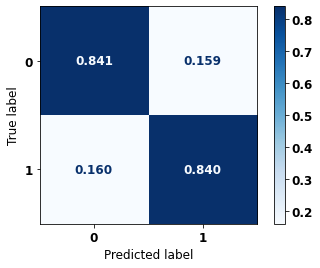


              precision    recall  f1-score   support

           0       0.93      0.84      0.88     24288
           1       0.69      0.84      0.76     10342

    accuracy                           0.84     34630
   macro avg       0.81      0.84      0.82     34630
weighted avg       0.86      0.84      0.84     34630



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 84% of accuracy.

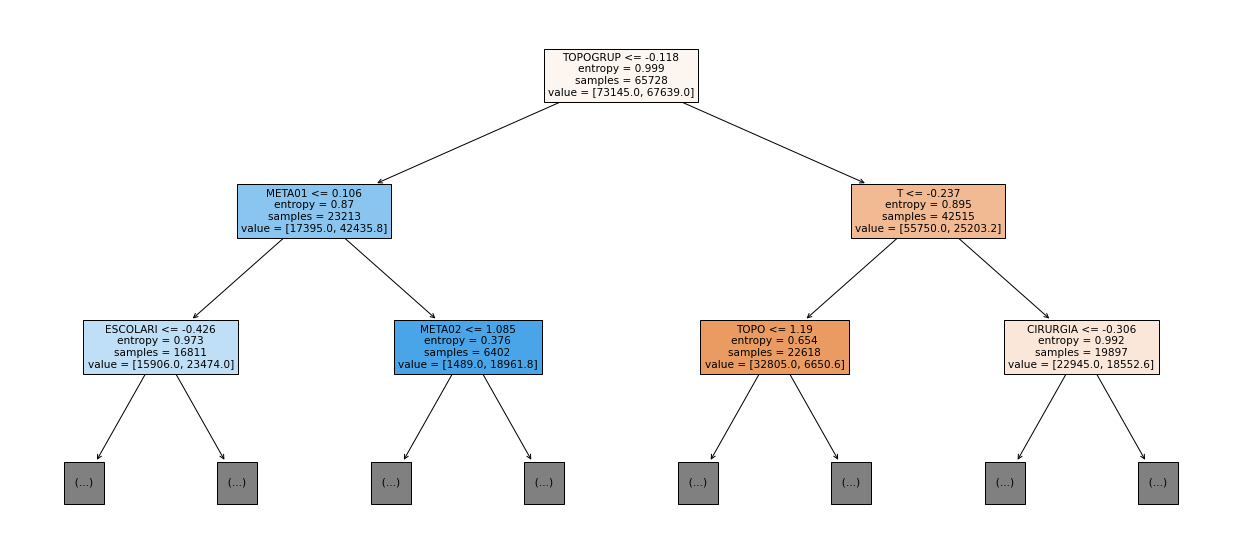

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

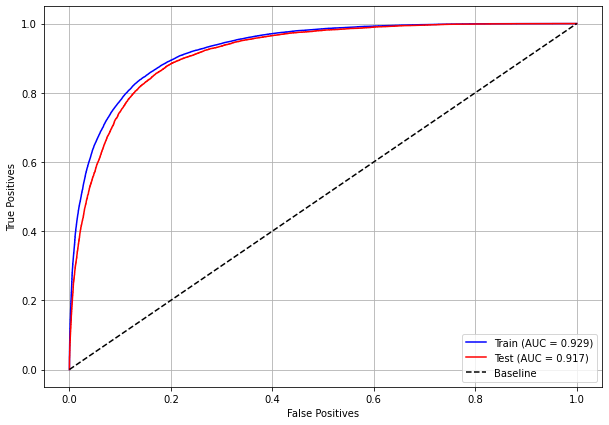

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

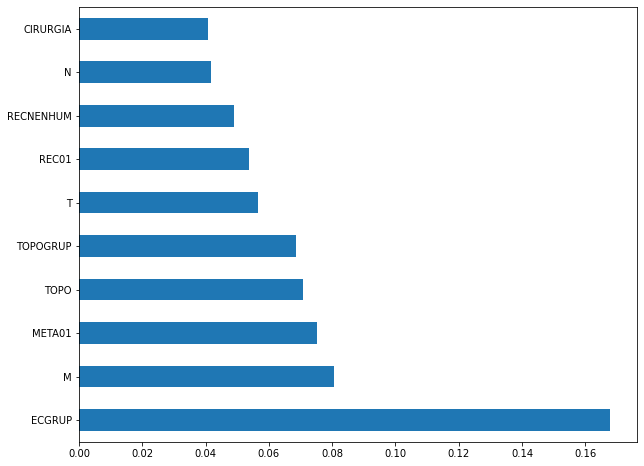

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `TOPO`.

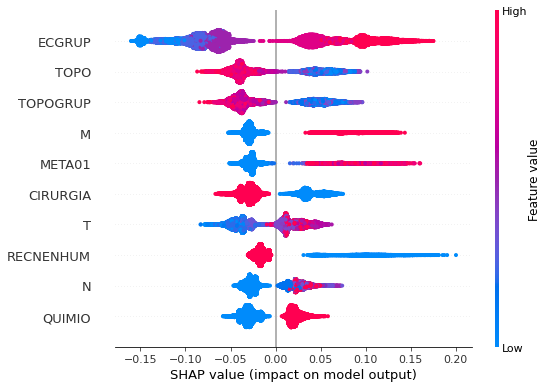

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:3.1},
                                     criterion='entropy', 
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 3.1}, criterion='entropy',
                       max_depth=10, random_state=10)

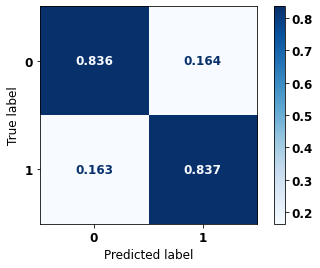


              precision    recall  f1-score   support

           0       0.95      0.84      0.89     20945
           1       0.58      0.84      0.69      5681

    accuracy                           0.84     26626
   macro avg       0.77      0.84      0.79     26626
weighted avg       0.87      0.84      0.85     26626



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 84% of accuracy.

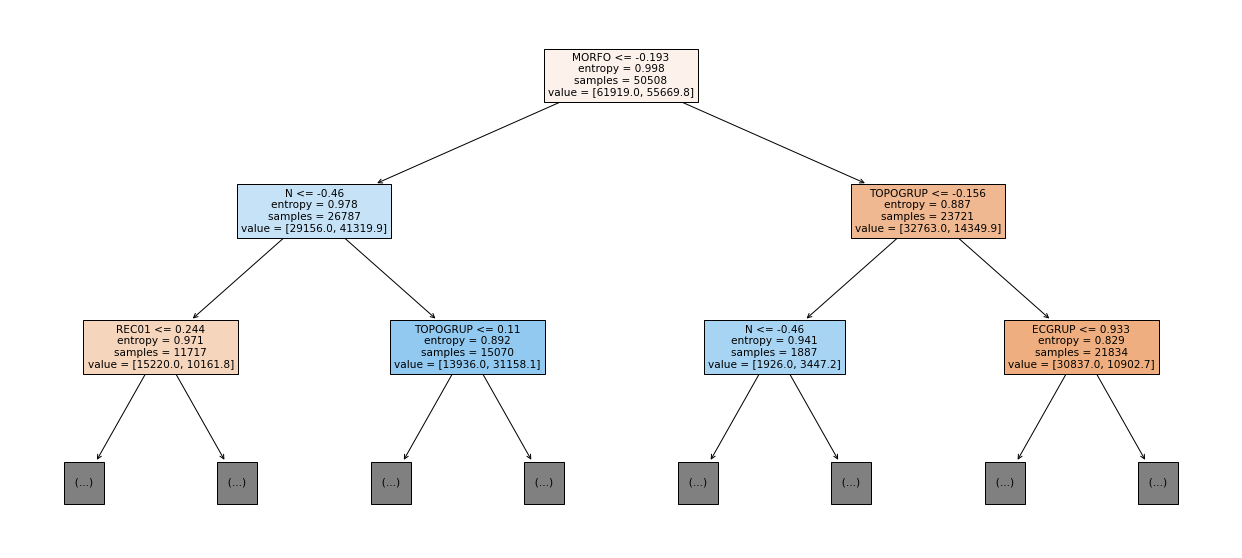

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

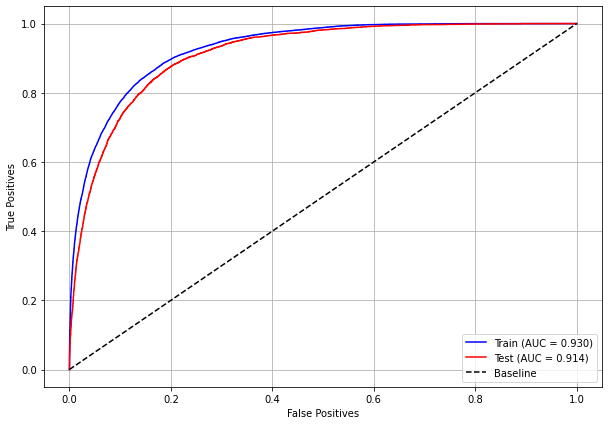

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

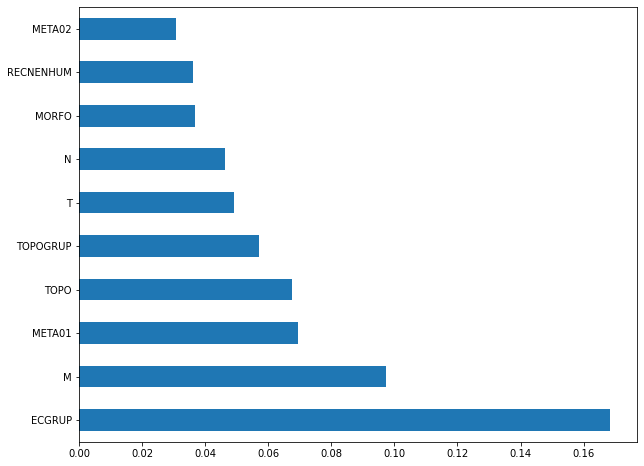

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `META01`, and `TOPO`.



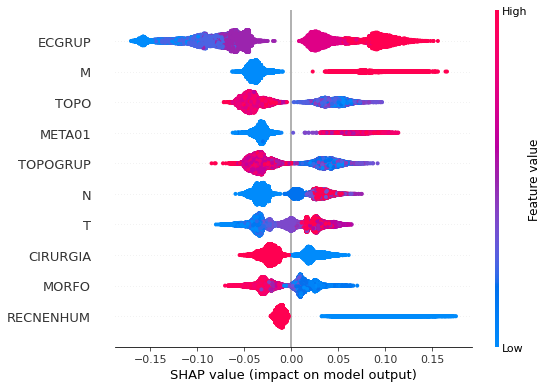

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.8505},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.8505}, criterion='entropy',
                       max_depth=8, random_state=10)

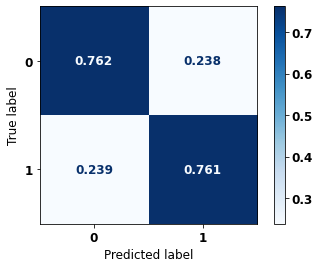


              precision    recall  f1-score   support

           0       0.83      0.76      0.79       563
           1       0.68      0.76      0.72       372

    accuracy                           0.76       935
   macro avg       0.75      0.76      0.76       935
weighted avg       0.77      0.76      0.76       935



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 76% of accuracy.

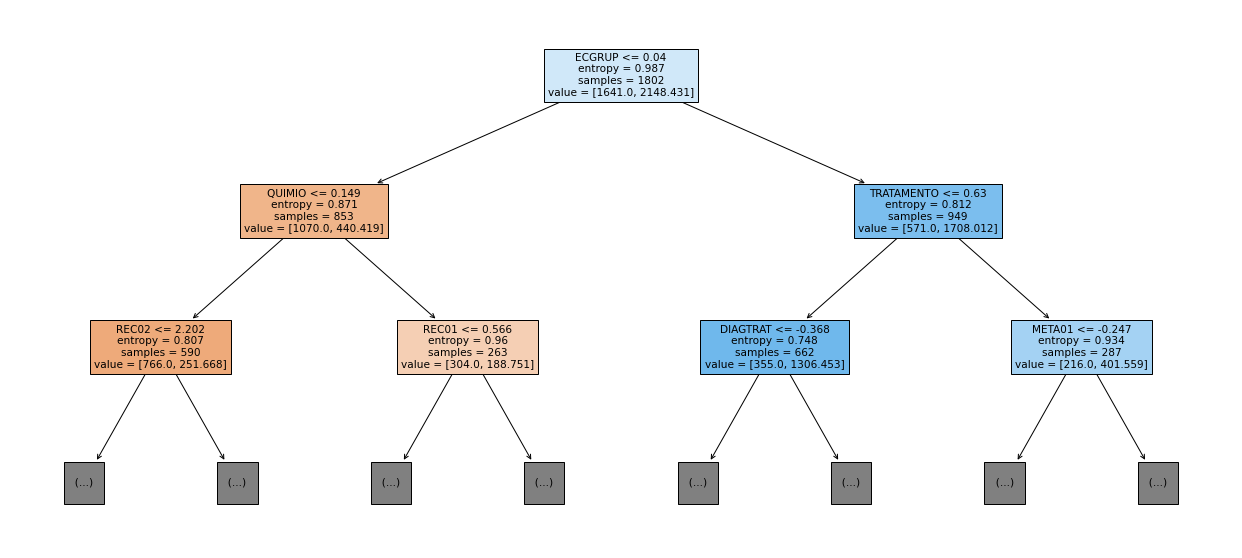

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

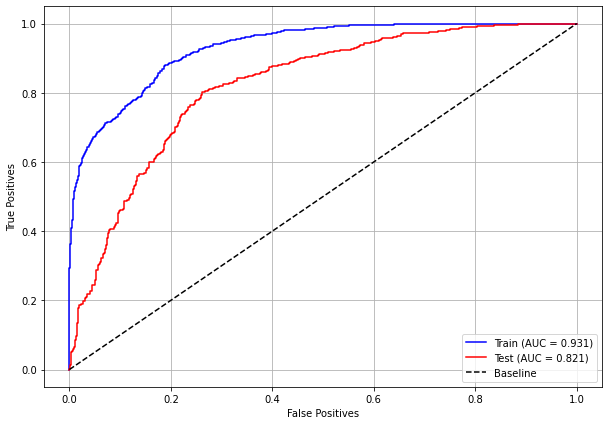

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

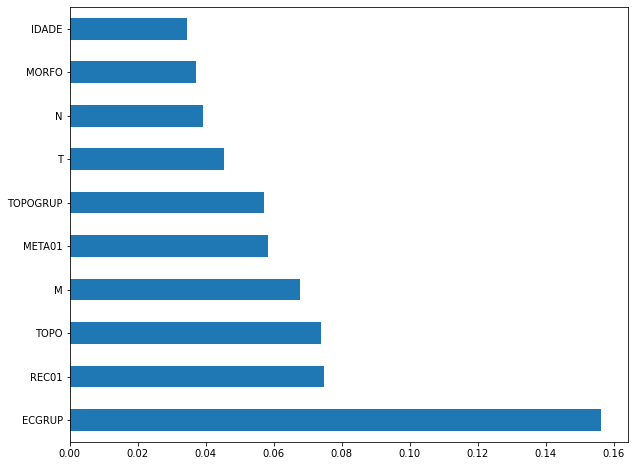

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `REC01`, `TOPO` and `M`.

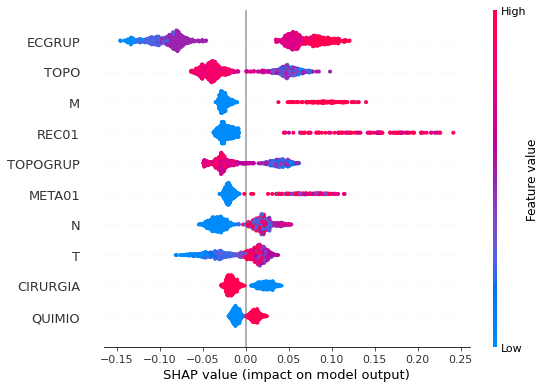

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.5},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.5}, criterion='entropy',
                       max_depth=8, random_state=10)

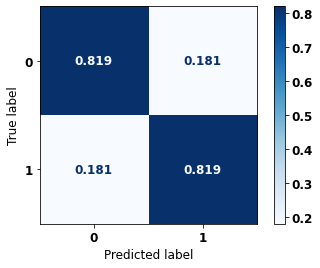


              precision    recall  f1-score   support

           0       0.88      0.82      0.85       818
           1       0.73      0.82      0.77       497

    accuracy                           0.82      1315
   macro avg       0.81      0.82      0.81      1315
weighted avg       0.83      0.82      0.82      1315



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 82% of accuracy.


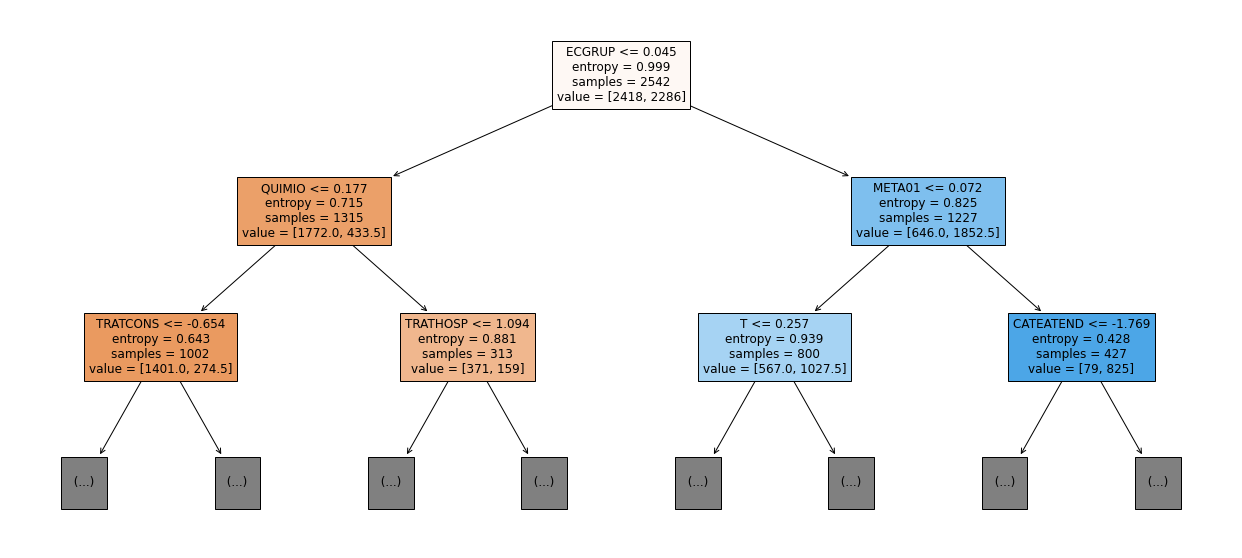

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

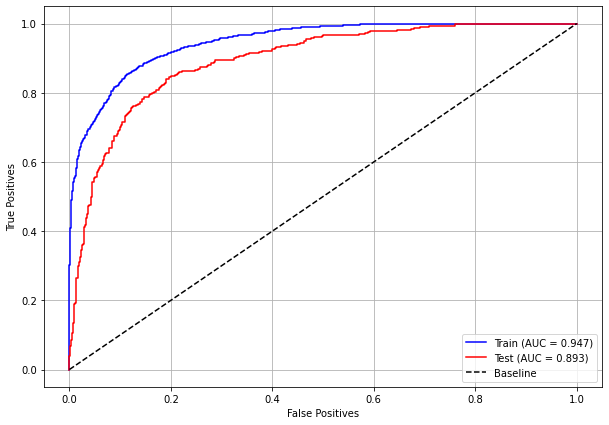

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

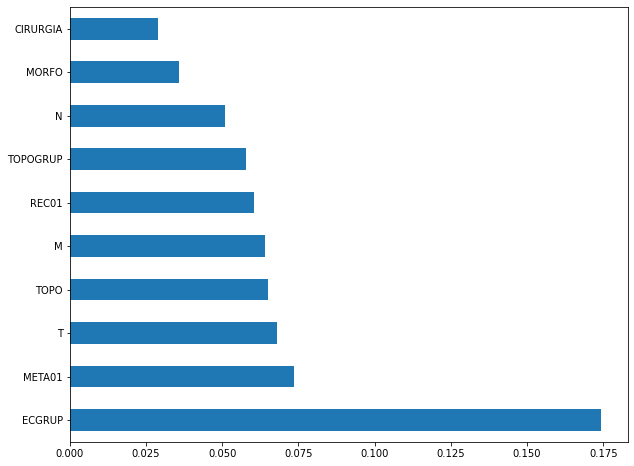

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `META01`, `T` and `TOPO`.

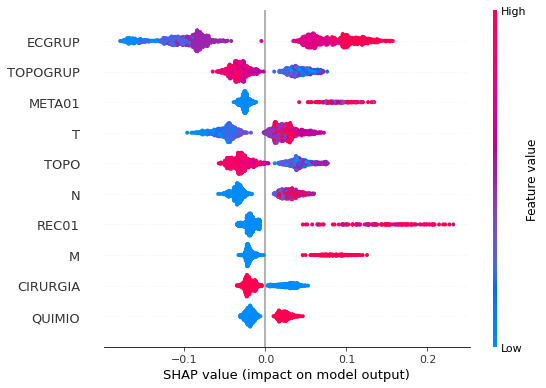

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.19},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 2.19}, criterion='entropy',
                       max_depth=8, random_state=10)

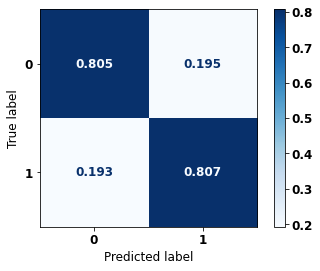


              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1054
           1       0.69      0.81      0.74       560

    accuracy                           0.81      1614
   macro avg       0.79      0.81      0.79      1614
weighted avg       0.82      0.81      0.81      1614



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


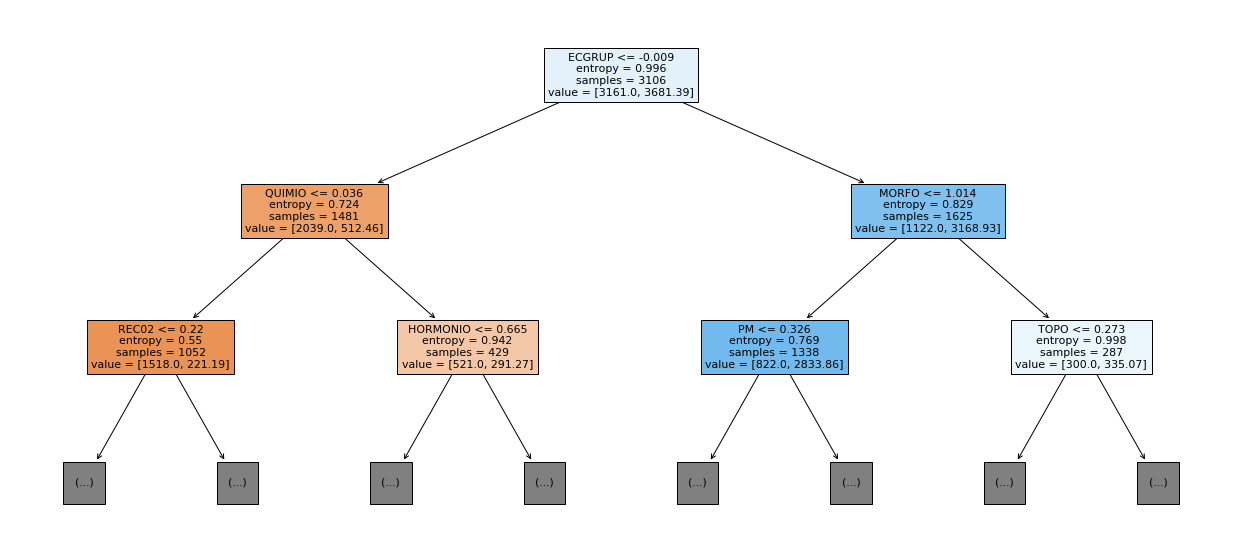

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

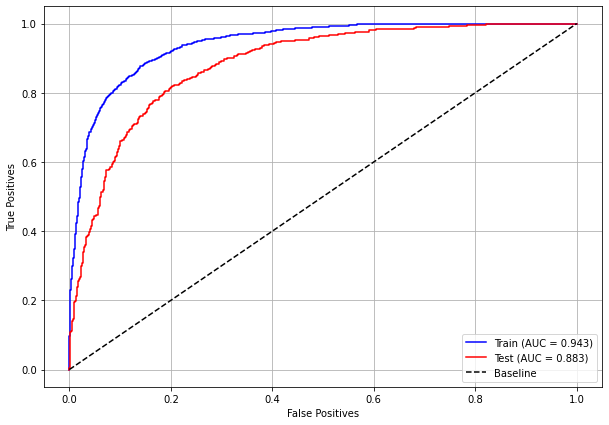

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

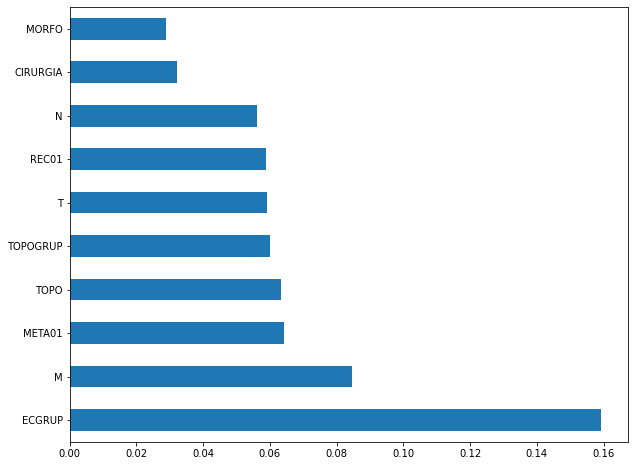

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `TOPO`.

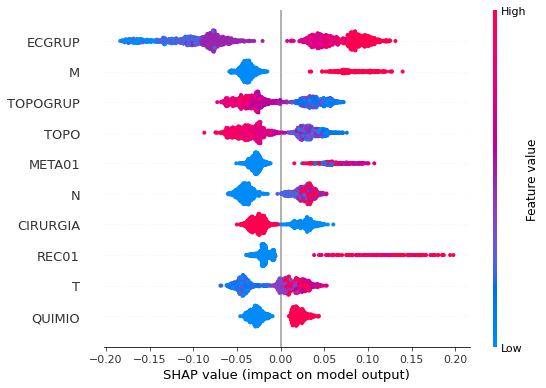

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:3.1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 3.1}, criterion='entropy',
                       max_depth=8, random_state=10)

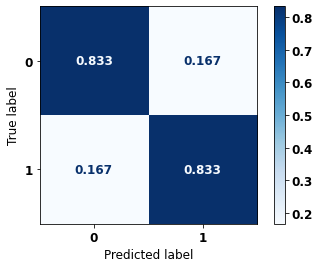


              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1565
           1       0.65      0.83      0.73       588

    accuracy                           0.83      2153
   macro avg       0.79      0.83      0.80      2153
weighted avg       0.85      0.83      0.84      2153



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


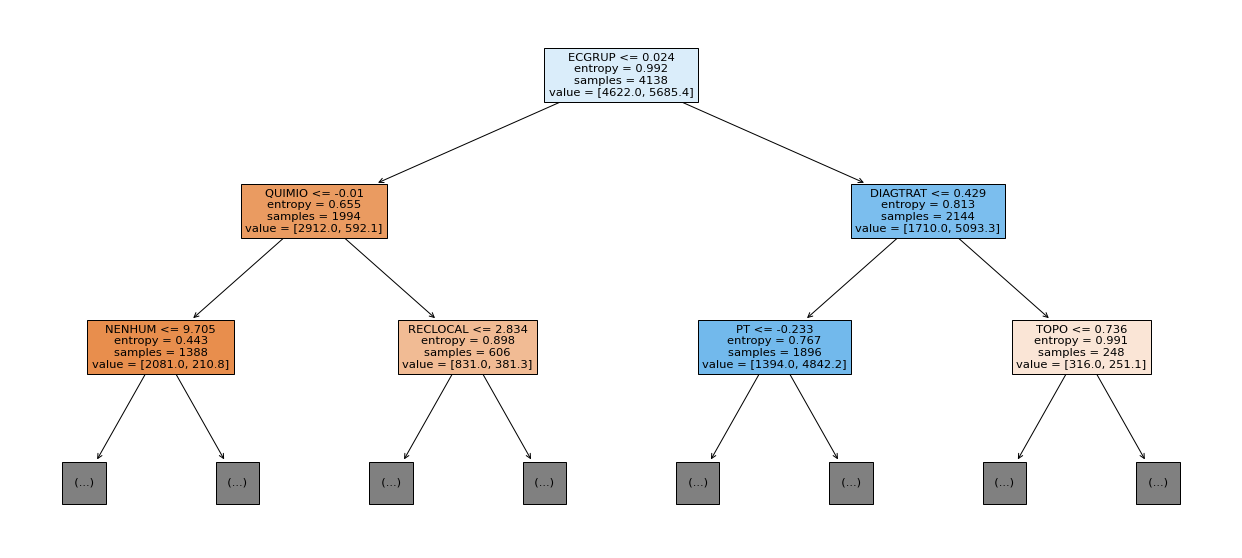

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

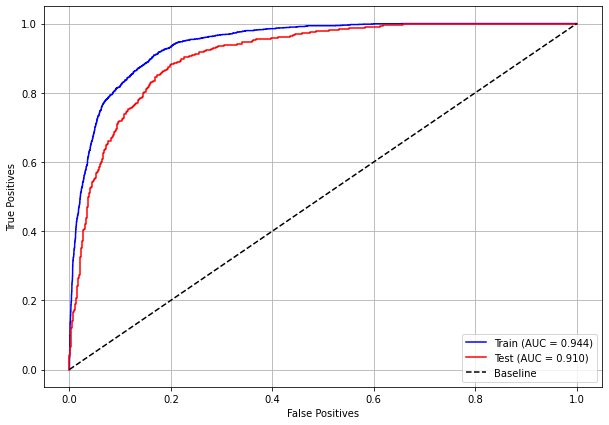

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

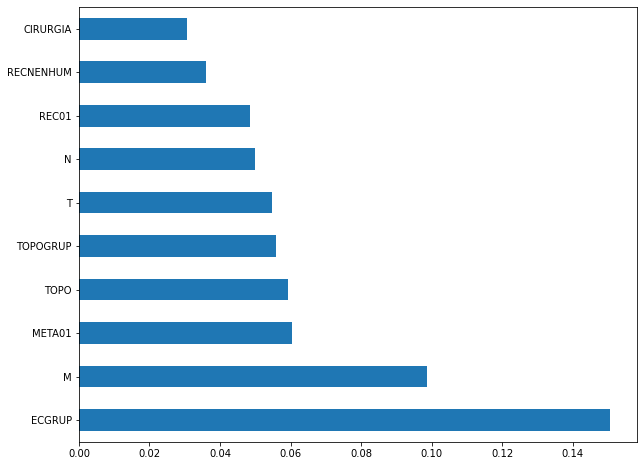

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `TOPO`.

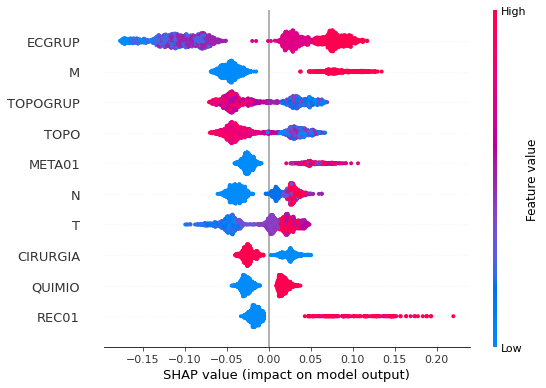

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:3.55},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 3.55}, criterion='entropy',
                       max_depth=8, random_state=10)

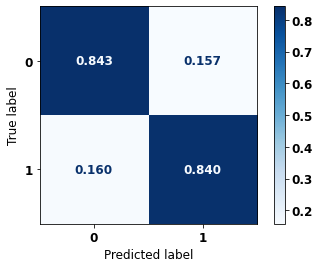


              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1690
           1       0.62      0.84      0.71       518

    accuracy                           0.84      2208
   macro avg       0.78      0.84      0.80      2208
weighted avg       0.87      0.84      0.85      2208



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 84% of accuracy.


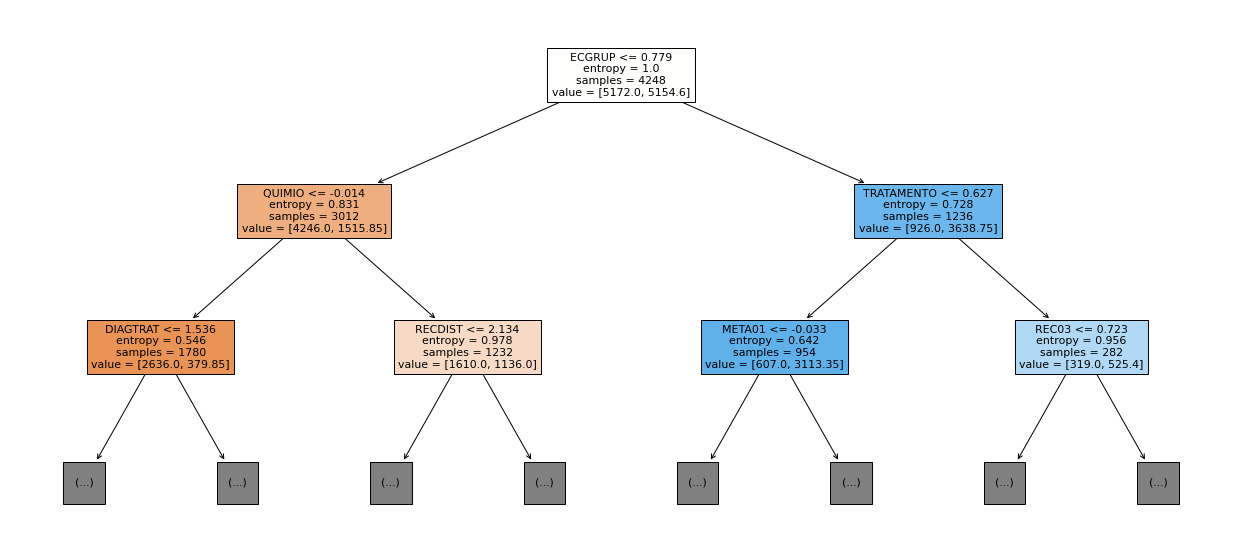

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

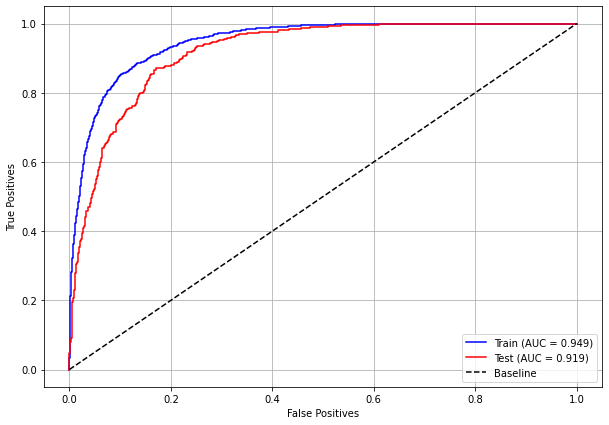

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

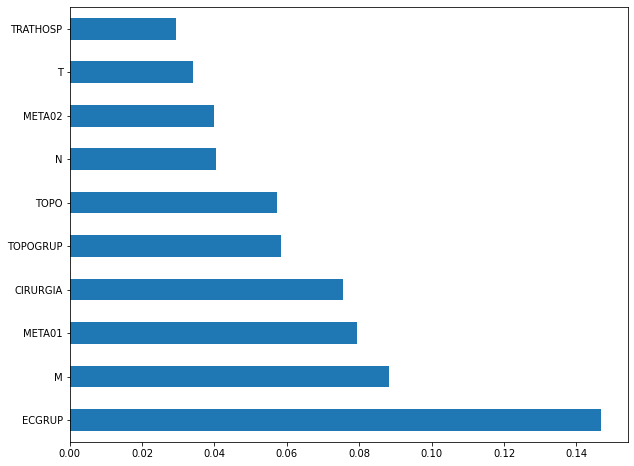

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `CIRURGIA`.

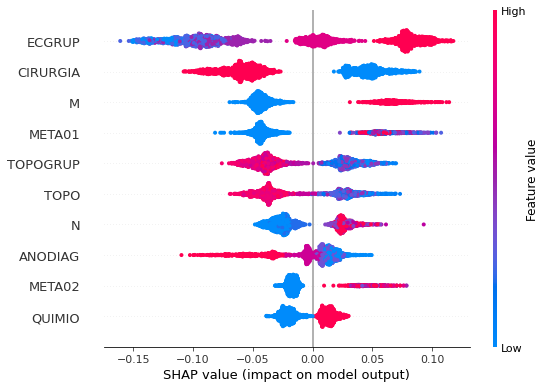

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=1.25)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.25)

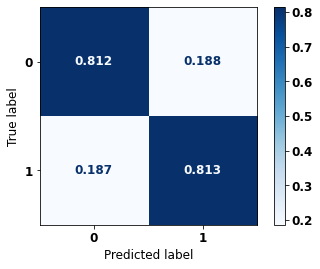


              precision    recall  f1-score   support

           0       0.84      0.81      0.83      9240
           1       0.78      0.81      0.79      7385

    accuracy                           0.81     16625
   macro avg       0.81      0.81      0.81     16625
weighted avg       0.81      0.81      0.81     16625



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

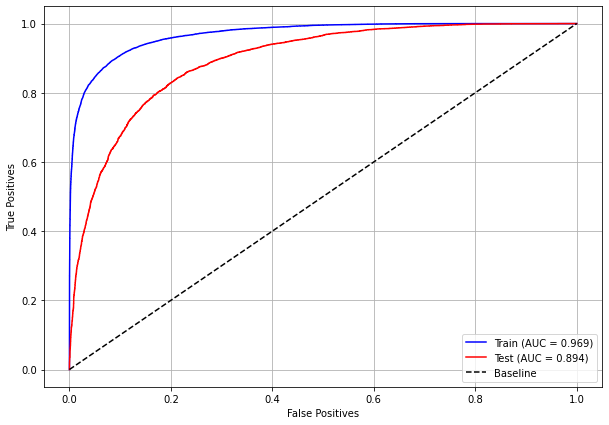

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

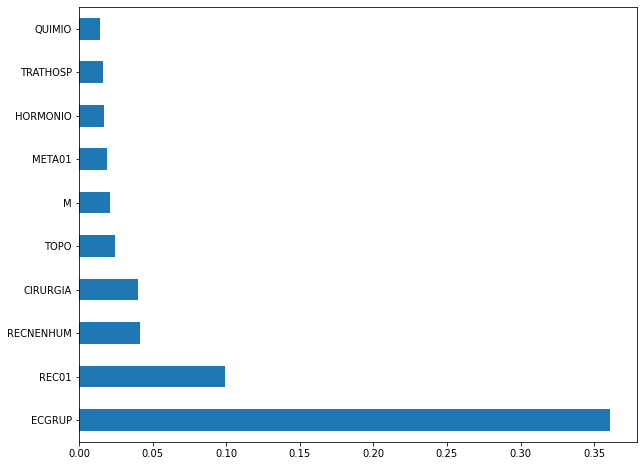

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `REC01`, `RECNENHUM` and `CIRURGIA`.

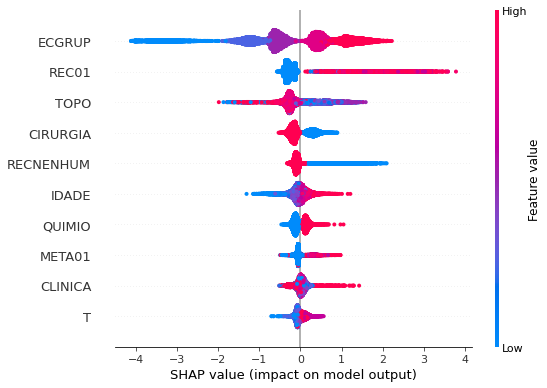

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=1.55)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.55)

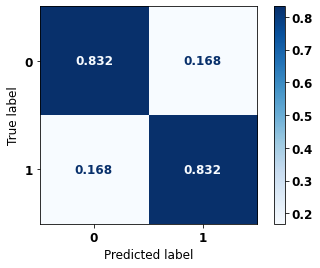


              precision    recall  f1-score   support

           0       0.88      0.83      0.85     12254
           1       0.78      0.83      0.80      8633

    accuracy                           0.83     20887
   macro avg       0.83      0.83      0.83     20887
weighted avg       0.84      0.83      0.83     20887



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 83% of accuracy.


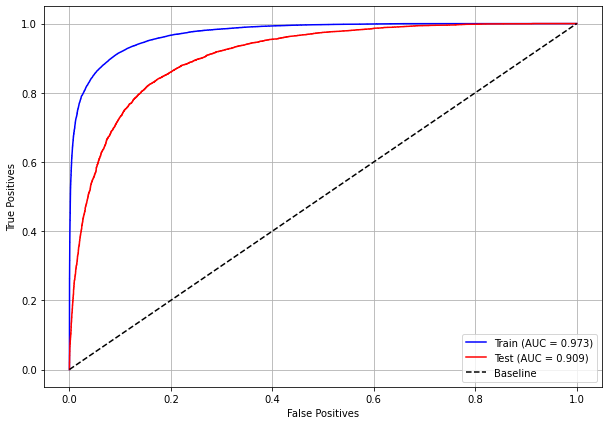

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

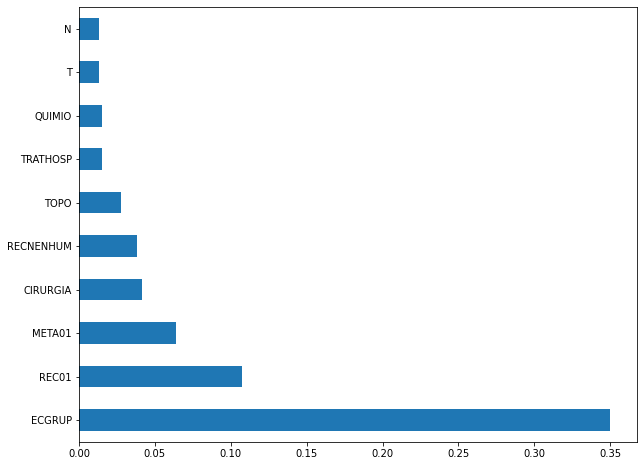

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `META01` and `CIRURGIA`. 

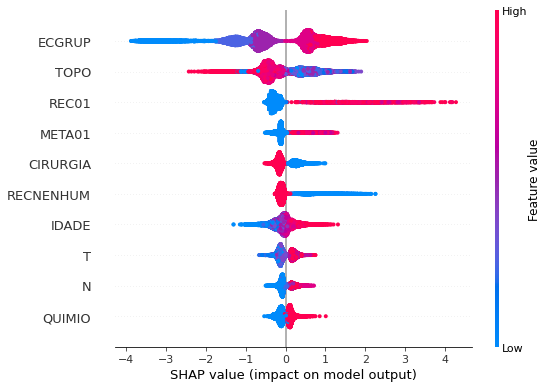

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1.85,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.85)

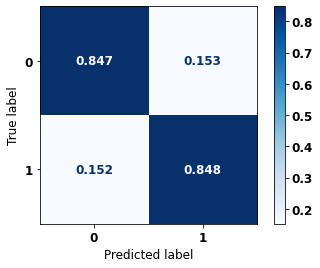


              precision    recall  f1-score   support

           0       0.91      0.85      0.88     17545
           1       0.76      0.85      0.80     10198

    accuracy                           0.85     27743
   macro avg       0.83      0.85      0.84     27743
weighted avg       0.85      0.85      0.85     27743



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 85% of accuracy.

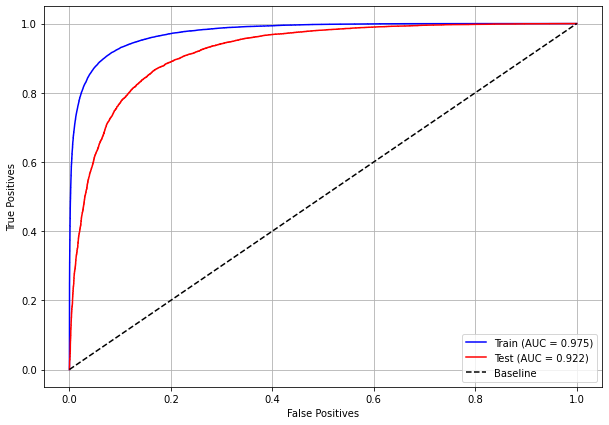

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

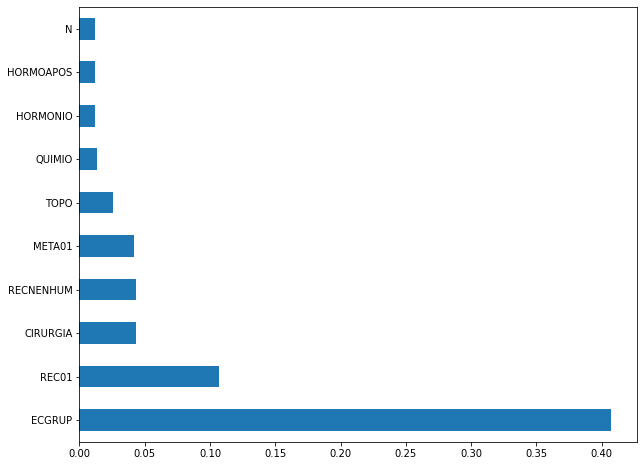

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `CIRURGIA` and `RECNENHUM`. 

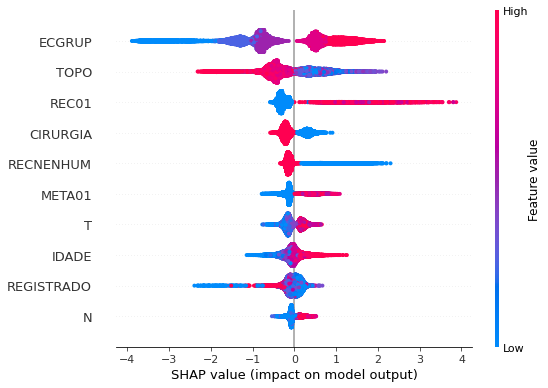

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed,
                                 scale_pos_weight=2.55)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=2.55)

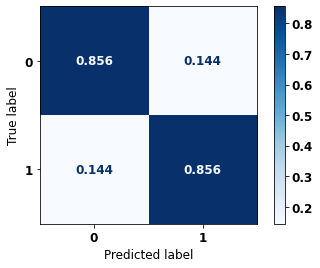


              precision    recall  f1-score   support

           0       0.93      0.86      0.89     24288
           1       0.72      0.86      0.78     10342

    accuracy                           0.86     34630
   macro avg       0.82      0.86      0.84     34630
weighted avg       0.87      0.86      0.86     34630



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 86% of accuracy.

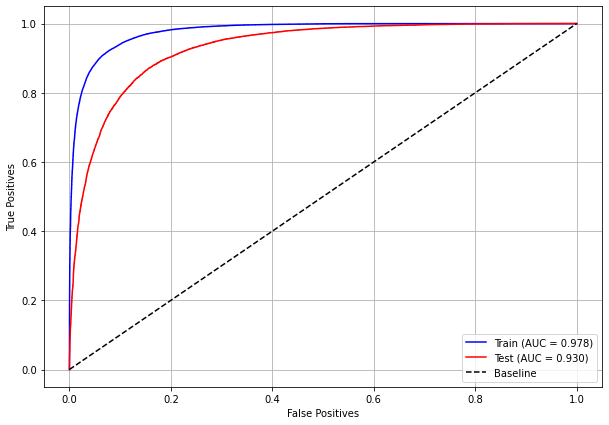

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

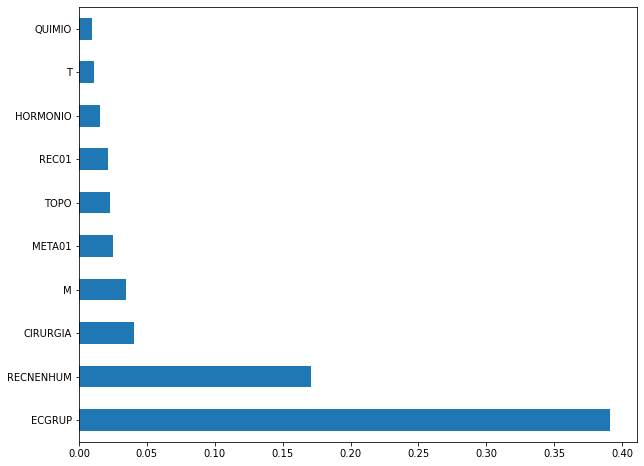

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `RECNENHUM`, `CIRURGIA` and `M`. 

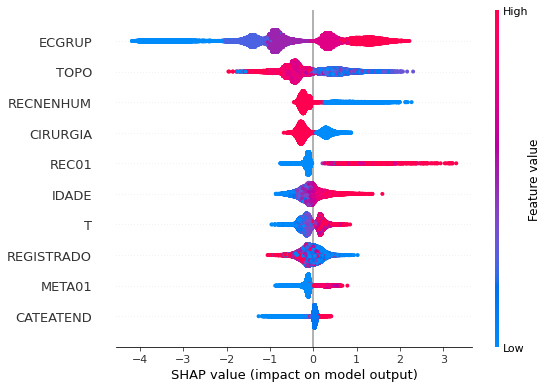

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=4.9)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=4.9)

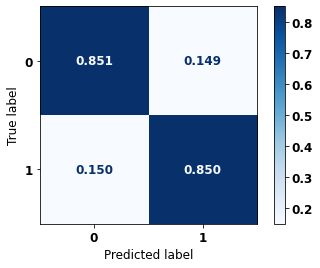


              precision    recall  f1-score   support

           0       0.95      0.85      0.90     20945
           1       0.61      0.85      0.71      5681

    accuracy                           0.85     26626
   macro avg       0.78      0.85      0.80     26626
weighted avg       0.88      0.85      0.86     26626



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.


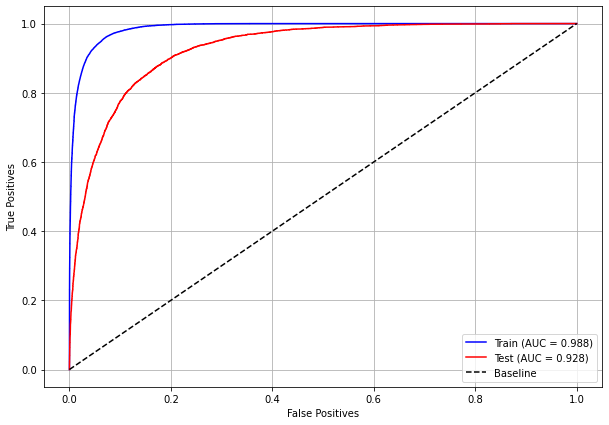

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

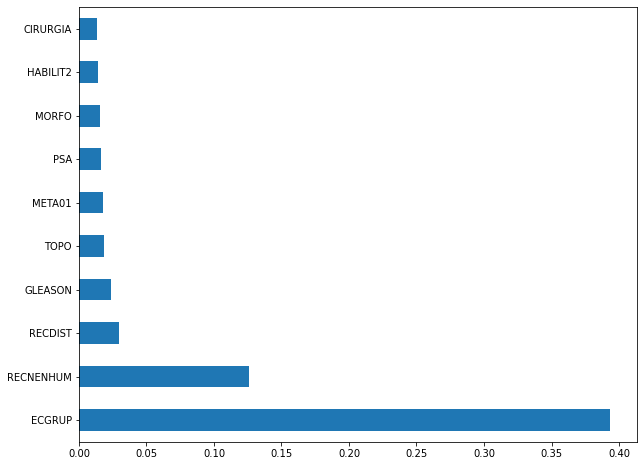

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECNENHUM`, `RECDIST` and `GLEASON`.

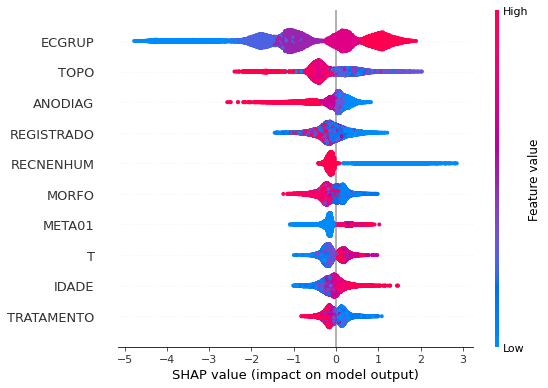

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.885,
                                   random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.885)

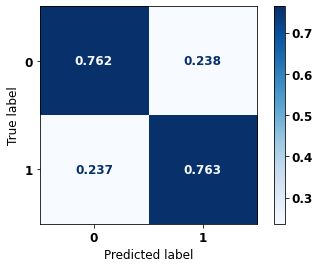


              precision    recall  f1-score   support

           0       0.83      0.76      0.79       563
           1       0.68      0.76      0.72       372

    accuracy                           0.76       935
   macro avg       0.75      0.76      0.76       935
weighted avg       0.77      0.76      0.76       935



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 76% of accuracy.

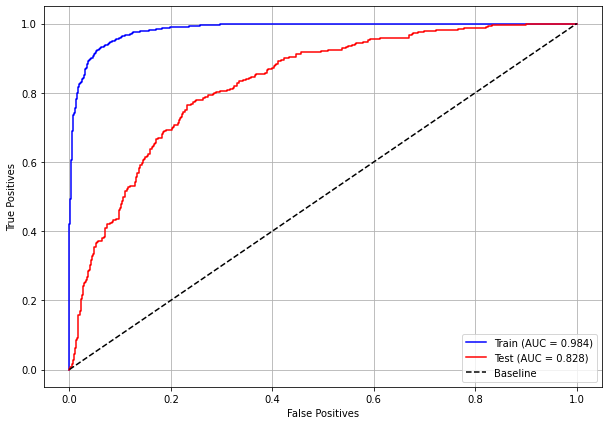

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

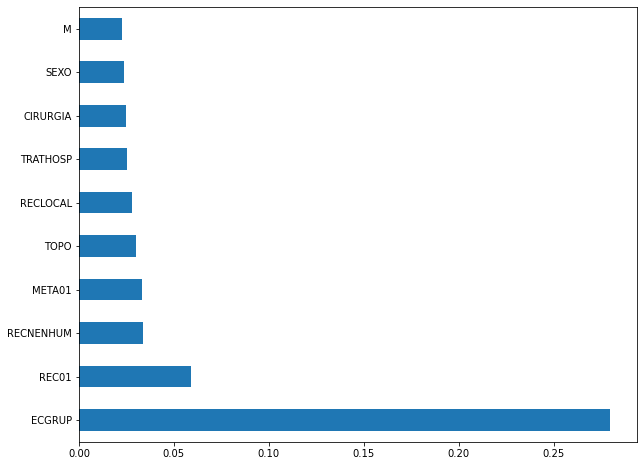

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `RECNENHUM` and `META01`.

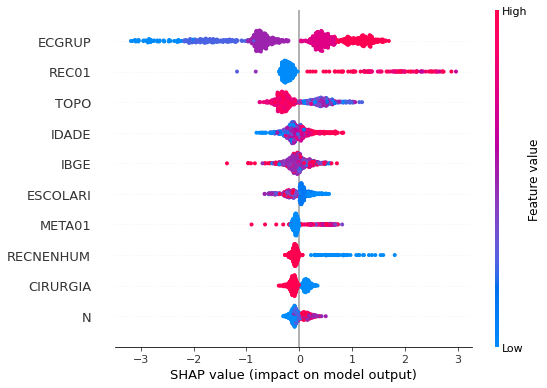

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.86,
                                   random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.86)

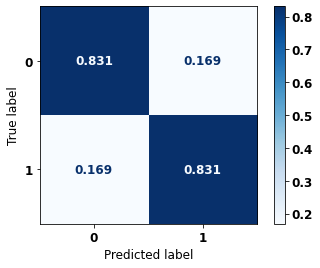


              precision    recall  f1-score   support

           0       0.89      0.83      0.86       818
           1       0.75      0.83      0.79       497

    accuracy                           0.83      1315
   macro avg       0.82      0.83      0.82      1315
weighted avg       0.84      0.83      0.83      1315



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 83% of accuracy.

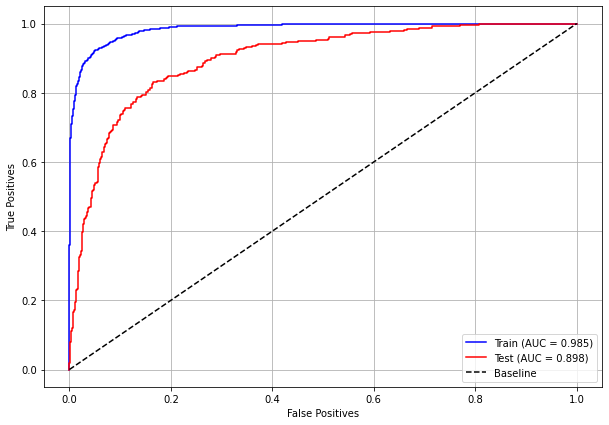

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

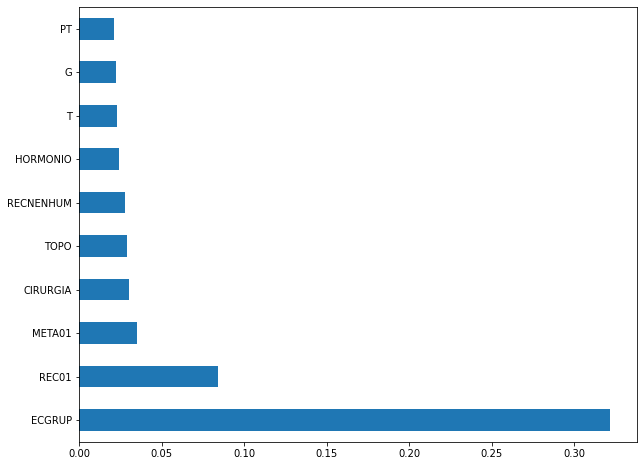

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `META01` and `CIRURGIA`.

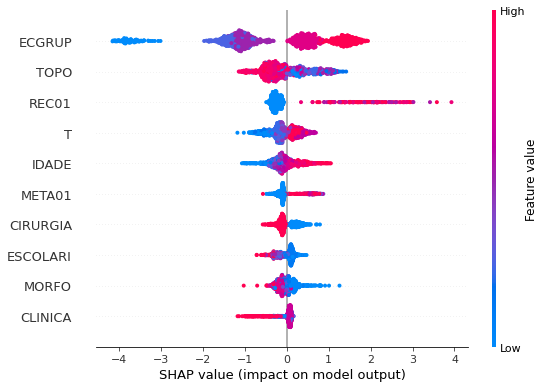

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=2.5,
                                   random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2.5)

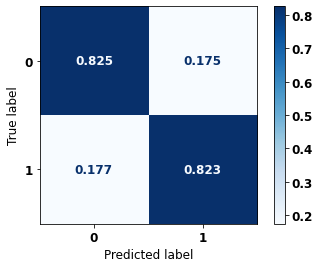


              precision    recall  f1-score   support

           0       0.90      0.83      0.86      1054
           1       0.71      0.82      0.77       560

    accuracy                           0.82      1614
   macro avg       0.81      0.82      0.81      1614
weighted avg       0.83      0.82      0.83      1614



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 82% of accuracy.

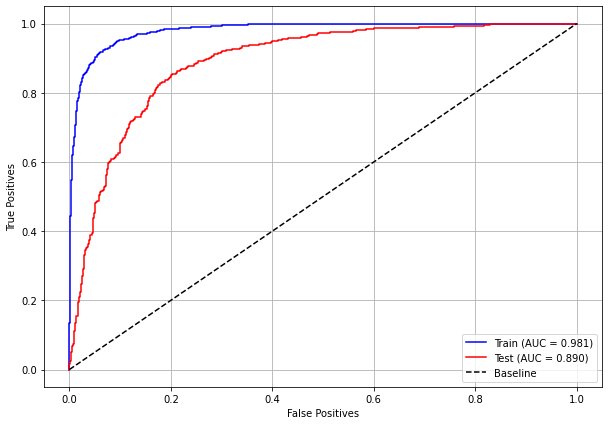

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

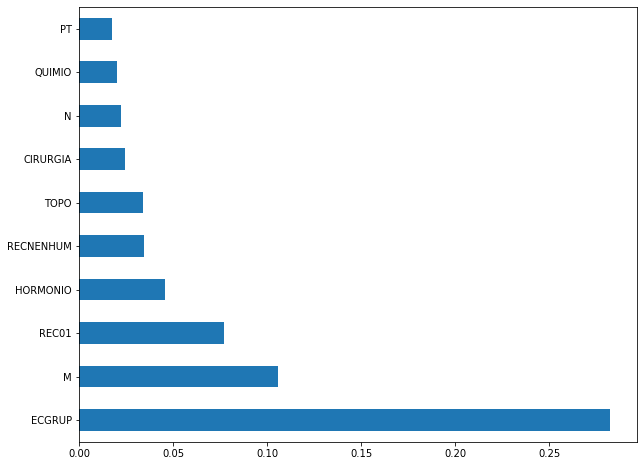

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `REC01` and `HORMONIO`.

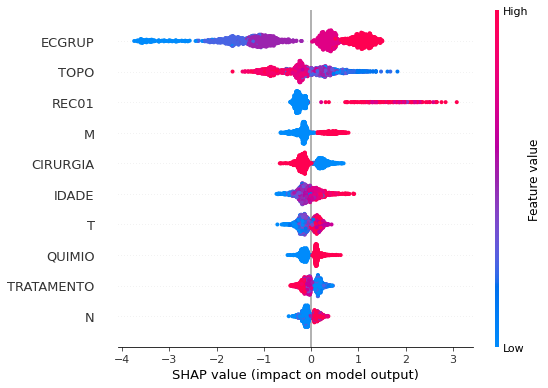

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=3.41,
                                   random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=3.41)

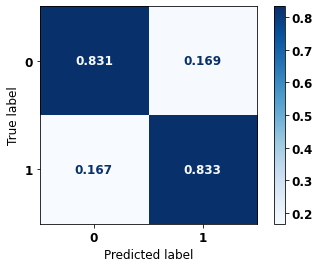


              precision    recall  f1-score   support

           0       0.93      0.83      0.88      1565
           1       0.65      0.83      0.73       588

    accuracy                           0.83      2153
   macro avg       0.79      0.83      0.80      2153
weighted avg       0.85      0.83      0.84      2153



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

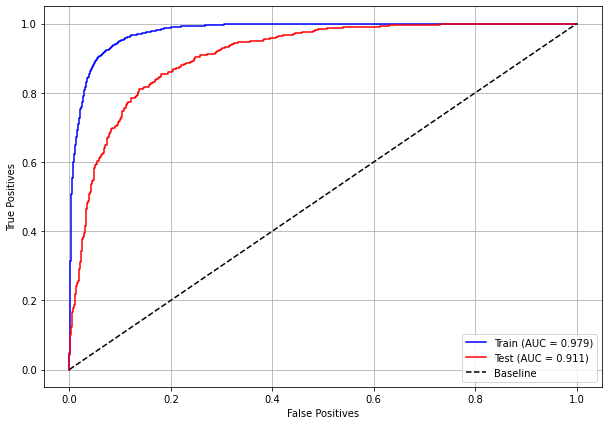

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

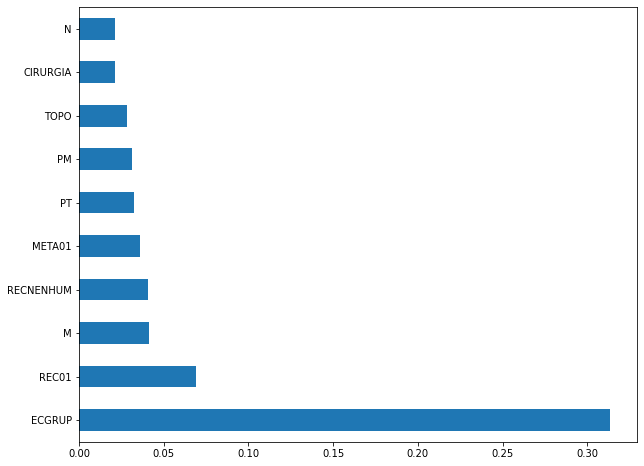

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `REC01`, `M` and `RECNENHUM`.

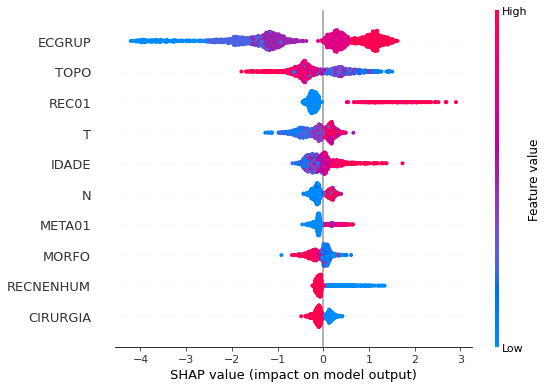

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=4.5,
                                   random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=4.5)

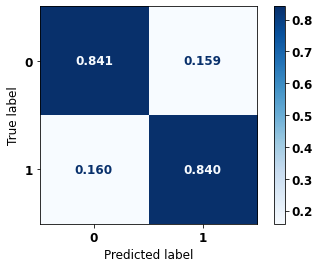


              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1690
           1       0.62      0.84      0.71       518

    accuracy                           0.84      2208
   macro avg       0.78      0.84      0.80      2208
weighted avg       0.87      0.84      0.85      2208



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states data from 2016 to 2020, shows the best performance comparing with the other models, with 84% of accuracy.

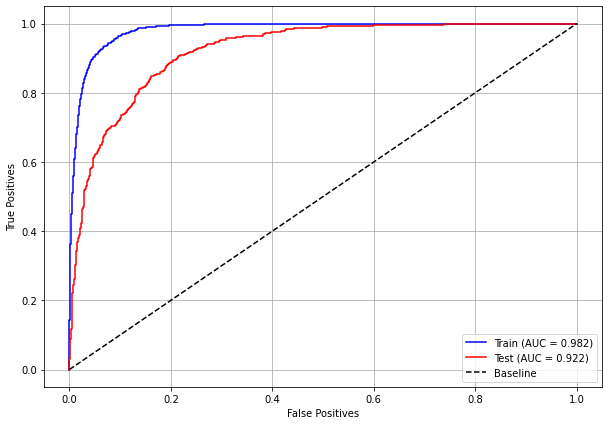

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

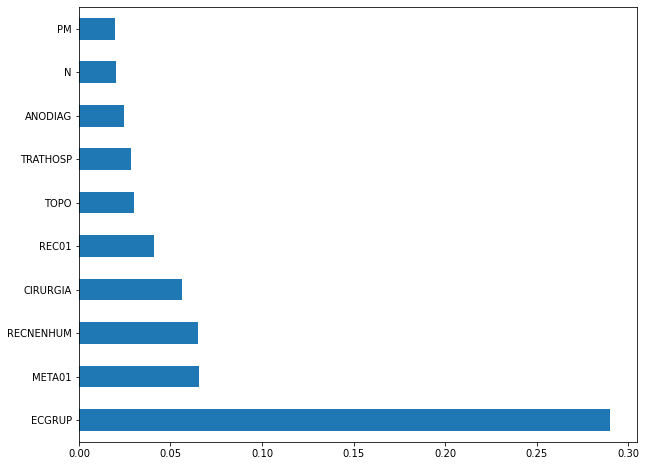

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `META01`, `RECNENHUM` and `CIRURGIA`.

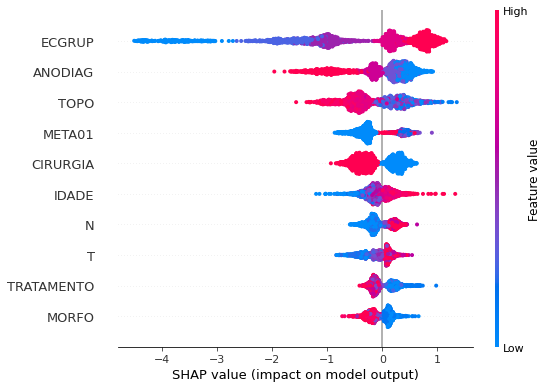

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

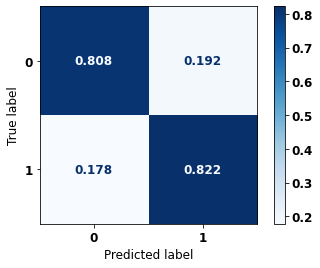


              precision    recall  f1-score   support

           0       0.87      0.81      0.84     12254
           1       0.75      0.82      0.79      8633

    accuracy                           0.81     20887
   macro avg       0.81      0.82      0.81     20887
weighted avg       0.82      0.81      0.82     20887



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

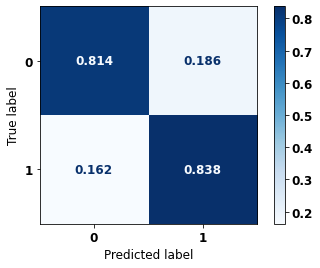


              precision    recall  f1-score   support

           0       0.90      0.81      0.85     17545
           1       0.72      0.84      0.78     10198

    accuracy                           0.82     27743
   macro avg       0.81      0.83      0.81     27743
weighted avg       0.83      0.82      0.82     27743



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

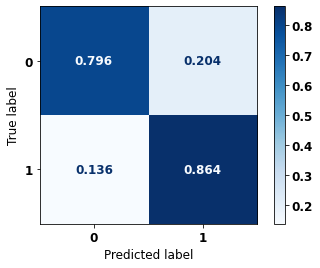


              precision    recall  f1-score   support

           0       0.93      0.80      0.86     24288
           1       0.64      0.86      0.74     10342

    accuracy                           0.82     34630
   macro avg       0.79      0.83      0.80     34630
weighted avg       0.85      0.82      0.82     34630



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

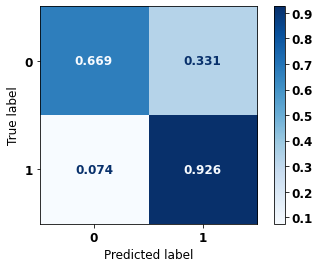


              precision    recall  f1-score   support

           0       0.97      0.67      0.79     20945
           1       0.43      0.93      0.59      5681

    accuracy                           0.72     26626
   macro avg       0.70      0.80      0.69     26626
weighted avg       0.86      0.72      0.75     26626



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

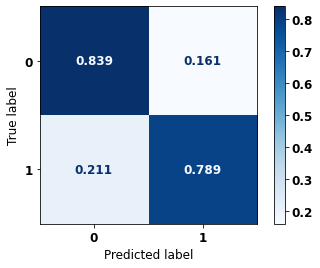


              precision    recall  f1-score   support

           0       0.85      0.84      0.84     12254
           1       0.78      0.79      0.78      8633

    accuracy                           0.82     20887
   macro avg       0.81      0.81      0.81     20887
weighted avg       0.82      0.82      0.82     20887



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

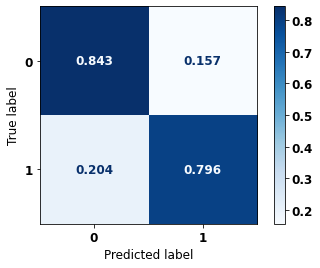


              precision    recall  f1-score   support

           0       0.88      0.84      0.86     17545
           1       0.75      0.80      0.77     10198

    accuracy                           0.83     27743
   macro avg       0.81      0.82      0.82     27743
weighted avg       0.83      0.83      0.83     27743



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

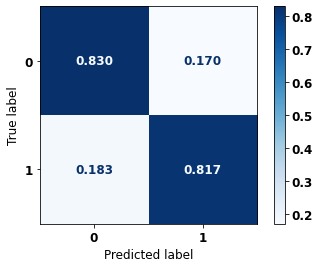


              precision    recall  f1-score   support

           0       0.91      0.83      0.87     24288
           1       0.67      0.82      0.74     10342

    accuracy                           0.83     34630
   macro avg       0.79      0.82      0.80     34630
weighted avg       0.84      0.83      0.83     34630



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

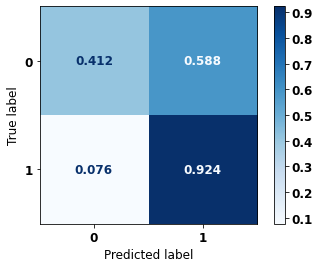


              precision    recall  f1-score   support

           0       0.95      0.41      0.58     20945
           1       0.30      0.92      0.45      5681

    accuracy                           0.52     26626
   macro avg       0.63      0.67      0.51     26626
weighted avg       0.81      0.52      0.55     26626



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

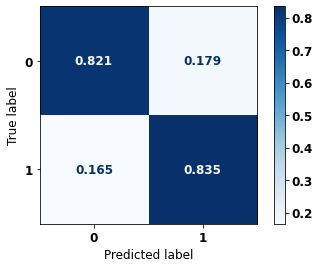


              precision    recall  f1-score   support

           0       0.90      0.82      0.86     17545
           1       0.73      0.83      0.78     10198

    accuracy                           0.83     27743
   macro avg       0.81      0.83      0.82     27743
weighted avg       0.83      0.83      0.83     27743



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

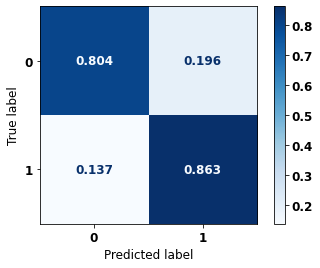


              precision    recall  f1-score   support

           0       0.93      0.80      0.86     24288
           1       0.65      0.86      0.74     10342

    accuracy                           0.82     34630
   macro avg       0.79      0.83      0.80     34630
weighted avg       0.85      0.82      0.83     34630



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

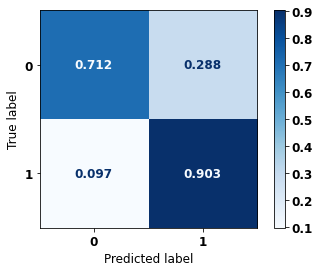


              precision    recall  f1-score   support

           0       0.96      0.71      0.82     20945
           1       0.46      0.90      0.61      5681

    accuracy                           0.75     26626
   macro avg       0.71      0.81      0.71     26626
weighted avg       0.86      0.75      0.77     26626



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

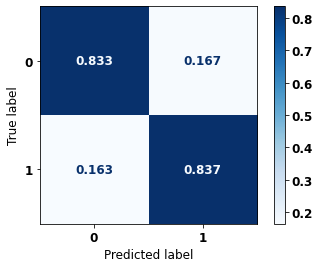


              precision    recall  f1-score   support

           0       0.90      0.83      0.86     17545
           1       0.74      0.84      0.79     10198

    accuracy                           0.83     27743
   macro avg       0.82      0.83      0.83     27743
weighted avg       0.84      0.83      0.84     27743



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

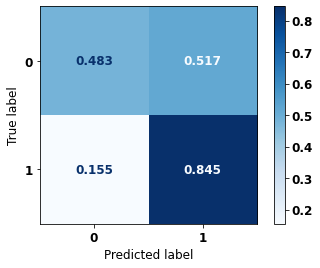


              precision    recall  f1-score   support

           0       0.88      0.48      0.62     24288
           1       0.41      0.85      0.55     10342

    accuracy                           0.59     34630
   macro avg       0.65      0.66      0.59     34630
weighted avg       0.74      0.59      0.60     34630



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

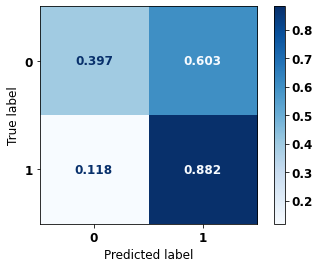


              precision    recall  f1-score   support

           0       0.93      0.40      0.56     20945
           1       0.28      0.88      0.43      5681

    accuracy                           0.50     26626
   macro avg       0.60      0.64      0.49     26626
weighted avg       0.79      0.50      0.53     26626



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

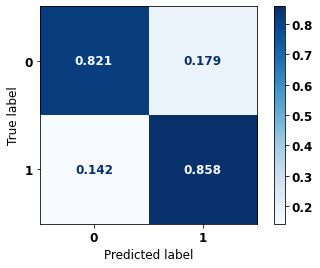


              precision    recall  f1-score   support

           0       0.93      0.82      0.87     24288
           1       0.67      0.86      0.75     10342

    accuracy                           0.83     34630
   macro avg       0.80      0.84      0.81     34630
weighted avg       0.85      0.83      0.84     34630



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

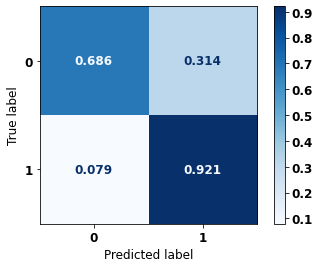


              precision    recall  f1-score   support

           0       0.97      0.69      0.80     20945
           1       0.44      0.92      0.60      5681

    accuracy                           0.74     26626
   macro avg       0.71      0.80      0.70     26626
weighted avg       0.86      0.74      0.76     26626



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

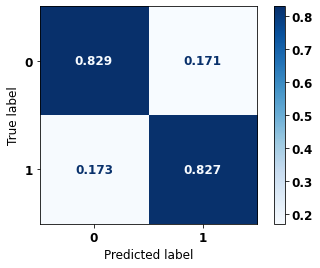


              precision    recall  f1-score   support

           0       0.92      0.83      0.87     24288
           1       0.67      0.83      0.74     10342

    accuracy                           0.83     34630
   macro avg       0.80      0.83      0.81     34630
weighted avg       0.85      0.83      0.83     34630



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

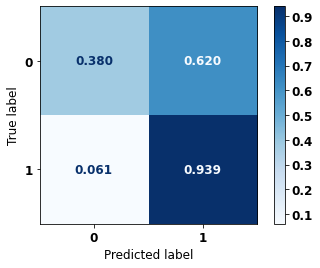


              precision    recall  f1-score   support

           0       0.96      0.38      0.54     20945
           1       0.29      0.94      0.44      5681

    accuracy                           0.50     26626
   macro avg       0.62      0.66      0.49     26626
weighted avg       0.82      0.50      0.52     26626



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

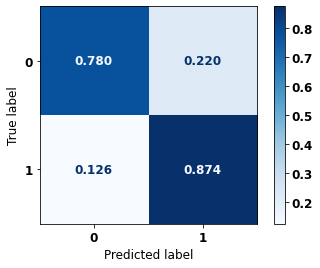


              precision    recall  f1-score   support

           0       0.96      0.78      0.86     20945
           1       0.52      0.87      0.65      5681

    accuracy                           0.80     26626
   macro avg       0.74      0.83      0.76     26626
weighted avg       0.86      0.80      0.82     26626



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

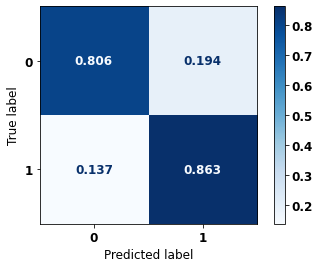


              precision    recall  f1-score   support

           0       0.96      0.81      0.87     20945
           1       0.55      0.86      0.67      5681

    accuracy                           0.82     26626
   macro avg       0.75      0.83      0.77     26626
weighted avg       0.87      0.82      0.83     26626



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

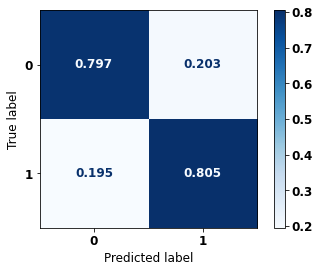


              precision    recall  f1-score   support

           0       0.87      0.80      0.83       818
           1       0.71      0.80      0.75       497

    accuracy                           0.80      1315
   macro avg       0.79      0.80      0.79      1315
weighted avg       0.81      0.80      0.80      1315



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

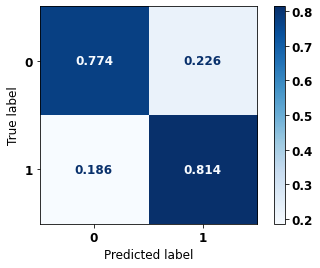


              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1054
           1       0.66      0.81      0.73       560

    accuracy                           0.79      1614
   macro avg       0.77      0.79      0.78      1614
weighted avg       0.81      0.79      0.79      1614



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

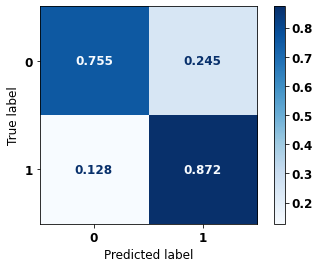


              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1565
           1       0.57      0.87      0.69       588

    accuracy                           0.79      2153
   macro avg       0.76      0.81      0.76      2153
weighted avg       0.84      0.79      0.80      2153



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

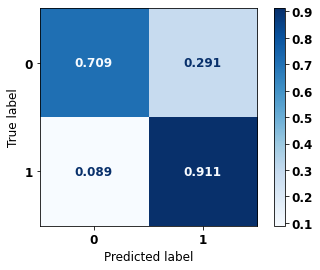


              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1690
           1       0.49      0.91      0.64       518

    accuracy                           0.76      2208
   macro avg       0.73      0.81      0.73      2208
weighted avg       0.85      0.76      0.77      2208



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

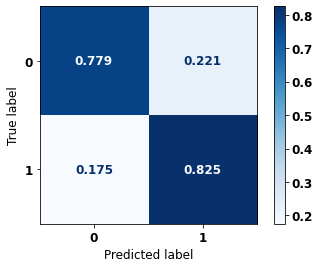


              precision    recall  f1-score   support

           0       0.88      0.78      0.83       818
           1       0.69      0.82      0.75       497

    accuracy                           0.80      1315
   macro avg       0.79      0.80      0.79      1315
weighted avg       0.81      0.80      0.80      1315



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

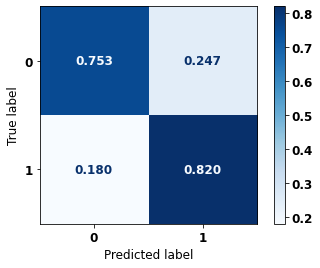


              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1054
           1       0.64      0.82      0.72       560

    accuracy                           0.78      1614
   macro avg       0.76      0.79      0.77      1614
weighted avg       0.80      0.78      0.78      1614



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

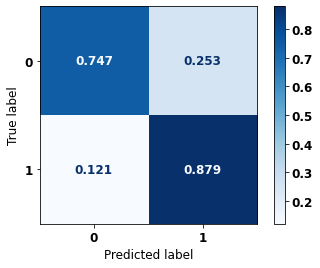


              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1565
           1       0.57      0.88      0.69       588

    accuracy                           0.78      2153
   macro avg       0.75      0.81      0.76      2153
weighted avg       0.84      0.78      0.79      2153



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

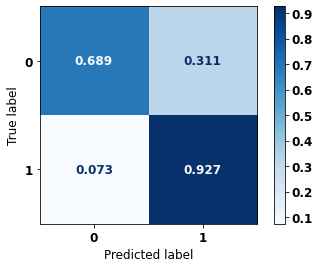


              precision    recall  f1-score   support

           0       0.97      0.69      0.81      1690
           1       0.48      0.93      0.63       518

    accuracy                           0.75      2208
   macro avg       0.72      0.81      0.72      2208
weighted avg       0.85      0.75      0.76      2208



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

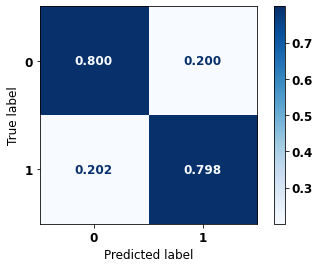


              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1054
           1       0.68      0.80      0.73       560

    accuracy                           0.80      1614
   macro avg       0.78      0.80      0.79      1614
weighted avg       0.81      0.80      0.80      1614



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

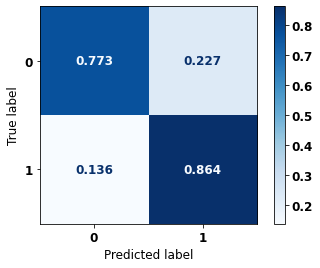


              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1565
           1       0.59      0.86      0.70       588

    accuracy                           0.80      2153
   macro avg       0.76      0.82      0.77      2153
weighted avg       0.84      0.80      0.81      2153



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

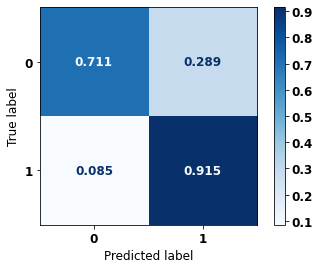


              precision    recall  f1-score   support

           0       0.96      0.71      0.82      1690
           1       0.49      0.92      0.64       518

    accuracy                           0.76      2208
   macro avg       0.73      0.81      0.73      2208
weighted avg       0.85      0.76      0.78      2208



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

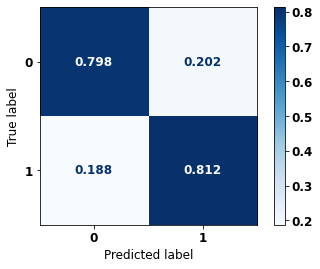


              precision    recall  f1-score   support

           0       0.89      0.80      0.84      1054
           1       0.68      0.81      0.74       560

    accuracy                           0.80      1614
   macro avg       0.79      0.81      0.79      1614
weighted avg       0.82      0.80      0.81      1614



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

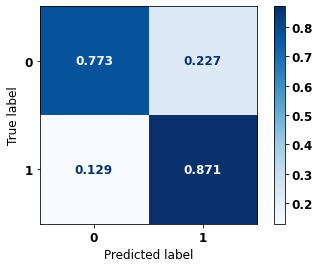


              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1565
           1       0.59      0.87      0.70       588

    accuracy                           0.80      2153
   macro avg       0.77      0.82      0.78      2153
weighted avg       0.85      0.80      0.81      2153



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

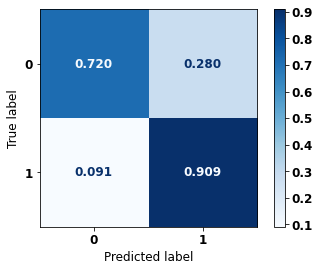


              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1690
           1       0.50      0.91      0.64       518

    accuracy                           0.76      2208
   macro avg       0.73      0.81      0.73      2208
weighted avg       0.85      0.76      0.78      2208



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

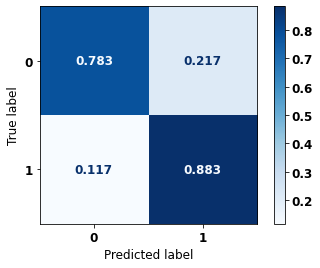


              precision    recall  f1-score   support

           0       0.95      0.78      0.86      1565
           1       0.60      0.88      0.72       588

    accuracy                           0.81      2153
   macro avg       0.78      0.83      0.79      2153
weighted avg       0.85      0.81      0.82      2153



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

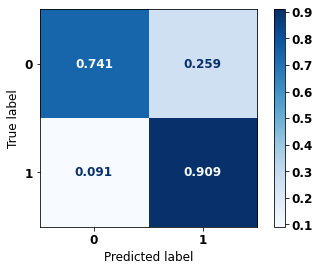


              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1690
           1       0.52      0.91      0.66       518

    accuracy                           0.78      2208
   macro avg       0.74      0.83      0.75      2208
weighted avg       0.86      0.78      0.80      2208



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

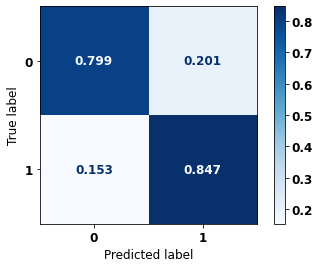


              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1565
           1       0.61      0.85      0.71       588

    accuracy                           0.81      2153
   macro avg       0.77      0.82      0.79      2153
weighted avg       0.85      0.81      0.82      2153



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

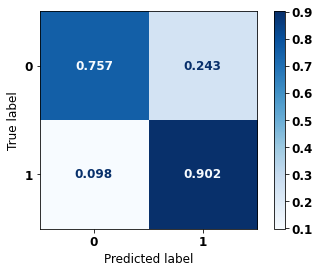


              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1690
           1       0.53      0.90      0.67       518

    accuracy                           0.79      2208
   macro avg       0.75      0.83      0.76      2208
weighted avg       0.86      0.79      0.81      2208



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

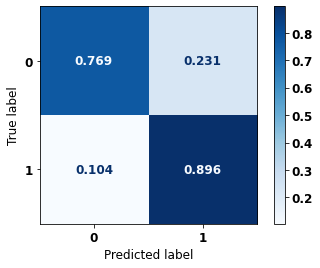


              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1690
           1       0.54      0.90      0.68       518

    accuracy                           0.80      2208
   macro avg       0.75      0.83      0.77      2208
weighted avg       0.86      0.80      0.81      2208



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

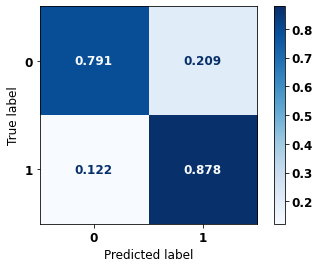


              precision    recall  f1-score   support

           0       0.95      0.79      0.87      1690
           1       0.56      0.88      0.69       518

    accuracy                           0.81      2208
   macro avg       0.76      0.83      0.78      2208
weighted avg       0.86      0.81      0.82      2208



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)

# **Fourth approach**

Approach with grouped years, using only morphologies with final digit equal to 3 and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the data: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'vivo_ano1', 'vivo_ano3', 'vivo_ano5', 'ULTINFO', 'EC', 'obito_geral']

lb = 'obito_cancer'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2000, 
                                                                                                last_year=2003, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (46098, 65), X_test = (15367, 65)
y_train = (46098,), y_test = (15367,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (58169, 65), X_test = (19390, 65)
y_train = (58169,), y_test = (19390,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (77412, 65), X_test = (25804, 65)
y_train = (77412,), y_test = (25804,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (96124, 65), X_test = (32042, 65)
y_train = (96124,), y_test = (32042,)


In [ ]:
X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21, feat_SP_16_21 = preprocessing(df_SP, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2021, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73682, 65), X_test = (24561, 65)
y_train = (73682,), y_test = (24561,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2000,
                                                                                                last_year=2003, morpho3=True, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2592, 65), X_test = (865, 65)
y_train = (2592,), y_test = (865,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2004, 
                                                                                                last_year=2007, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3694, 65), X_test = (1232, 65)
y_train = (3694,), y_test = (1232,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2008, 
                                                                                                last_year=2011, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (4536, 65), X_test = (1513, 65)
y_train = (4536,), y_test = (1513,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2012, 
                                                                                                last_year=2015, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6069, 65), X_test = (2024, 65)
y_train = (6069,), y_test = (2024,)


In [ ]:
X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20, feat_OS_16_20 = preprocessing(df_fora, list_drop, lb, 
                                                                                                group_years=True, first_year=2016, 
                                                                                                last_year=2020, morpho3=True,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (6185, 65), X_test = (2062, 65)
y_train = (6185,), y_test = (2062,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.06},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.06}, criterion='entropy',
                       max_depth=10, random_state=10)

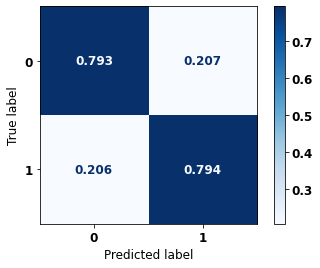


              precision    recall  f1-score   support

           0       0.81      0.79      0.80      8010
           1       0.78      0.79      0.79      7357

    accuracy                           0.79     15367
   macro avg       0.79      0.79      0.79     15367
weighted avg       0.79      0.79      0.79     15367



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


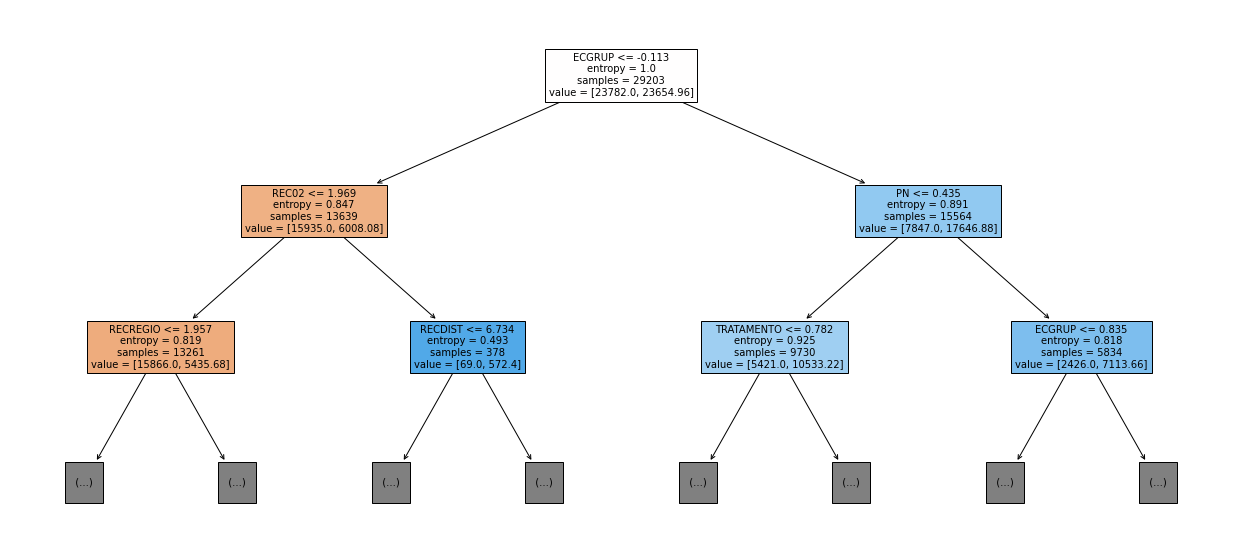

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

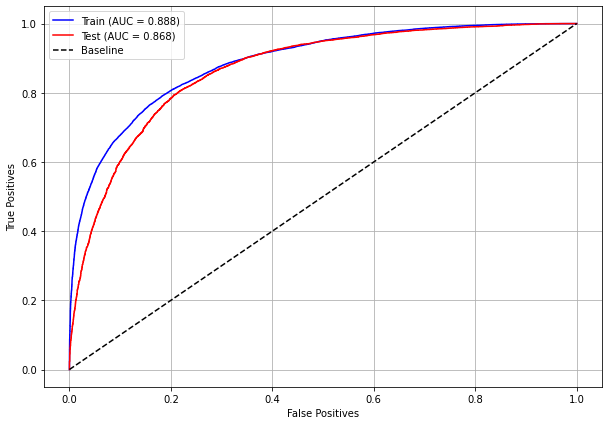

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

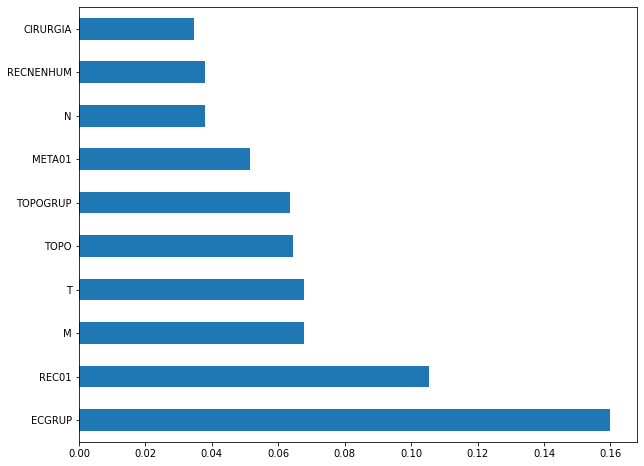

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `REC01`, `M`, and `T`.

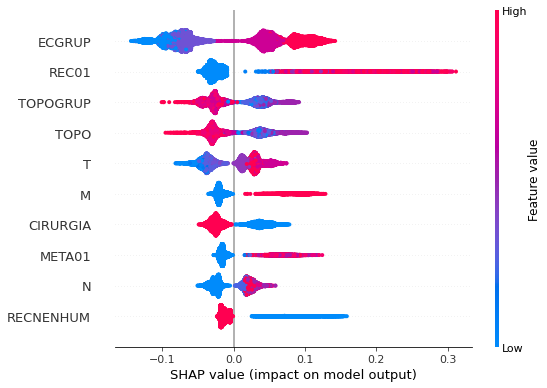

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.28},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.28}, criterion='entropy',
                       max_depth=10, random_state=10)

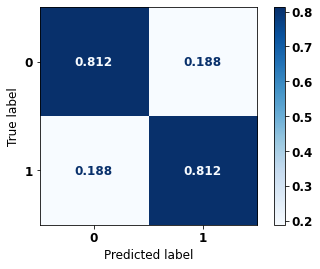


              precision    recall  f1-score   support

           0       0.85      0.81      0.83     10867
           1       0.77      0.81      0.79      8523

    accuracy                           0.81     19390
   macro avg       0.81      0.81      0.81     19390
weighted avg       0.81      0.81      0.81     19390



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.

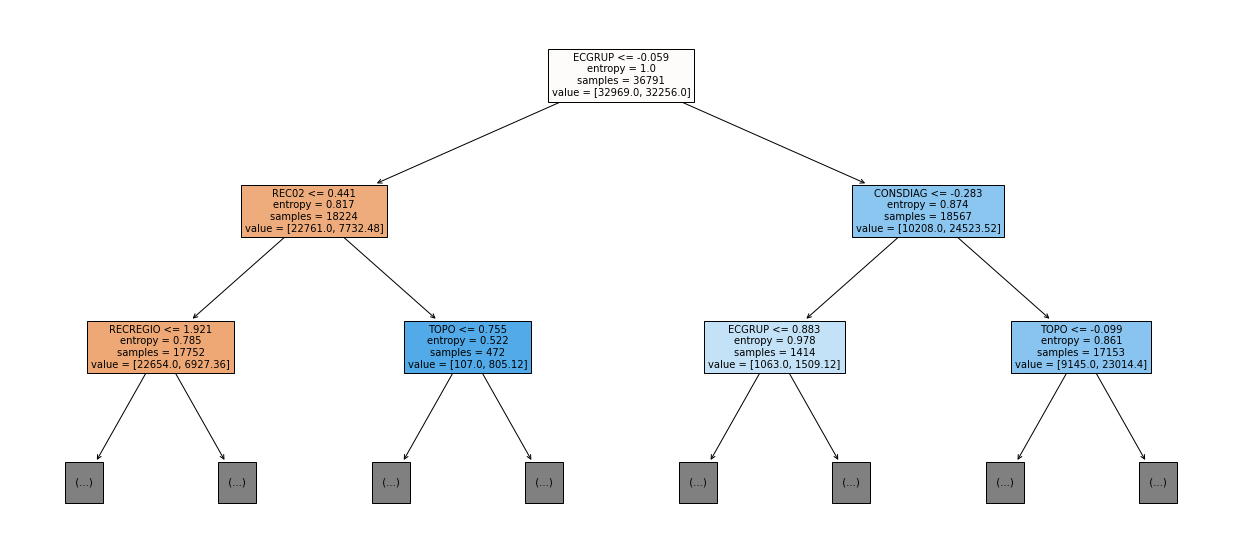

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

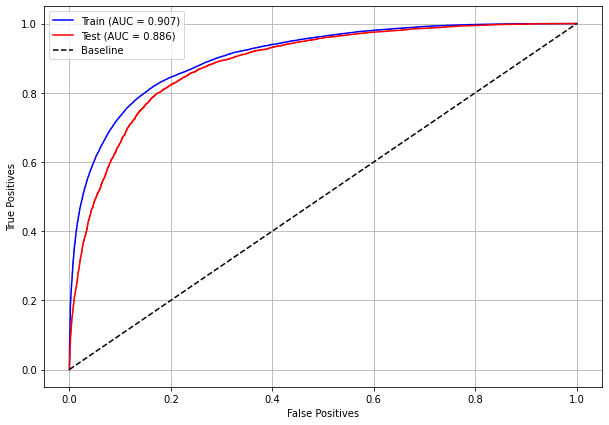

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

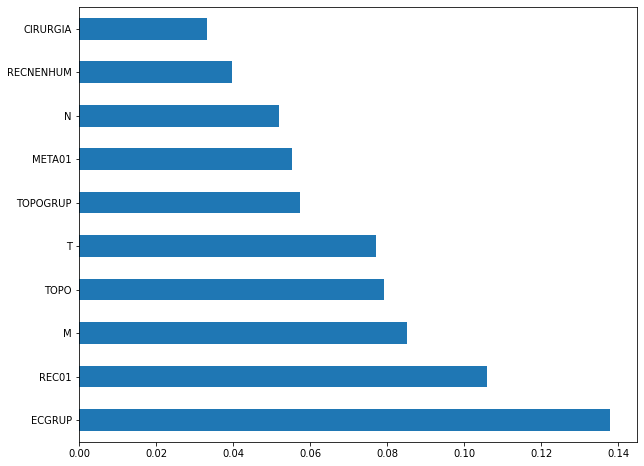

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `TOPO`.

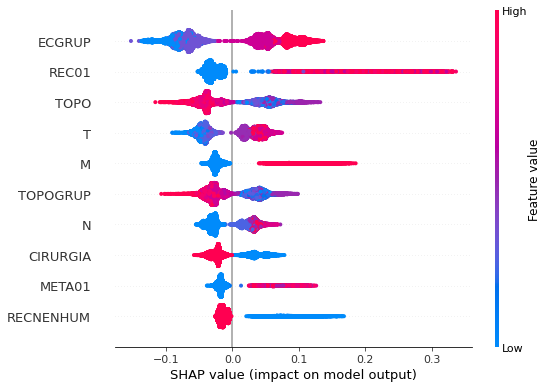

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.475},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.475}, criterion='entropy',
                       max_depth=10, random_state=10)

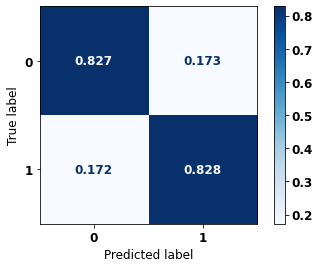


              precision    recall  f1-score   support

           0       0.88      0.83      0.85     15787
           1       0.75      0.83      0.79     10017

    accuracy                           0.83     25804
   macro avg       0.82      0.83      0.82     25804
weighted avg       0.83      0.83      0.83     25804



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 83% of accuray.

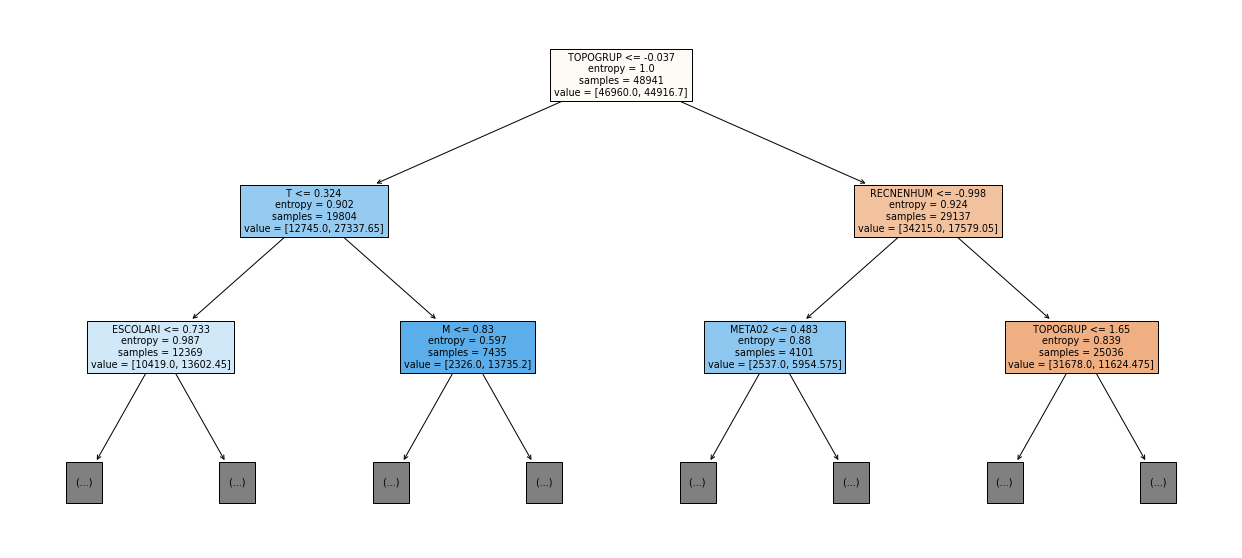

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

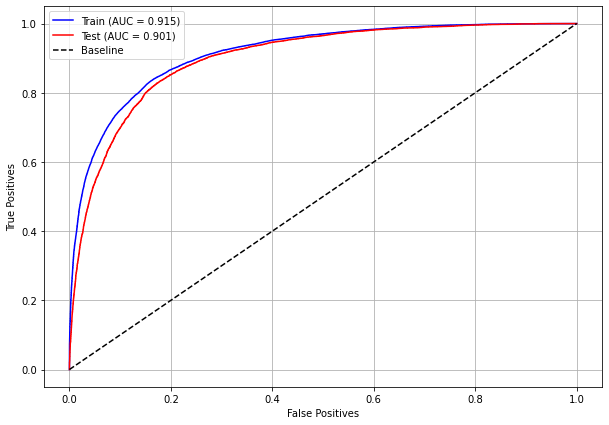

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

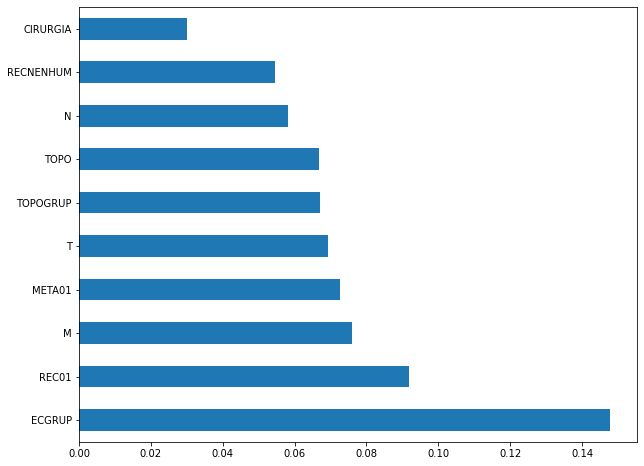

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `REC01`, `M` and `META01`.

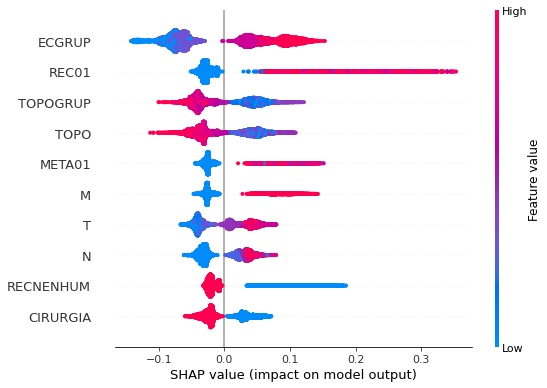

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.035},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.035}, criterion='entropy',
                       max_depth=10, random_state=10)

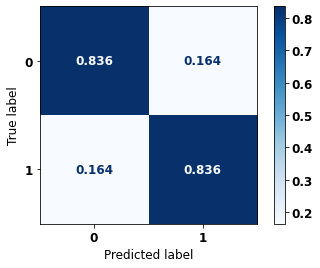


              precision    recall  f1-score   support

           0       0.92      0.84      0.87     21958
           1       0.70      0.84      0.76     10084

    accuracy                           0.84     32042
   macro avg       0.81      0.84      0.82     32042
weighted avg       0.85      0.84      0.84     32042



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 84% of accuracy.

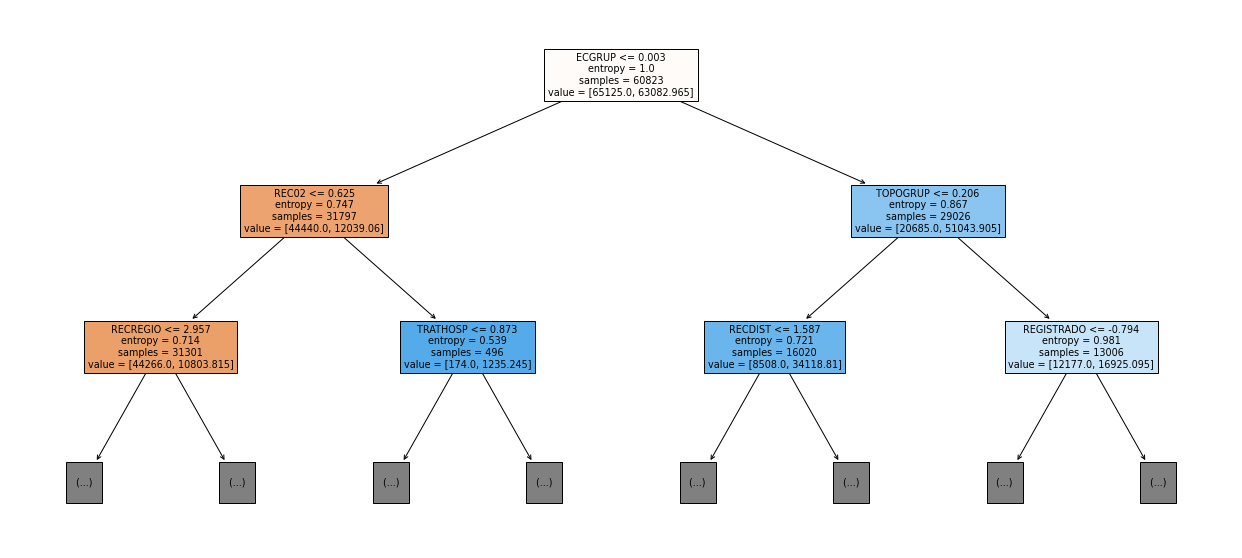

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

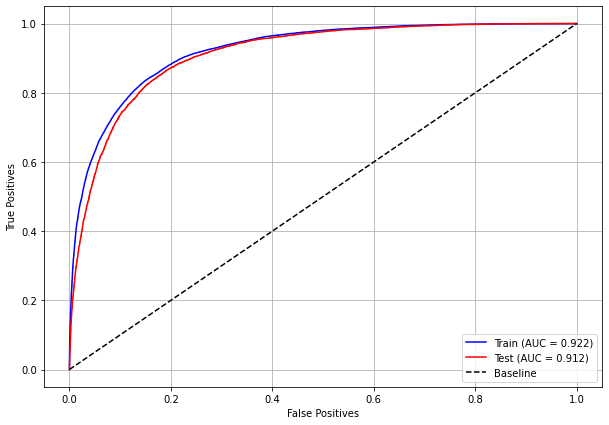

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

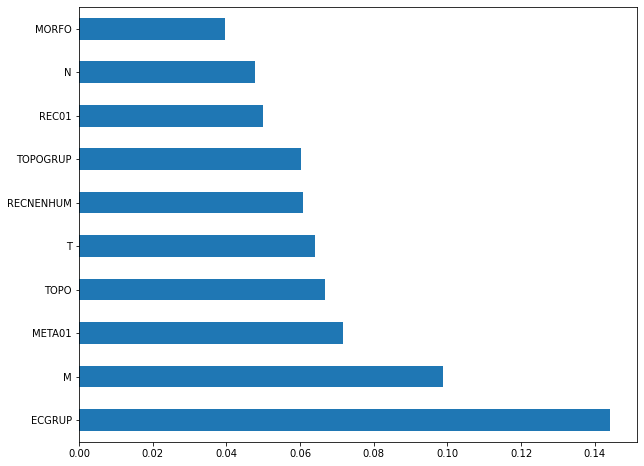

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `TOPO`.

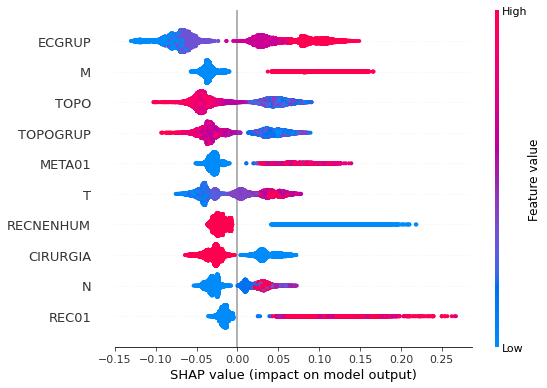

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
rf_sp_16_21 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:2.95},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

RandomForestClassifier(class_weight={0: 1, 1: 2.95}, criterion='entropy',
                       max_depth=10, random_state=10)

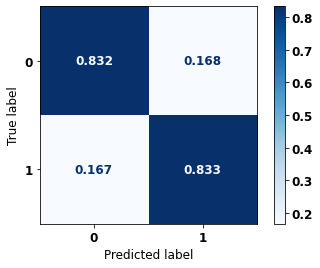


              precision    recall  f1-score   support

           0       0.94      0.83      0.88     18785
           1       0.60      0.83      0.70      5776

    accuracy                           0.83     24561
   macro avg       0.77      0.83      0.79     24561
weighted avg       0.86      0.83      0.84     24561



In [ ]:
display_confusion_matrix(rf_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the Random Forest, with SP data from 2016 to 2021, shows a good performance of the model, with 83% of accuracy.

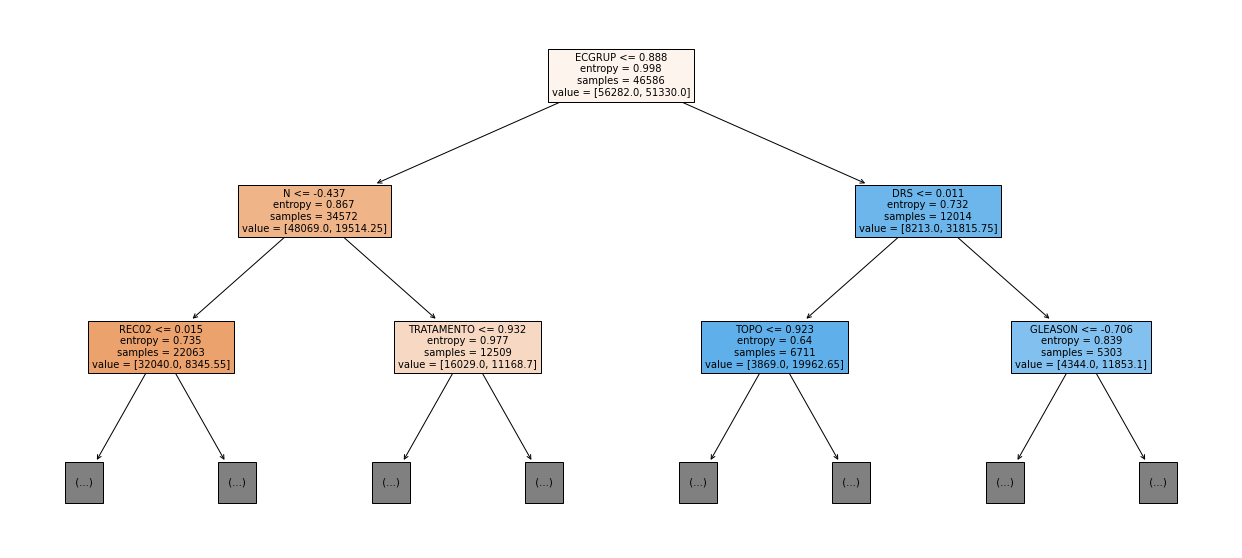

In [ ]:
show_tree(rf_sp_16_21, feat_SP_16_21, 2)

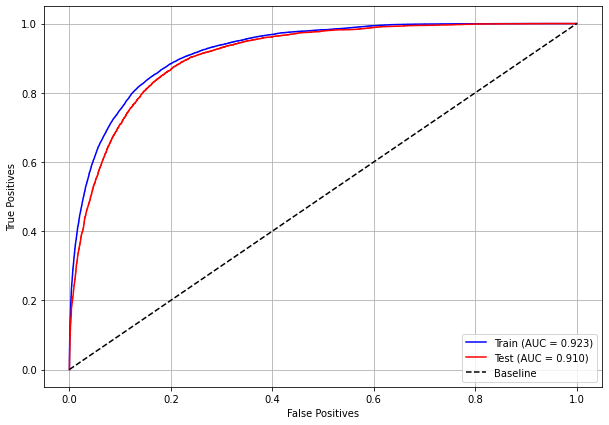

In [ ]:
plot_roc_curve(rf_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

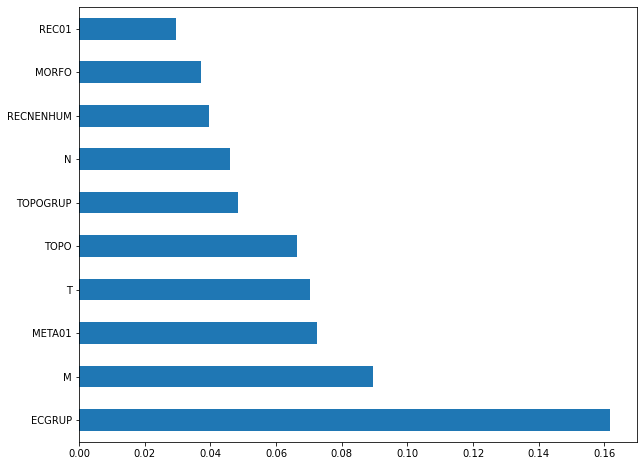

In [ ]:
plot_feat_importances(rf_sp_16_21, feat_SP_16_21)

> The four most important features in the model were `ECGRUP`, `M`, `META01`, and `T`.



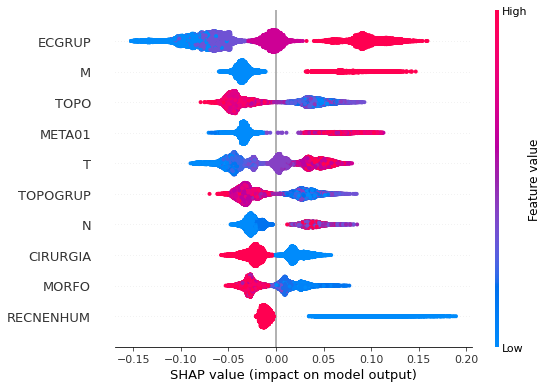

In [ ]:
plot_shap_values(rf_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.49},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.49}, criterion='entropy',
                       max_depth=6, random_state=10)

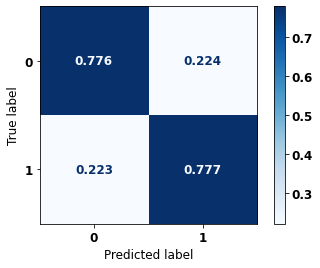


              precision    recall  f1-score   support

           0       0.82      0.78      0.80       492
           1       0.72      0.78      0.75       373

    accuracy                           0.78       865
   macro avg       0.77      0.78      0.77       865
weighted avg       0.78      0.78      0.78       865



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 78% of accuracy.

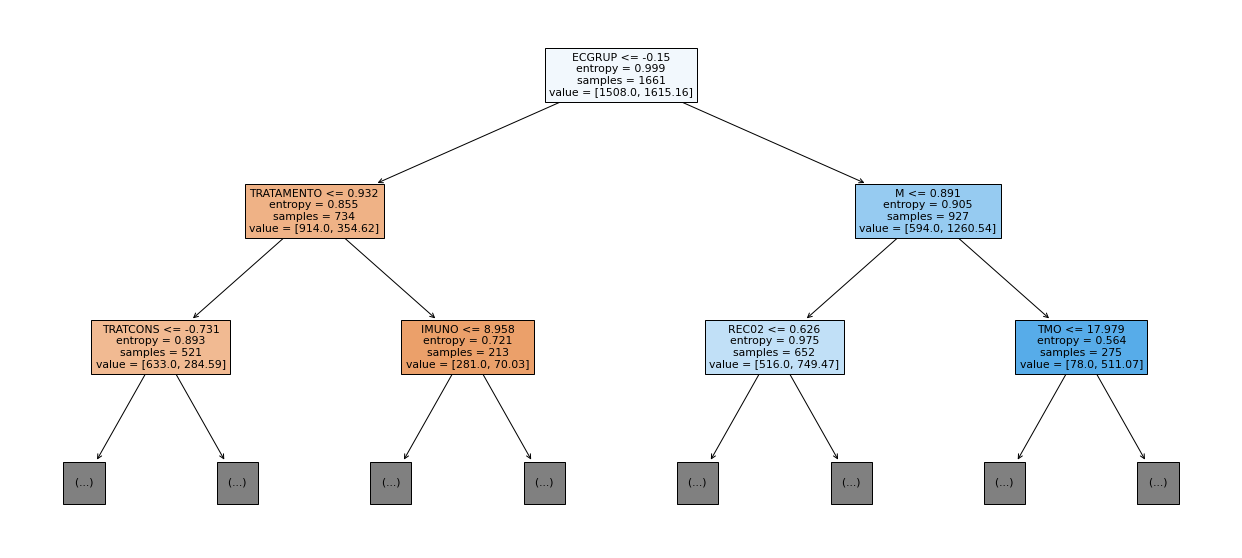

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

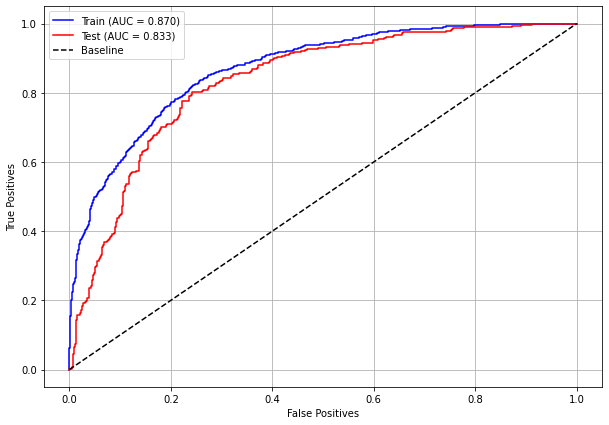

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

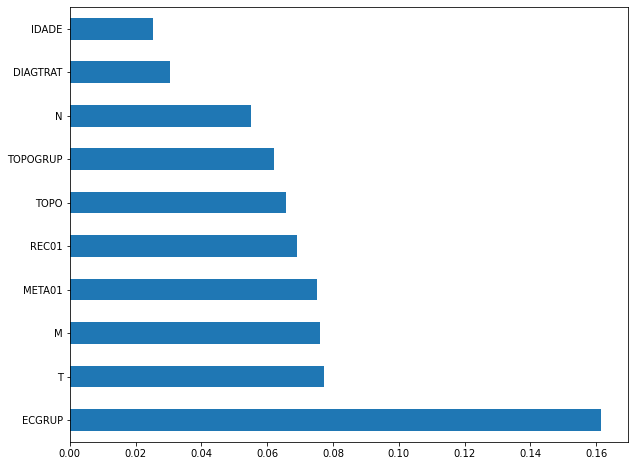

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `T`, `M` and `META01`.

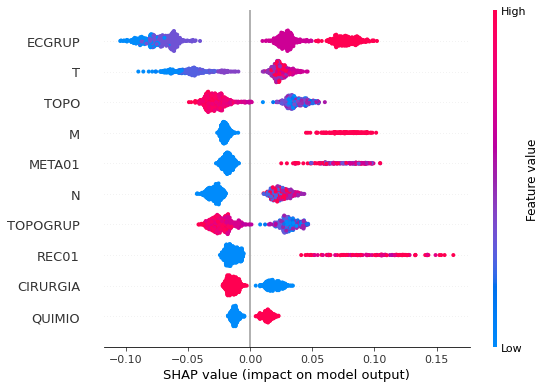

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:1.52},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1, 1: 1.52}, criterion='entropy',
                       max_depth=6, random_state=10)

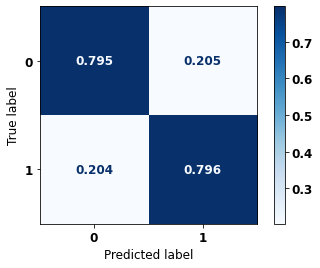


              precision    recall  f1-score   support

           0       0.85      0.79      0.82       741
           1       0.72      0.80      0.76       491

    accuracy                           0.80      1232
   macro avg       0.79      0.80      0.79      1232
weighted avg       0.80      0.80      0.80      1232



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


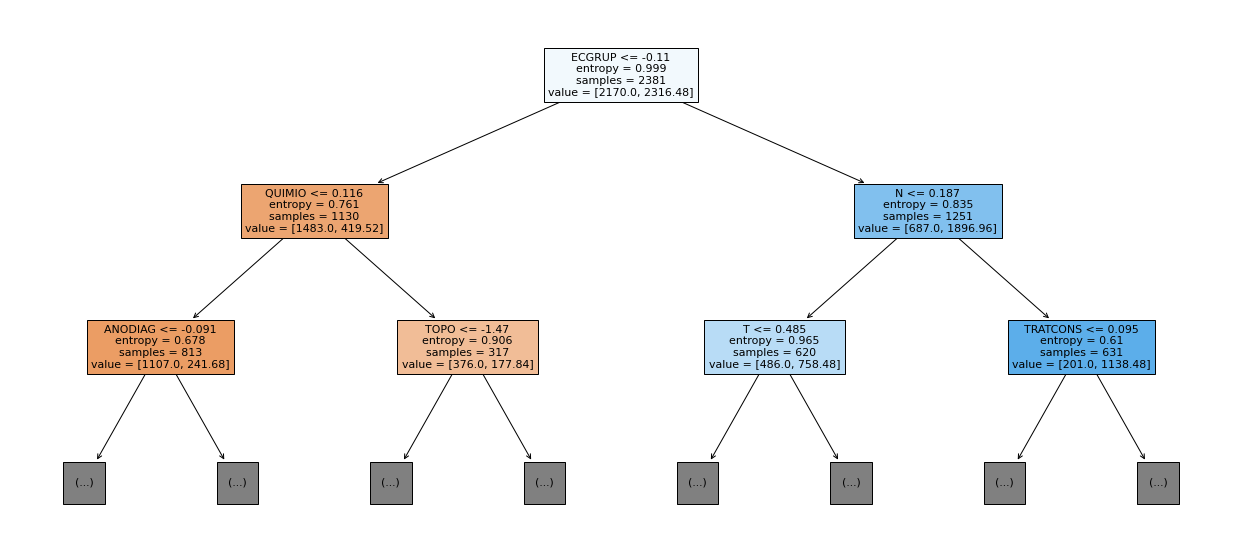

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

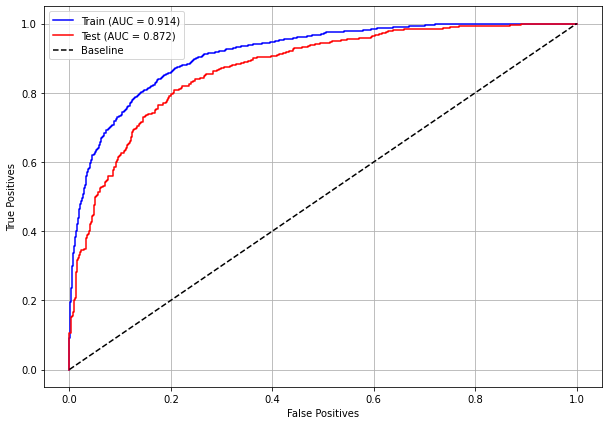

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

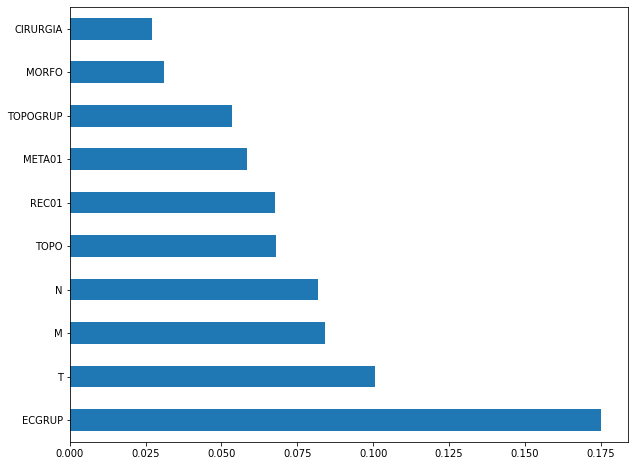

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `M` and `N`.

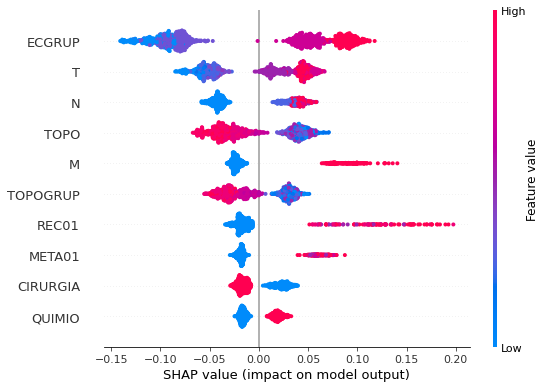

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed,
                                       class_weight={0:1, 1:1.7},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1, 1: 1.7}, criterion='entropy',
                       max_depth=6, random_state=10)

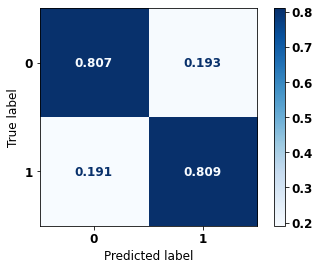


              precision    recall  f1-score   support

           0       0.88      0.81      0.84       973
           1       0.70      0.81      0.75       540

    accuracy                           0.81      1513
   macro avg       0.79      0.81      0.80      1513
weighted avg       0.82      0.81      0.81      1513



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


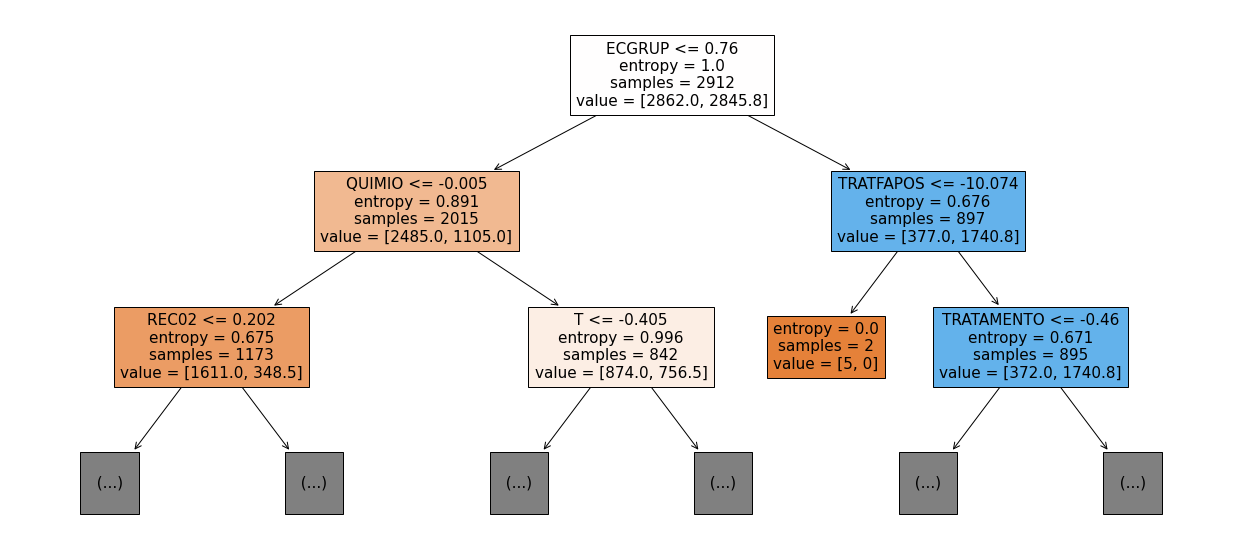

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

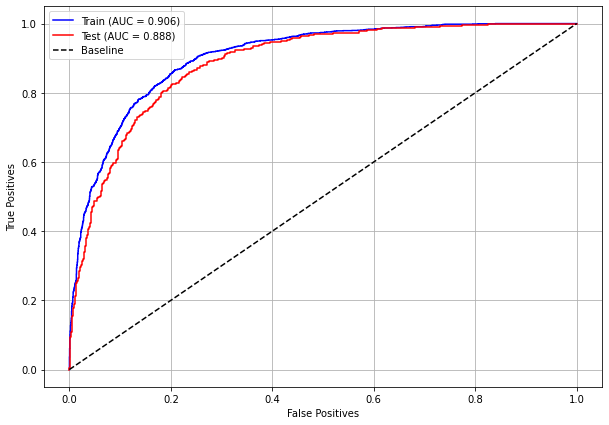

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

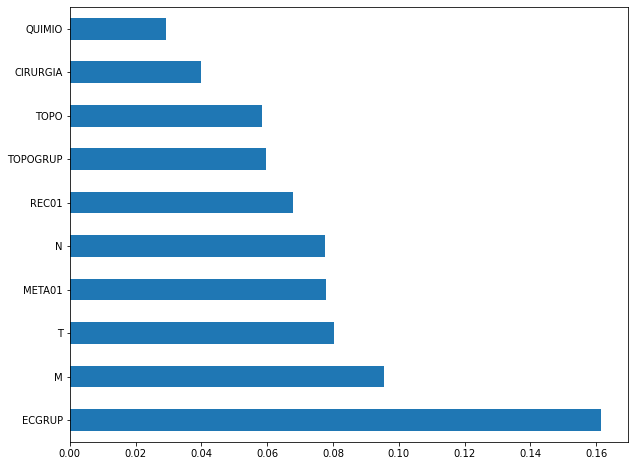

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `META01`.

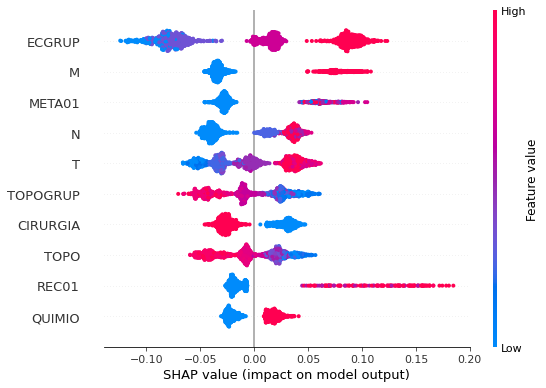

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.55},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 2.55}, criterion='entropy',
                       max_depth=6, random_state=10)

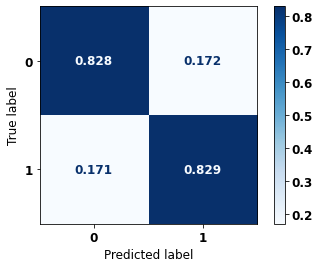


              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1421
           1       0.67      0.83      0.74       603

    accuracy                           0.83      2024
   macro avg       0.80      0.83      0.81      2024
weighted avg       0.85      0.83      0.83      2024



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


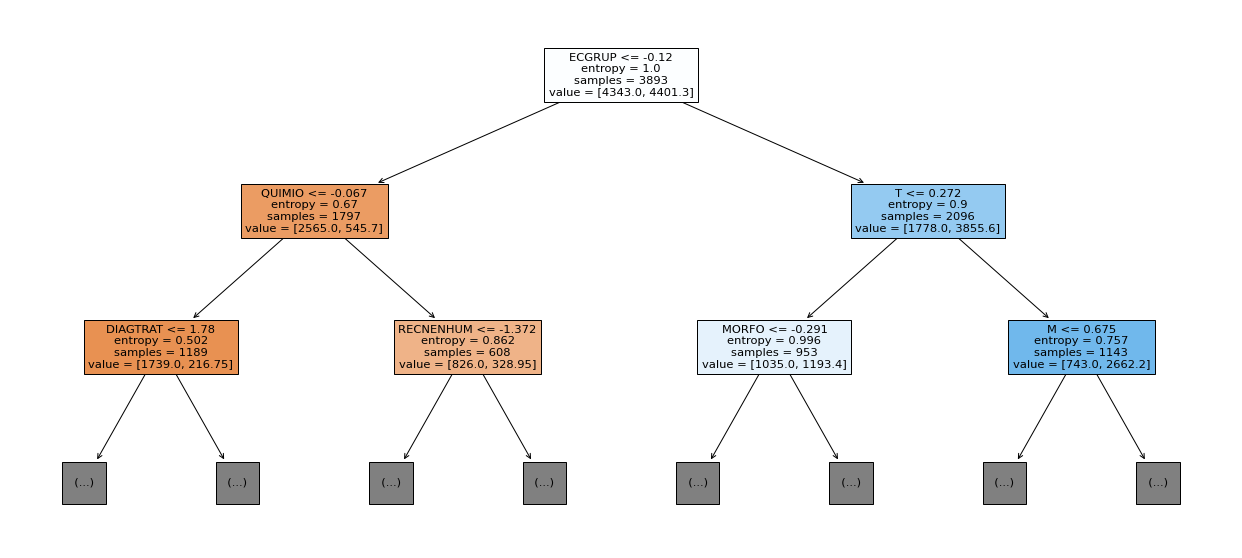

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

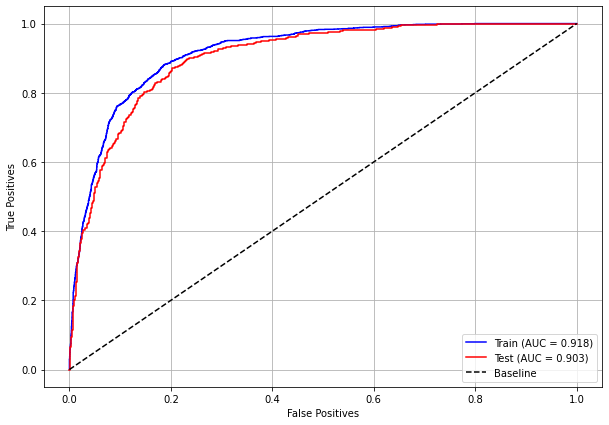

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

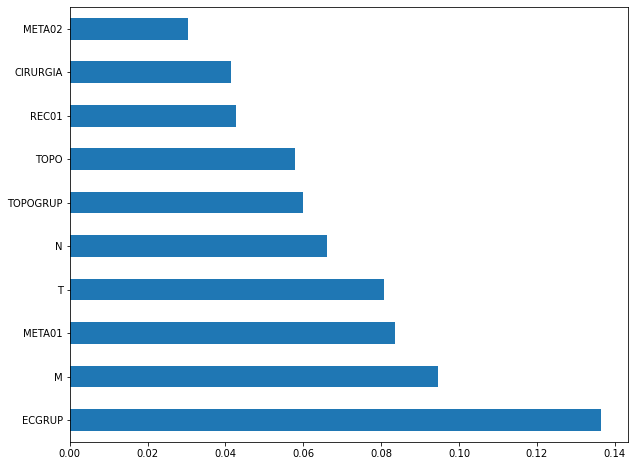

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `META01` and `T`.

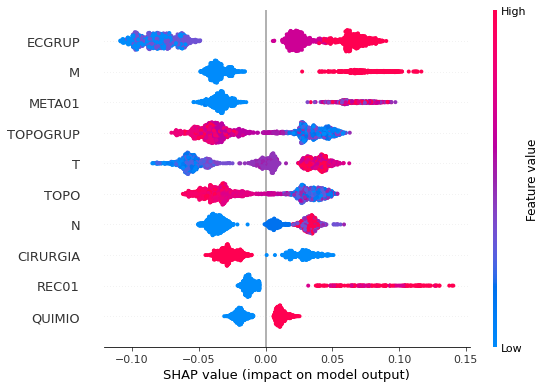

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
rf_fora_16_20 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1, 1:2.435},
                                       criterion='entropy',
                                       max_depth=7)

rf_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

RandomForestClassifier(class_weight={0: 1, 1: 2.435}, criterion='entropy',
                       max_depth=7, random_state=10)

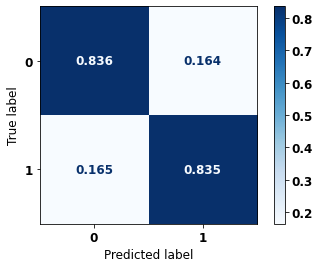


              precision    recall  f1-score   support

           0       0.95      0.84      0.89      1601
           1       0.59      0.84      0.69       461

    accuracy                           0.84      2062
   macro avg       0.77      0.84      0.79      2062
weighted avg       0.87      0.84      0.84      2062



In [ ]:
display_confusion_matrix(rf_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the Random Forest, with other states data from 2016 to 2020, also shows a good performance of the model, presenting 84% of accuracy.


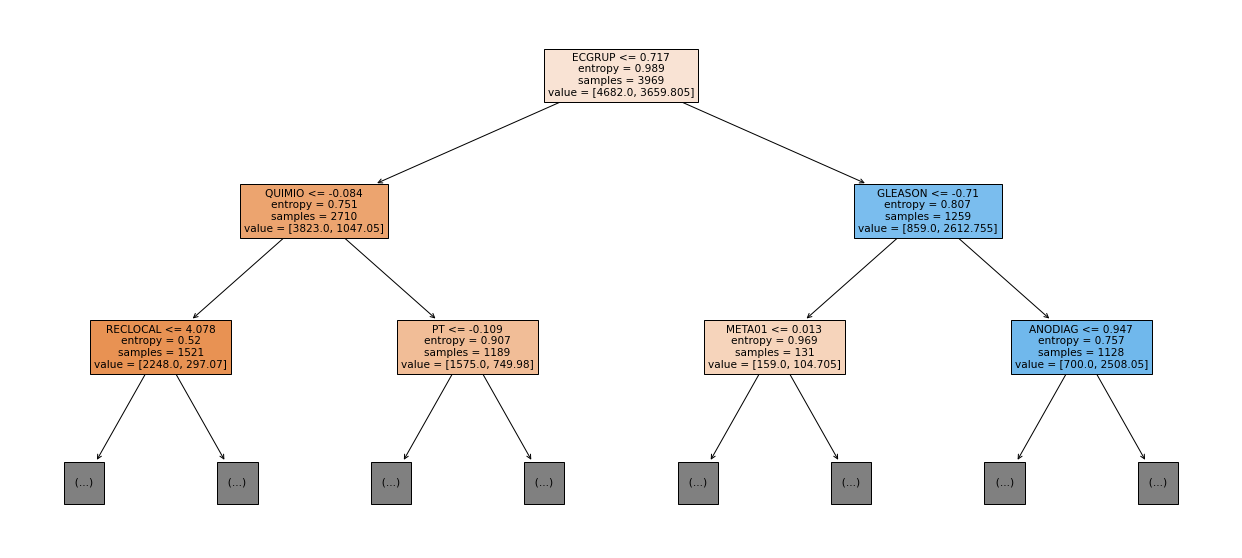

In [ ]:
show_tree(rf_fora_16_20, feat_OS_16_20, 2)

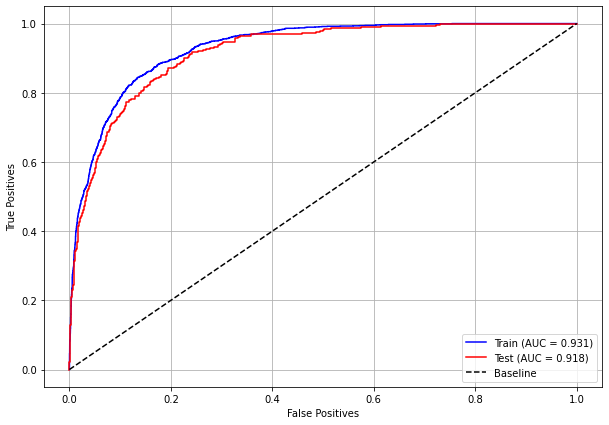

In [ ]:
plot_roc_curve(rf_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

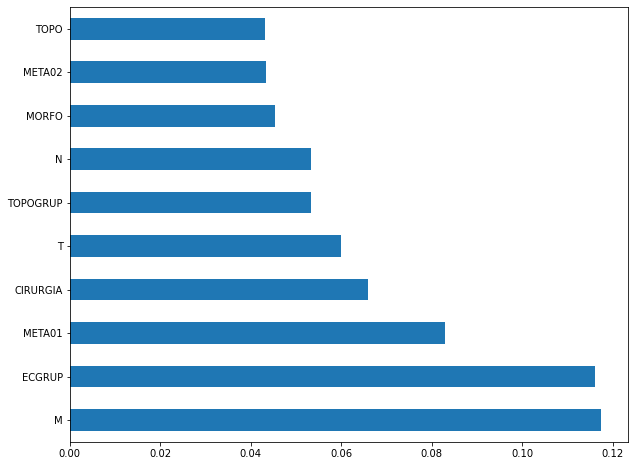

In [ ]:
plot_feat_importances(rf_fora_16_20, feat_OS_16_20)

> The four most important features in the model were `M`, `ECGRUP`, `META01` and `CIRURGIA`.

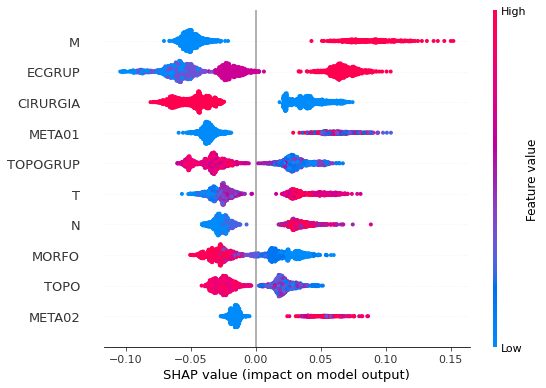

In [ ]:
plot_shap_values(rf_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the M column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in the trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=1.0245)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.0245)

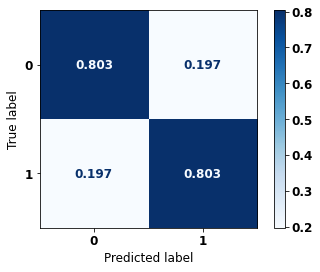


              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8010
           1       0.79      0.80      0.80      7357

    accuracy                           0.80     15367
   macro avg       0.80      0.80      0.80     15367
weighted avg       0.80      0.80      0.80     15367



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 80% of accuracy.

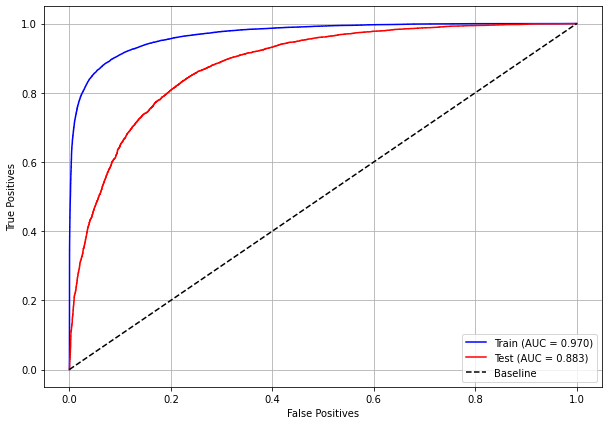

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

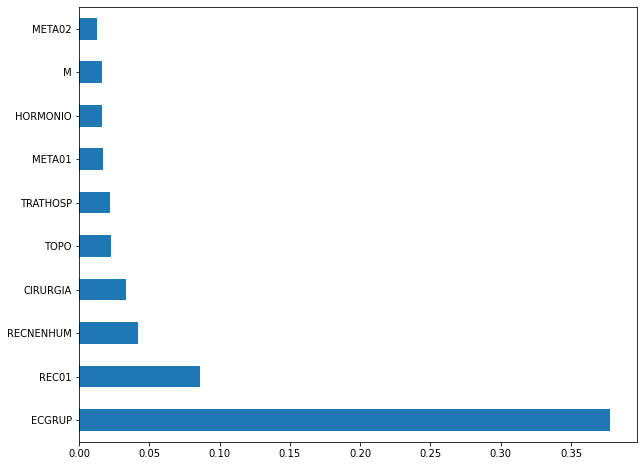

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot of advantage over the others. Following we have `REC01`, `RECNENHUM` and `CIRURGIA`.

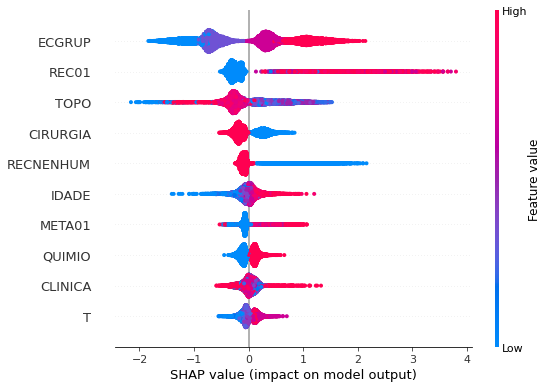

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=1.4)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.4)

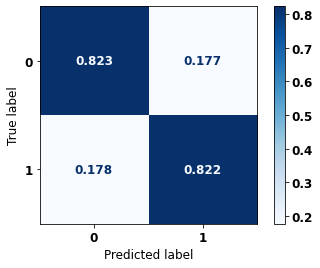


              precision    recall  f1-score   support

           0       0.86      0.82      0.84     10867
           1       0.78      0.82      0.80      8523

    accuracy                           0.82     19390
   macro avg       0.82      0.82      0.82     19390
weighted avg       0.82      0.82      0.82     19390



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 82% of accuracy.


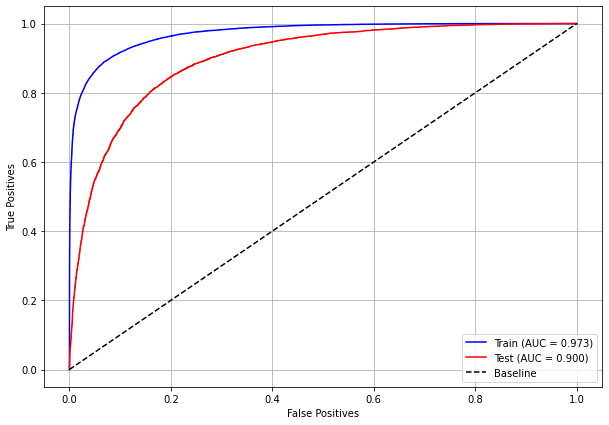

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

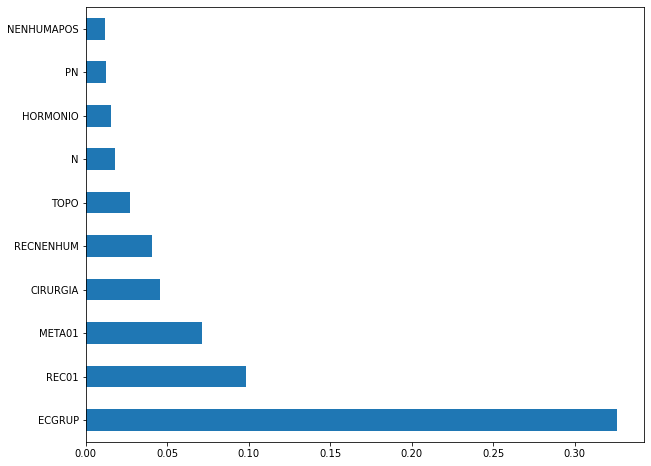

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `META01` and `CIRURGIA`. 

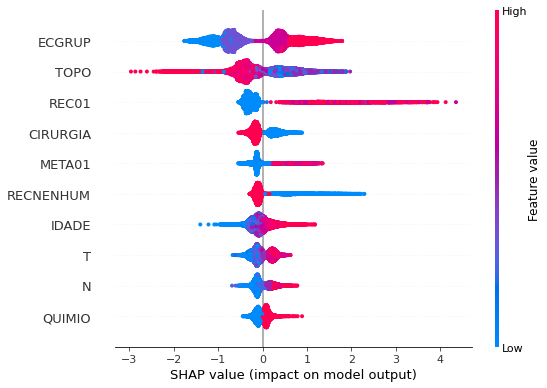

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = xgb.XGBClassifier(max_depth=10, 
                                 scale_pos_weight=1.66,
                                 random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.66)

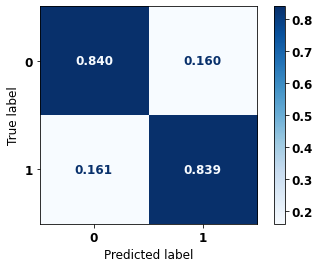


              precision    recall  f1-score   support

           0       0.89      0.84      0.87     15787
           1       0.77      0.84      0.80     10017

    accuracy                           0.84     25804
   macro avg       0.83      0.84      0.83     25804
weighted avg       0.84      0.84      0.84     25804



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 84% of accuracy.

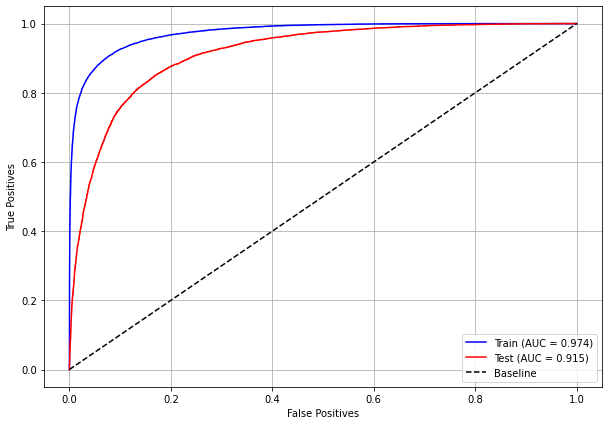

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

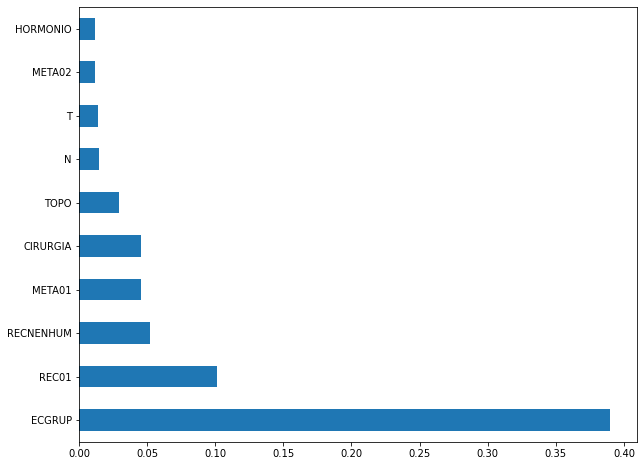

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `REC01`, `RECNENHUM` and `META01`. 

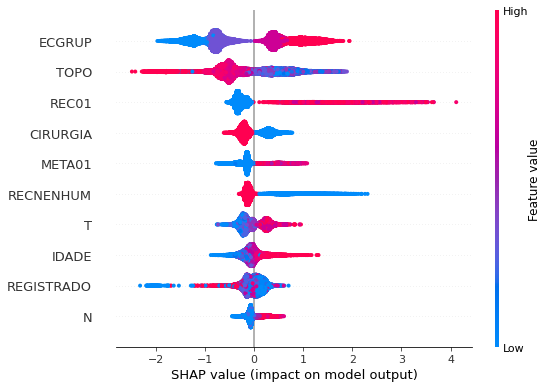

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed,
                                 scale_pos_weight=2.25)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=2.25)

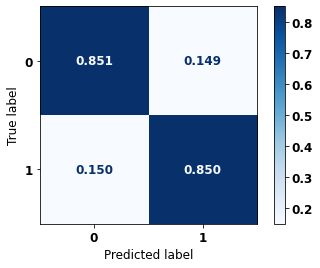


              precision    recall  f1-score   support

           0       0.93      0.85      0.89     21958
           1       0.72      0.85      0.78     10084

    accuracy                           0.85     32042
   macro avg       0.82      0.85      0.83     32042
weighted avg       0.86      0.85      0.85     32042



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 85% of accuracy.

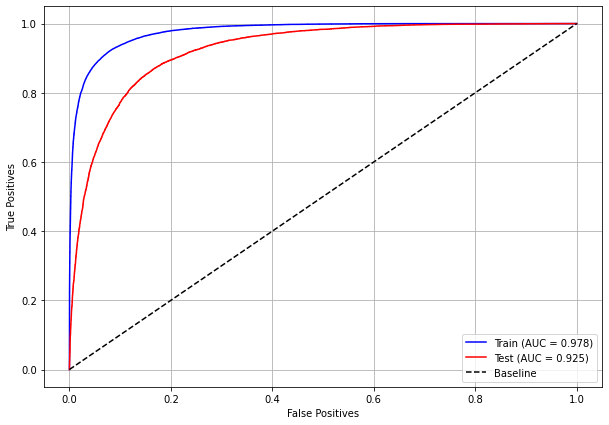

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

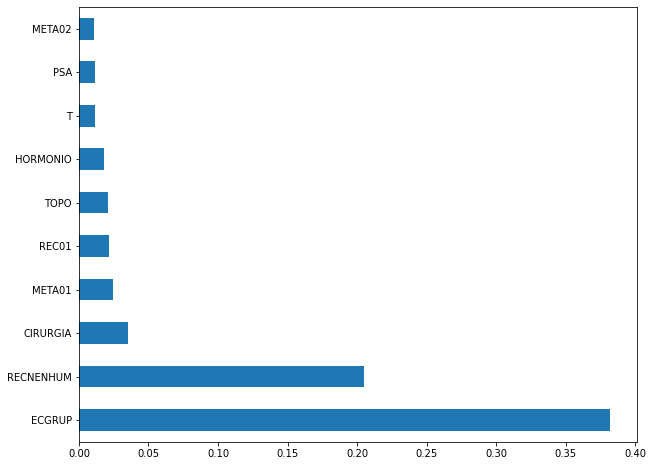

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with some advantage. Following we have `RECNENHUM`, `CIRURGIA` and `META01`. 

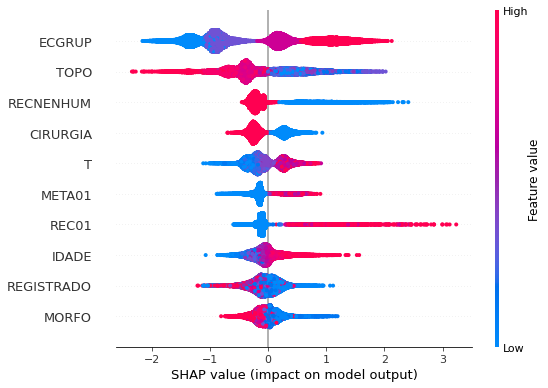

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2016 to 2021
xgb_sp_16_21 = xgb.XGBClassifier(max_depth=10, 
                                 random_state=seed, 
                                 scale_pos_weight=4)

xgb_sp_16_21.fit(X_trainSP_16_21, y_trainSP_16_21)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=4)

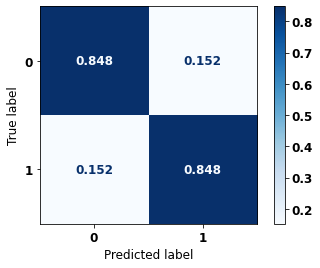


              precision    recall  f1-score   support

           0       0.95      0.85      0.90     18785
           1       0.63      0.85      0.72      5776

    accuracy                           0.85     24561
   macro avg       0.79      0.85      0.81     24561
weighted avg       0.87      0.85      0.86     24561



In [ ]:
display_confusion_matrix(xgb_sp_16_21, X_testSP_16_21, y_testSP_16_21)

> The confusion matrix obtained for the XGBoost, with SP data from 2016 to 2021, shows a good performance of the model, with 85% of accuracy.


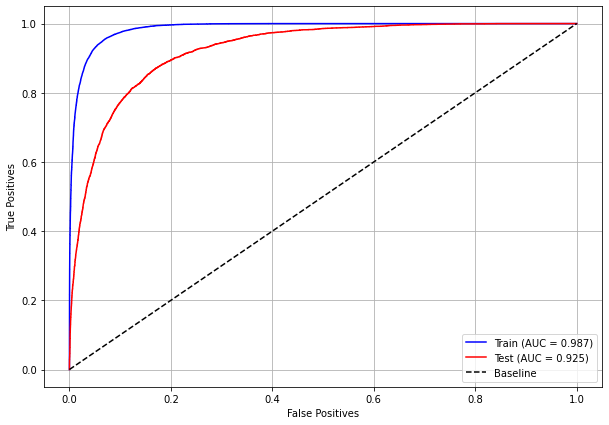

In [ ]:
plot_roc_curve(xgb_sp_16_21, X_trainSP_16_21, X_testSP_16_21, y_trainSP_16_21, y_testSP_16_21)

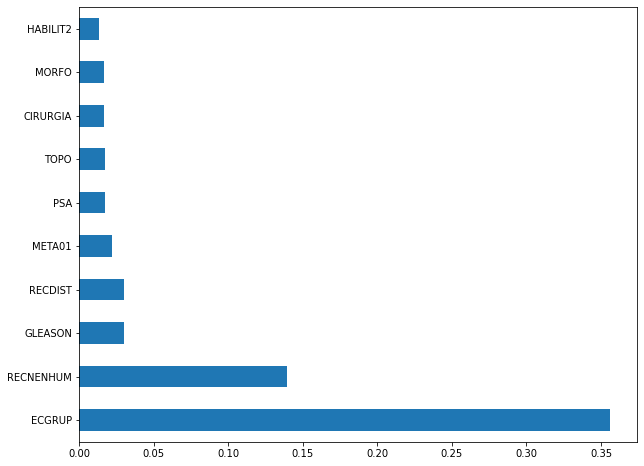

In [ ]:
plot_feat_importances(xgb_sp_16_21, feat_SP_16_21)

> The four most important features were `ECGRUP`, `RECNENHUM`, `GLEASON` and `RECDIST`.



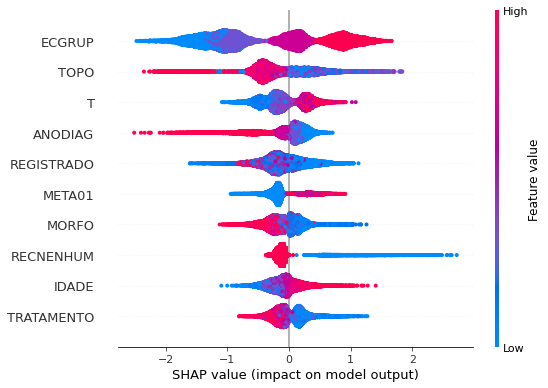

In [ ]:
plot_shap_values(xgb_sp_16_21, X_testSP_16_21, feat_SP_16_21)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.552,
                                   random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.552)

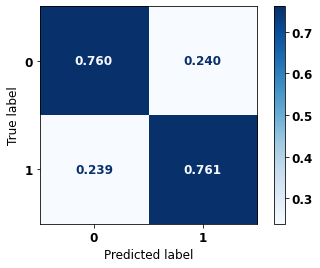


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       492
           1       0.71      0.76      0.73       373

    accuracy                           0.76       865
   macro avg       0.76      0.76      0.76       865
weighted avg       0.76      0.76      0.76       865



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 76% of accuracy.

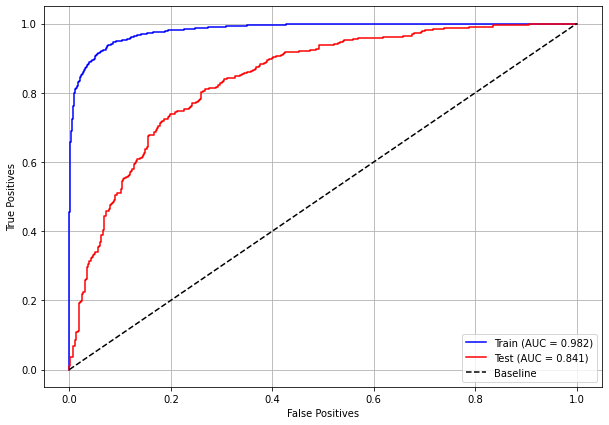

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

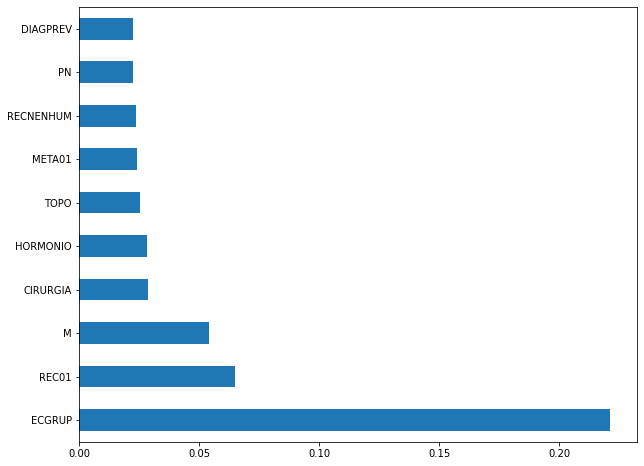

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

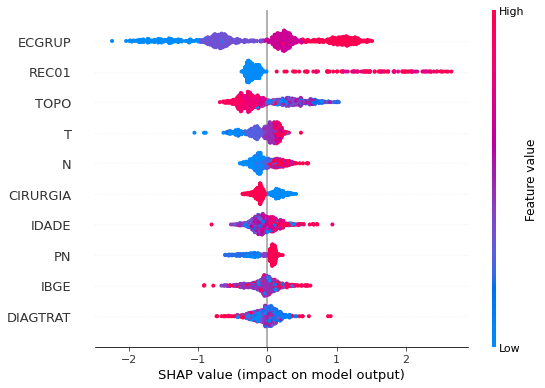

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.9695,
                                   random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.9695)

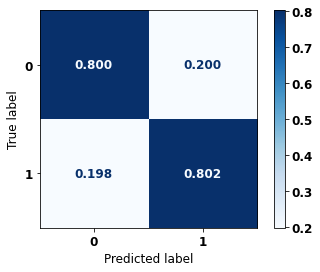


              precision    recall  f1-score   support

           0       0.86      0.80      0.83       741
           1       0.73      0.80      0.76       491

    accuracy                           0.80      1232
   macro avg       0.79      0.80      0.80      1232
weighted avg       0.81      0.80      0.80      1232



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 80% of accuracy.

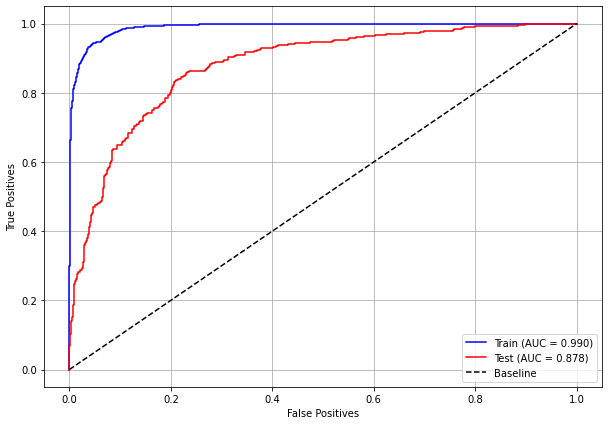

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

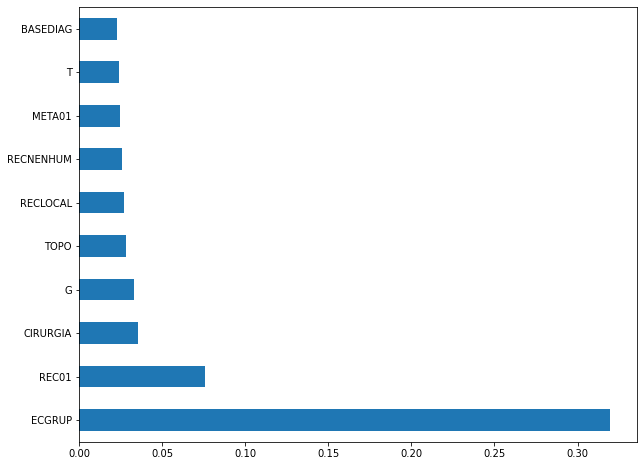

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `REC01`, `CIRURGIA` and `G`.

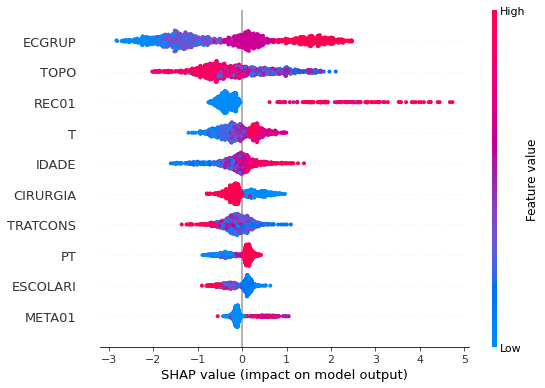

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=1.88,
                                   random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=1.88)

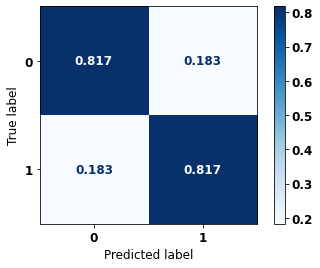


              precision    recall  f1-score   support

           0       0.89      0.82      0.85       973
           1       0.71      0.82      0.76       540

    accuracy                           0.82      1513
   macro avg       0.80      0.82      0.81      1513
weighted avg       0.83      0.82      0.82      1513



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states from 2008 to 2011, also shows a good performance of the model with 82% of accuracy.

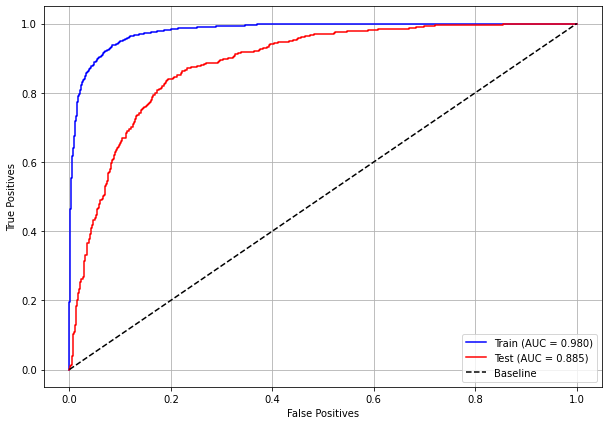

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

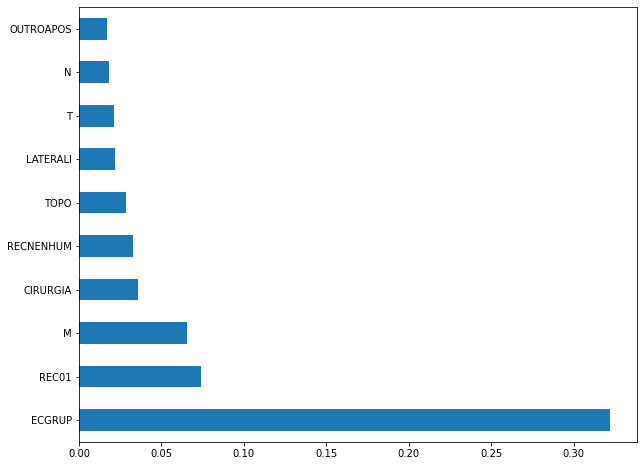

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `REC01`, `M` and `CIRURGIA`.

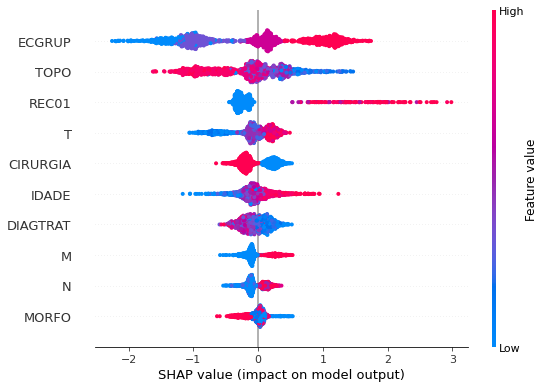

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=3.35,
                                   random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=3.35)

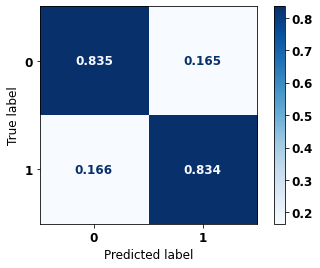


              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1421
           1       0.68      0.83      0.75       603

    accuracy                           0.83      2024
   macro avg       0.80      0.83      0.81      2024
weighted avg       0.85      0.83      0.84      2024



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

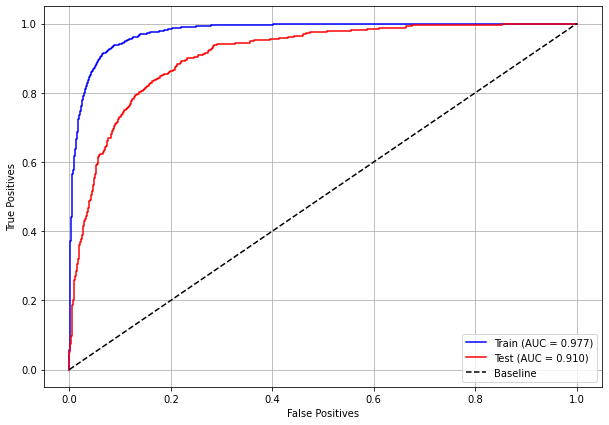

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

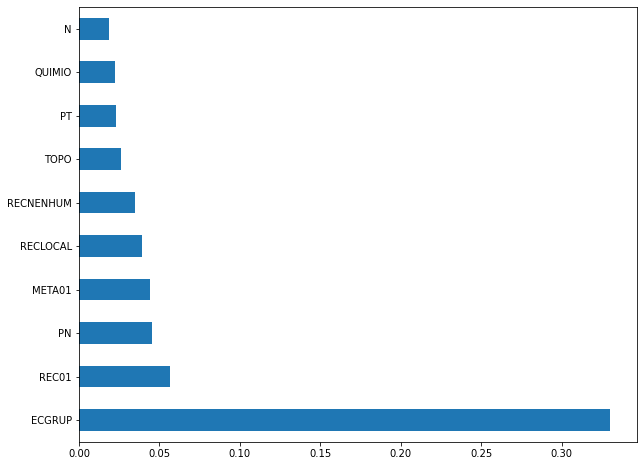

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `REC01`, `PN` and `META01`.

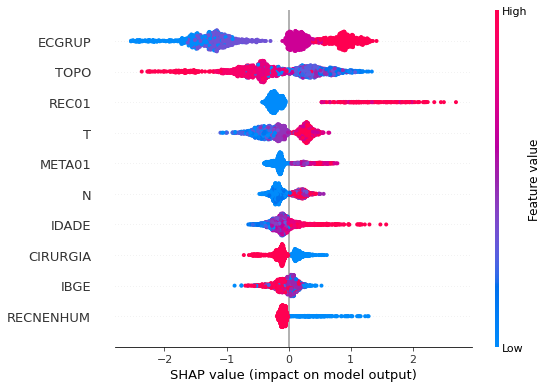

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2016 to 2020
xgb_fora_16_20 = xgb.XGBClassifier(max_depth=6, 
                                   scale_pos_weight=2.878,
                                   random_state=seed)

xgb_fora_16_20.fit(X_trainOS_16_20, y_trainOS_16_20)

XGBClassifier(max_depth=6, random_state=10, scale_pos_weight=2.878)

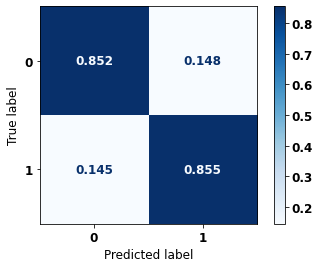


              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1601
           1       0.62      0.85      0.72       461

    accuracy                           0.85      2062
   macro avg       0.79      0.85      0.81      2062
weighted avg       0.88      0.85      0.86      2062



In [ ]:
display_confusion_matrix(xgb_fora_16_20, X_testOS_16_20, y_testOS_16_20)

> The confusion matrix obtained for the XGBoost, with other states from 2016 to 2020, shows the best performance comparing with the other models, with 85% of accuracy.

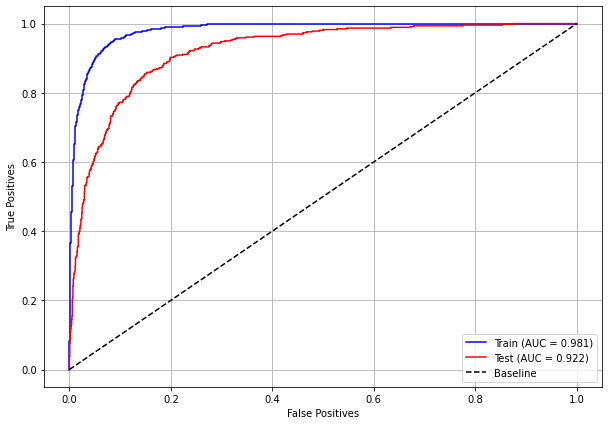

In [ ]:
plot_roc_curve(xgb_fora_16_20, X_trainOS_16_20, X_testOS_16_20, y_trainOS_16_20, y_testOS_16_20)

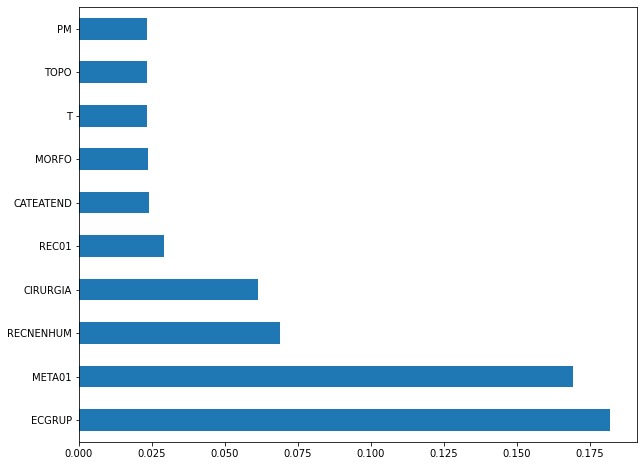

In [ ]:
plot_feat_importances(xgb_fora_16_20, feat_OS_16_20)

> The four most important features were `ECGRUP`, `META01`, `RECNENHUM` and `CIRURGIA`.

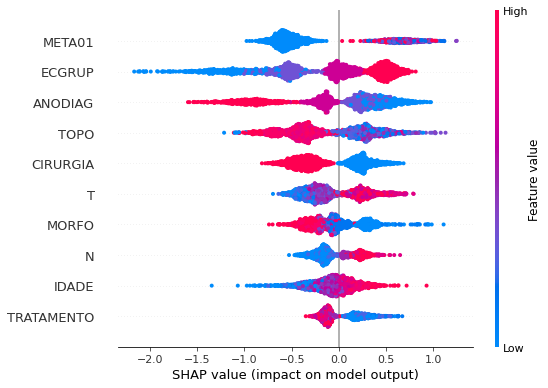

In [ ]:
plot_shap_values(xgb_fora_16_20, X_testOS_16_20, feat_OS_16_20)

Note that larger values of the ECGRUP column, shown in pink, have more influence for the model's prediction to be class 1, smaller values have greater weight for the prediction to be class 0. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

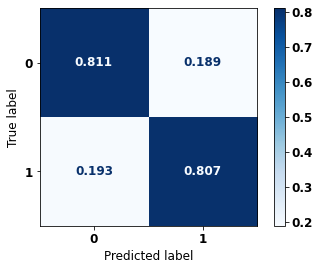


              precision    recall  f1-score   support

           0       0.84      0.81      0.83     10867
           1       0.77      0.81      0.79      8523

    accuracy                           0.81     19390
   macro avg       0.81      0.81      0.81     19390
weighted avg       0.81      0.81      0.81     19390



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

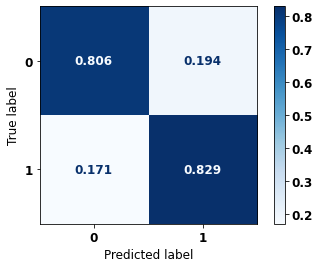


              precision    recall  f1-score   support

           0       0.88      0.81      0.84     15787
           1       0.73      0.83      0.78     10017

    accuracy                           0.82     25804
   macro avg       0.81      0.82      0.81     25804
weighted avg       0.82      0.82      0.82     25804



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

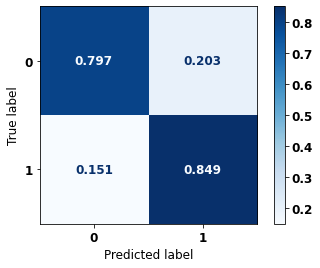


              precision    recall  f1-score   support

           0       0.92      0.80      0.85     21958
           1       0.66      0.85      0.74     10084

    accuracy                           0.81     32042
   macro avg       0.79      0.82      0.80     32042
weighted avg       0.84      0.81      0.82     32042



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

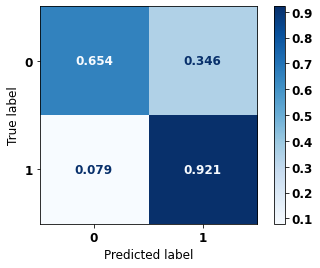


              precision    recall  f1-score   support

           0       0.96      0.65      0.78     18785
           1       0.45      0.92      0.60      5776

    accuracy                           0.72     24561
   macro avg       0.71      0.79      0.69     24561
weighted avg       0.84      0.72      0.74     24561



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2000 to 2003**

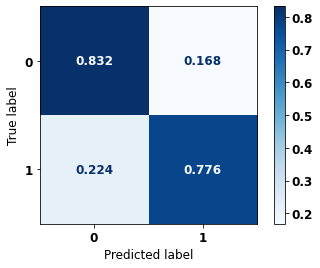


              precision    recall  f1-score   support

           0       0.83      0.83      0.83     10867
           1       0.78      0.78      0.78      8523

    accuracy                           0.81     19390
   macro avg       0.80      0.80      0.80     19390
weighted avg       0.81      0.81      0.81     19390



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

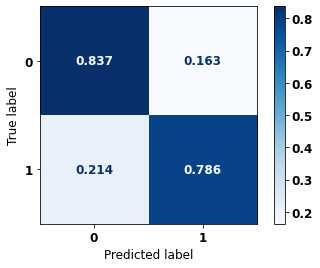


              precision    recall  f1-score   support

           0       0.86      0.84      0.85     15787
           1       0.75      0.79      0.77     10017

    accuracy                           0.82     25804
   macro avg       0.81      0.81      0.81     25804
weighted avg       0.82      0.82      0.82     25804



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

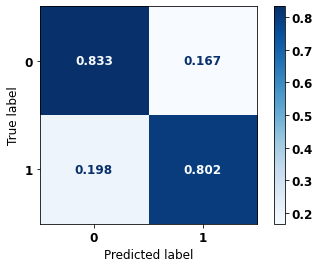


              precision    recall  f1-score   support

           0       0.90      0.83      0.87     21958
           1       0.69      0.80      0.74     10084

    accuracy                           0.82     32042
   macro avg       0.79      0.82      0.80     32042
weighted avg       0.83      0.82      0.83     32042



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

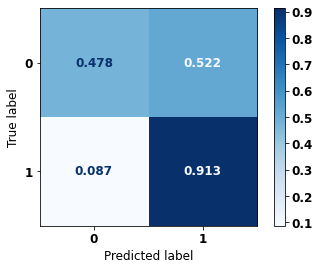


              precision    recall  f1-score   support

           0       0.95      0.48      0.63     18785
           1       0.35      0.91      0.51      5776

    accuracy                           0.58     24561
   macro avg       0.65      0.70      0.57     24561
weighted avg       0.81      0.58      0.60     24561



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2004 to 2007**

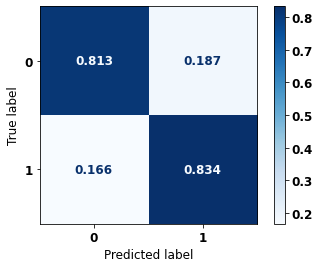


              precision    recall  f1-score   support

           0       0.89      0.81      0.85     15787
           1       0.74      0.83      0.78     10017

    accuracy                           0.82     25804
   macro avg       0.81      0.82      0.82     25804
weighted avg       0.83      0.82      0.82     25804



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

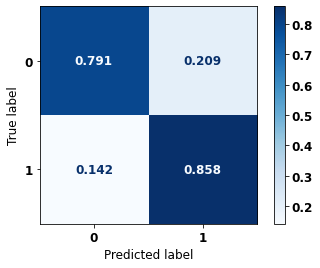


              precision    recall  f1-score   support

           0       0.92      0.79      0.85     21958
           1       0.65      0.86      0.74     10084

    accuracy                           0.81     32042
   macro avg       0.79      0.82      0.80     32042
weighted avg       0.84      0.81      0.82     32042



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

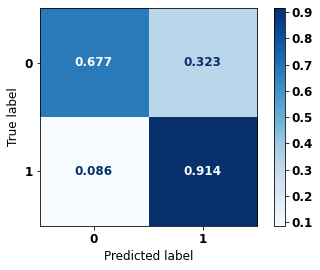


              precision    recall  f1-score   support

           0       0.96      0.68      0.79     18785
           1       0.47      0.91      0.62      5776

    accuracy                           0.73     24561
   macro avg       0.71      0.80      0.71     24561
weighted avg       0.85      0.73      0.75     24561



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2004 to 2007**

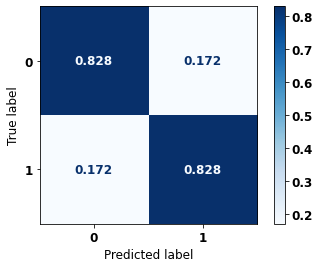


              precision    recall  f1-score   support

           0       0.88      0.83      0.86     15787
           1       0.75      0.83      0.79     10017

    accuracy                           0.83     25804
   macro avg       0.82      0.83      0.82     25804
weighted avg       0.83      0.83      0.83     25804



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

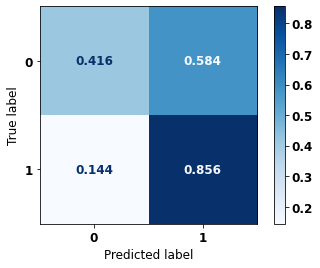


              precision    recall  f1-score   support

           0       0.86      0.42      0.56     21958
           1       0.40      0.86      0.55     10084

    accuracy                           0.55     32042
   macro avg       0.63      0.64      0.55     32042
weighted avg       0.72      0.55      0.56     32042



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

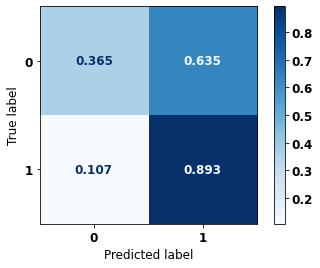


              precision    recall  f1-score   support

           0       0.92      0.36      0.52     18785
           1       0.30      0.89      0.45      5776

    accuracy                           0.49     24561
   macro avg       0.61      0.63      0.49     24561
weighted avg       0.77      0.49      0.51     24561



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2008 to 2011**

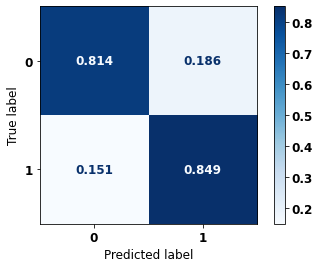


              precision    recall  f1-score   support

           0       0.92      0.81      0.86     21958
           1       0.68      0.85      0.75     10084

    accuracy                           0.83     32042
   macro avg       0.80      0.83      0.81     32042
weighted avg       0.84      0.83      0.83     32042



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

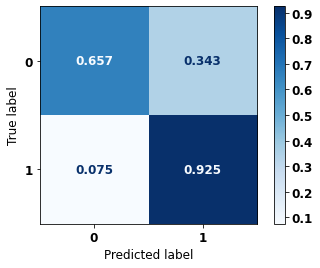


              precision    recall  f1-score   support

           0       0.97      0.66      0.78     18785
           1       0.45      0.92      0.61      5776

    accuracy                           0.72     24561
   macro avg       0.71      0.79      0.70     24561
weighted avg       0.85      0.72      0.74     24561



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2008 to 2011**

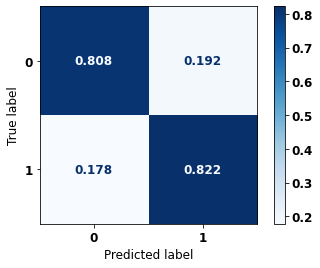


              precision    recall  f1-score   support

           0       0.91      0.81      0.86     21958
           1       0.66      0.82      0.73     10084

    accuracy                           0.81     32042
   macro avg       0.79      0.82      0.79     32042
weighted avg       0.83      0.81      0.82     32042



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

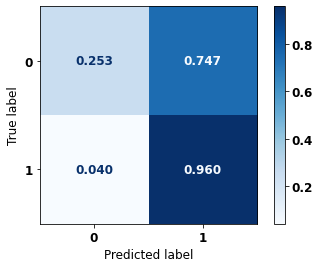


              precision    recall  f1-score   support

           0       0.95      0.25      0.40     18785
           1       0.28      0.96      0.44      5776

    accuracy                           0.42     24561
   macro avg       0.62      0.61      0.42     24561
weighted avg       0.80      0.42      0.41     24561



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_16_21, y_testSP_16_21)

### **Random Forest SP for years 2012 to 2015**

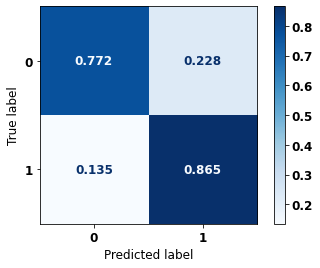


              precision    recall  f1-score   support

           0       0.95      0.77      0.85     18785
           1       0.54      0.86      0.66      5776

    accuracy                           0.79     24561
   macro avg       0.74      0.82      0.76     24561
weighted avg       0.85      0.79      0.81     24561



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **XGBoost SP for years 2012 to 2015**

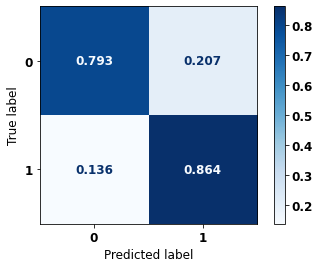


              precision    recall  f1-score   support

           0       0.95      0.79      0.86     18785
           1       0.56      0.86      0.68      5776

    accuracy                           0.81     24561
   macro avg       0.76      0.83      0.77     24561
weighted avg       0.86      0.81      0.82     24561



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_16_21, y_testSP_16_21)

### **Random Forest Other states for years 2000 to 2003**

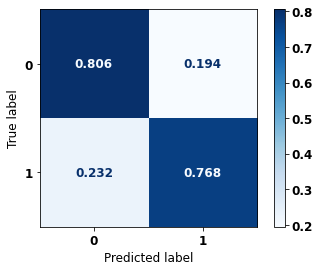


              precision    recall  f1-score   support

           0       0.84      0.81      0.82       741
           1       0.72      0.77      0.75       491

    accuracy                           0.79      1232
   macro avg       0.78      0.79      0.78      1232
weighted avg       0.79      0.79      0.79      1232



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

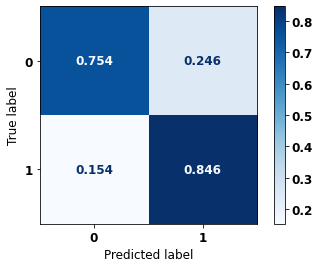


              precision    recall  f1-score   support

           0       0.90      0.75      0.82       973
           1       0.66      0.85      0.74       540

    accuracy                           0.79      1513
   macro avg       0.78      0.80      0.78      1513
weighted avg       0.81      0.79      0.79      1513



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

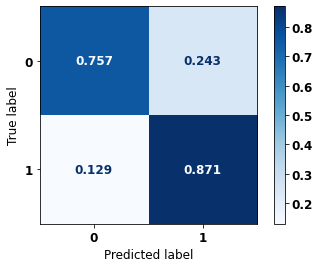


              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1421
           1       0.60      0.87      0.71       603

    accuracy                           0.79      2024
   macro avg       0.77      0.81      0.77      2024
weighted avg       0.83      0.79      0.80      2024



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

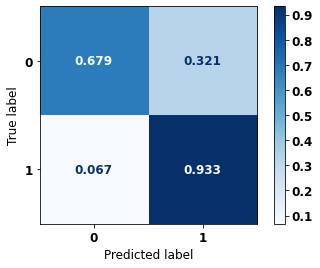


              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1601
           1       0.46      0.93      0.61       461

    accuracy                           0.74      2062
   macro avg       0.71      0.81      0.71      2062
weighted avg       0.86      0.74      0.76      2062



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2000 to 2003**

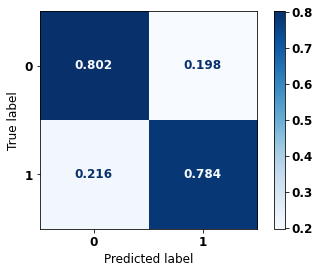


              precision    recall  f1-score   support

           0       0.85      0.80      0.82       741
           1       0.72      0.78      0.75       491

    accuracy                           0.79      1232
   macro avg       0.79      0.79      0.79      1232
weighted avg       0.80      0.79      0.80      1232



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

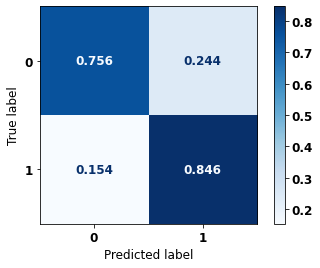


              precision    recall  f1-score   support

           0       0.90      0.76      0.82       973
           1       0.66      0.85      0.74       540

    accuracy                           0.79      1513
   macro avg       0.78      0.80      0.78      1513
weighted avg       0.81      0.79      0.79      1513



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

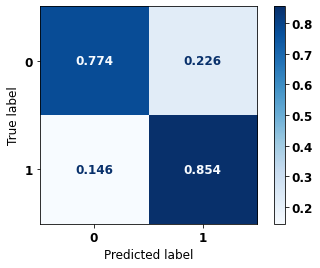


              precision    recall  f1-score   support

           0       0.93      0.77      0.84      1421
           1       0.62      0.85      0.72       603

    accuracy                           0.80      2024
   macro avg       0.77      0.81      0.78      2024
weighted avg       0.83      0.80      0.81      2024



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

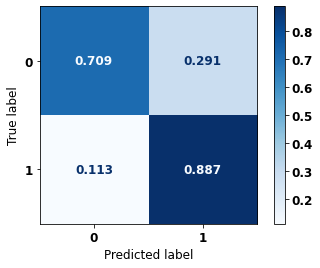


              precision    recall  f1-score   support

           0       0.96      0.71      0.81      1601
           1       0.47      0.89      0.61       461

    accuracy                           0.75      2062
   macro avg       0.71      0.80      0.71      2062
weighted avg       0.85      0.75      0.77      2062



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2004 to 2007**

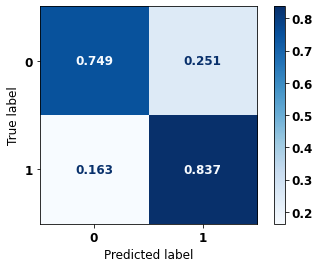


              precision    recall  f1-score   support

           0       0.89      0.75      0.81       973
           1       0.65      0.84      0.73       540

    accuracy                           0.78      1513
   macro avg       0.77      0.79      0.77      1513
weighted avg       0.81      0.78      0.78      1513



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

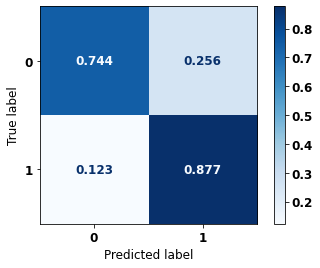


              precision    recall  f1-score   support

           0       0.93      0.74      0.83      1421
           1       0.59      0.88      0.71       603

    accuracy                           0.78      2024
   macro avg       0.76      0.81      0.77      2024
weighted avg       0.83      0.78      0.79      2024



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

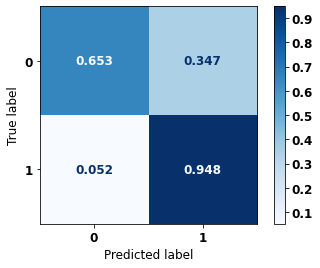


              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1601
           1       0.44      0.95      0.60       461

    accuracy                           0.72      2062
   macro avg       0.71      0.80      0.69      2062
weighted avg       0.86      0.72      0.74      2062



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2004 to 2007**

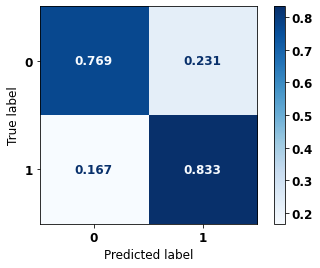


              precision    recall  f1-score   support

           0       0.89      0.77      0.83       973
           1       0.67      0.83      0.74       540

    accuracy                           0.79      1513
   macro avg       0.78      0.80      0.78      1513
weighted avg       0.81      0.79      0.80      1513



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

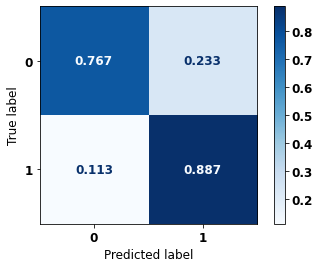


              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1421
           1       0.62      0.89      0.73       603

    accuracy                           0.80      2024
   macro avg       0.78      0.83      0.79      2024
weighted avg       0.84      0.80      0.81      2024



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

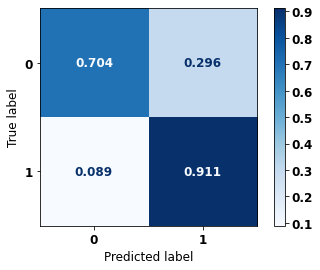


              precision    recall  f1-score   support

           0       0.96      0.70      0.81      1601
           1       0.47      0.91      0.62       461

    accuracy                           0.75      2062
   macro avg       0.72      0.81      0.72      2062
weighted avg       0.85      0.75      0.77      2062



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2008 to 2011**

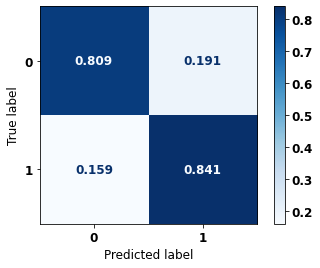


              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1421
           1       0.65      0.84      0.73       603

    accuracy                           0.82      2024
   macro avg       0.79      0.82      0.80      2024
weighted avg       0.84      0.82      0.82      2024



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

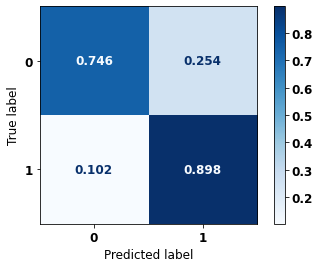


              precision    recall  f1-score   support

           0       0.96      0.75      0.84      1601
           1       0.50      0.90      0.65       461

    accuracy                           0.78      2062
   macro avg       0.73      0.82      0.74      2062
weighted avg       0.86      0.78      0.80      2062



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2008 to 2011**

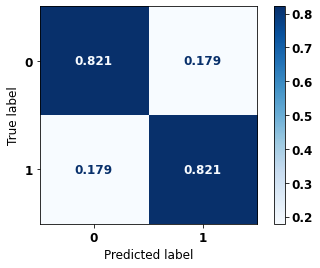


              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1421
           1       0.66      0.82      0.73       603

    accuracy                           0.82      2024
   macro avg       0.79      0.82      0.80      2024
weighted avg       0.84      0.82      0.83      2024



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

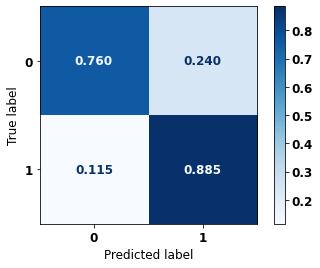


              precision    recall  f1-score   support

           0       0.96      0.76      0.85      1601
           1       0.52      0.89      0.65       461

    accuracy                           0.79      2062
   macro avg       0.74      0.82      0.75      2062
weighted avg       0.86      0.79      0.80      2062



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_16_20, y_testOS_16_20)

### **Random Forest Other states for years 2012 to 2015**

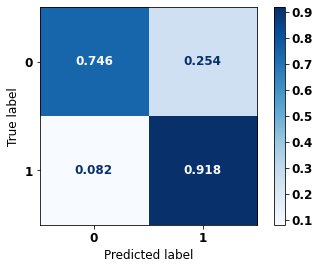


              precision    recall  f1-score   support

           0       0.97      0.75      0.84      1601
           1       0.51      0.92      0.66       461

    accuracy                           0.78      2062
   macro avg       0.74      0.83      0.75      2062
weighted avg       0.87      0.78      0.80      2062



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_16_20, y_testOS_16_20)

### **XGBoost Other states for years 2012 to 2015**

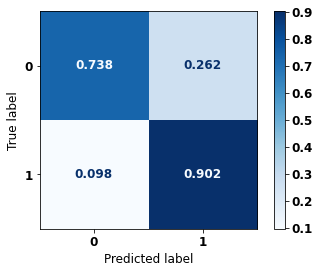


              precision    recall  f1-score   support

           0       0.96      0.74      0.84      1601
           1       0.50      0.90      0.64       461

    accuracy                           0.77      2062
   macro avg       0.73      0.82      0.74      2062
weighted avg       0.86      0.77      0.79      2062



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_16_20, y_testOS_16_20)